# LSTM con Keras Tuner

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

from keras.metrics import MeanAbsoluteError

import keras_tuner as kt
from keras.utils.vis_utils import plot_model
#from keras_sequential_ascii import keras2ascii
from keras.callbacks import EarlyStopping, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta
import ast

import pickle

In [2]:
### Creacion de la listas de los parametros
# Lista de combinaciones para los experimentos
list1 = [['Month', 'Day', 'Hour', 'High Wind Speed m/s'], ['High Wind Speed m/s']]
list2 = [24, 48, 72, 96]
list3 = [1, 24]
listcomb = [list1, list2, list3]
# Realiza las distitnas combinaciones
combinations = [p for p in itertools.product(*listcomb)]
# Elimina las combinaciones SIMO
for idx, comb in enumerate(combinations):
    if comb[2] == 24 and comb[0] == 'High Wind Speed m/s':
        combinations.pop(idx)

# Agrega cada combinacion a su respectiva lista
list_rect = []
list_mimo = []
for comb in combinations:
    if comb[2] == 1:
        list_rect.append(comb)
    else:
        list_mimo.append(comb)

In [ ]:
plot_model(M, show_shapes=True, show_layer_names=True)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Dataset de entrenamiento
df_Nizanda = pd.read_csv('./Datasets/Nizanda_T1.csv')
df_Nizanda

Day  Month  Year  ...  Rain Rate mm/h  ET mm                 Date
0        1      1  2017  ...             0.0    NaN  2017-01-01 00:00:00
1        1      1  2017  ...             0.0    NaN  2017-01-01 01:00:00
2        1      1  2017  ...             0.0    NaN  2017-01-01 02:00:00
3        1      1  2017  ...             0.0    NaN  2017-01-01 03:00:00
4        1      1  2017  ...             0.0    NaN  2017-01-01 04:00:00
...    ...    ...   ...  ...             ...    ...                  ...
17406   31     12  2018  ...             0.0    NaN  2018-12-31 19:00:00
17407   31     12  2018  ...             0.0    NaN  2018-12-31 20:00:00
17408   31     12  2018  ...             0.0    NaN  2018-12-31 21:00:00
17409   31     12  2018  ...             0.0    NaN  2018-12-31 22:00:00
17410   31     12  2018  ...             0.0    NaN  2018-12-31 23:00:00

[17411 rows x 22 columns]

In [5]:
df_Prueba = pd.read_csv('./Datasets/Nizanda_22_Prueba.csv')
df_Prueba

Day  Month  Year  ...  Rain Rate mm/h  ET mm                 Date
0       1      1  2022  ...             0.0   0.03  2022-01-01 00:00:00
1       1      1  2022  ...             0.0   0.03  2022-01-01 01:00:00
2       1      1  2022  ...             0.0   0.03  2022-01-01 02:00:00
3       1      1  2022  ...             0.0   0.03  2022-01-01 03:00:00
4       1      1  2022  ...             0.0   0.00  2022-01-01 04:00:00
...   ...    ...   ...  ...             ...    ...                  ...
8755   31     12  2022  ...             0.0   0.08  2022-12-31 19:00:00
8756   31     12  2022  ...             0.0   0.08  2022-12-31 20:00:00
8757   31     12  2022  ...             0.0   0.08  2022-12-31 21:00:00
8758   31     12  2022  ...             0.0   0.05  2022-12-31 22:00:00
8759   31     12  2022  ...             0.0   0.05  2022-12-31 23:00:00

[8760 rows x 22 columns]

In [6]:
# Creacion del diccionario resultados_LSTM
resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RSME': [], 'MAE': [], 'Params': []}

# Transformacion de diccionario a Dataframe
df_LSTM_train = pd.DataFrame(resLSTM)

# Creacion del diccionario resultados_LSTM
#resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RSME': [], 'MAE': [], 'Params': []}
resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}

# Transformacion de diccionario a Dataframe
df_LSTM_test = pd.DataFrame(resLSTM)

In [7]:
resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}

# Transformacion de diccionario a Dataframe
df_LSTM_test_MIMO = pd.DataFrame(resLSTM)

In [8]:
resLSTM = {'Mes': [], 'Dia': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Modelo': [], 'Metodo': [], 'Comb': [], 'Params': []}

# Transformacion de diccionario a Dataframe
df_LSTM_sim = pd.DataFrame(resLSTM)

## Funciones a utilizar

In [6]:
def data_preprocessing(df, scaler):        
    # Escalando el dataset
    data_scaled = scaler.transform(df)

    values = data_scaled
    
    if len(df.columns) == 1:
        values = values[:, 0]
    
    return values, len(df.columns)

In [7]:
def get_labeled_window(data, window_size, horizon, n_cols):
    if n_cols == 1:
        return data[:, :window_size], data[:, -horizon:]
    else:
        #print(data.shape)
        return data[:, :window_size], data[:, -horizon:, 3]
    
def make_windows(data, input_size, horizon, n_cols, shift = 0):
    # Crea una matriz 2D con el la longuitud del input size + horizon
    window_step = np.expand_dims(np.arange(input_size + horizon + shift), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(data) - (shift + input_size + horizon - 1)), axis = 0).T
    windowed_array = data[window_indexes]
    
    windows, labels = get_labeled_window(windowed_array, window_size = input_size, horizon = horizon, n_cols = n_cols)
    
    return windows, labels

In [8]:
def run_experiment(data, window, horizon, shift, scaler, cv, model):
    w, n_cols = data_preprocessing(data, scaler)
    x_, y_ = make_windows(w, input_size = window, horizon = horizon, shift = shift, n_cols = n_cols)

    if len(x_.shape) > 2:
        # Convertir a arreglo de 2 dimensiones
        rows, nx, ny = x_.shape
        x_ = x_.reshape((rows, nx*ny))
        
    cv_results = cross_validate(
        model,
        x_,
        y_,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Coefficient of determination: {r2.mean():.3f} +/- {r2.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
    )
    return {'r2': r2.mean(), 'rmse': rmse.mean(), 'mae': mae.mean()}

In [9]:
# Graficando la regresion lineal dentro de la serie de tiempo del viento
def plot_series(Y_true, Y_pred, title = 'Serie de Tiempo de la velocidad del viento', vline = False):
    gris_uat = '#CFCDC9' #(207, 205, 201)
    azul_uat = '#4070B6' #(0, 66, 106)
    naranja_uat = '#ECB06F' #(184, 97, 106)
    #gris_uat_a = '#CFCDC9' #(207, 205, 201)
    
    
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(Y_true, color = gris_uat, label = 'Reales')
    ax.plot(Y_pred, color = azul_uat, label = 'Predicciones')
    
    if(vline == True):
        # only one line may be specified; full height
        plt.axvline(x = len(Y_true) - 25, color = naranja_uat, ls = '--')
    
    ax.set_title(title);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylabel('Velocidad del viento m/s')
    plt.xlabel('Horas')
    plt.legend(loc='upper right')

In [10]:
def previous_date(current_date, frmt='%Y-%m-%d-%H', days = 1, string=True):
    yesterday = current_date - timedelta(days)
    if string:
        return yesterday.strftime(frmt), current_date.strftime(frmt)
    return yesterday

## Metodos de Prediccion

In [11]:
def recursive_forecast(modelo, Ventana, Iters = 1, Rolling = False):
    # Realizar el metodo de prediccion recursiva
    # parametros a utilizar: 
    # Ventana: La lista con el numero de entradas para realizar la prediccion
    # Preds: La lista del resultado de las n predicciones hechas
    # Iters: Numero de las iteraciones a realizar
    # Rolling: (True, False) Si Rolling es verdadero, mover la lista ventana, si es falso, no mover la ventana 
    Preds = [] # Lista con los resultados de las predicciones
    for i in range(Iters):
        w = Ventana[i:]
        pred = modelo.predict(w.reshape(1, -1))
        Ventana = np.append(Ventana, pred)
        Preds.append(pred.item())
    return Ventana, Preds

In [12]:
# Seed
tf.random.set_seed(731)
# Normalizacion
minmax_scl = MinMaxScaler()

<b>-Deep Learning for Time Series Forecasting: A Survey-</b><br>
Debido a la gran cantidad de hyper-parametros que se le pueden colocar a un modelo de deep learning, consideran conveniente el uso de <br>
la meta-herusitica y estrategias de optimizacion, para encontrar los mejores hyper-parametros con un coste computacional y tiempo no tan elevado.<br>
Los metodos de optimizacion lo clasifican en 4 tipos:<br>
* Prueba y error
* Malla
* Aleatorio
* Probabilistico

Los metodos de Prueba y error y de Malla no los recomiendan, el metodo Prueba y error tiene un espacio de busqueda muy reducido, ademas de la necesidad<br>
manipular los hyper-parametros manualmente cada vez que se quiera hacer un experimento. En el caso del metodo de Malla si bien tiene un gran espacio de<br>
busqueda, su costo computacional y de tiempo es de igual manera demasiado alto, volvindolo inviable aplicandolo con Deep learning o datos masivos.<br>
Los otros 2 metodos, Aleatorio y Probabilistico cuentan con un espacio de busqueda medio y costo computacional/tiempo reducidos a comparacion del metodo<br>
de malla. Siendo los 2 los preferidos para la optimizacion y ajuste de hyper-parametros para modelos de Deep Learning.


In [13]:
### Procedimiento
# - Obtener un dataset con las columnas deseadas
# - Normalizar el dataset
# - MakeWindows
# - Realizar el crossvalidation


### Utilizando la guia de TensorFlow

https://www.tensorflow.org/tutorials/structured_data/time_series?hl=es-419#setup

## Utilizando la guia de Codificando Bits

https://www.codificandobits.com/blog/series-de-tiempo-redes-lstm-prediccion-univariada-unistep/#creaci%C3%B3n-y-entrenamiento-de-la-red-lstm

In [14]:
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [15]:
def escalar_dataset(data_input, test = False):
    NFEATS = data_input['xtr'].shape[2]
    print(NFEATS)
    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(0,1)) for i in range(NFEATS)]
    
    if test == True:
        # Arreglos que contendrán los datasets escalados
        x_tr_s = np.zeros(data_input['xtr'].shape)
        x_ts_s = np.zeros(data_input['xts'].shape)
        y_tr_s = np.zeros(data_input['ytr'].shape)
        y_ts_s = np.zeros(data_input['yts'].shape)

        # Escalamiento: se usarán los min/max del set de entrenamiento para
        # escalar la totalidad de los datasets

        # Escalamiento Xs
        for i in range(NFEATS):
            x_tr_s[:,:,i] = scalers[i].fit_transform(xtr[:,:,i])
            x_ts_s[:,:,i] = scalers[i].transform(xts[:,:,i])

        # Escalamiento Ys
        y_tr_s[:,:,0] = scalers[-1].fit_transform(ytr[:,:,0])
        y_ts_s[:,:,0] = scalers[-1].transform(yts[:,:,0])

        # Conformar ` de salida
        data_scaled = {
            'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
            'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
        }
    else:
        # Arreglos que contendrán los datasets escalados
        x_tr_s = np.zeros(data_input['xtr'].shape)
        #x_ts_s = np.zeros(data_input['xts'].shape)
        y_tr_s = np.zeros(data_input['ytr'].shape)
        #y_ts_s = np.zeros(data_input['yts'].shape)

        # Escalamiento: se usarán los min/max del set de entrenamiento para
        # escalar la totalidad de los datasets

        # Escalamiento Xs
        for i in range(NFEATS):
            x_tr_s[:,:,i] = scalers[i].fit_transform(xtr[:,:,i])
            #x_ts_s[:,:,i] = scalers[i].transform(xts[:,:,i])

        # Escalamiento Ys
        y_tr_s[:,:,0] = scalers[-1].fit_transform(ytr[:,:,0])
        #y_ts_s[:,:,0] = scalers[-1].transform(yts[:,:,0])

        # Conformar ` de salida
        data_scaled = {
            'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
            #'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
        }

    return data_scaled, scalers

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [17]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [18]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [19]:
class LSTM_Vanilla(kt.HyperModel):
    
    def __init__(self, INPUT_SHAPE, OUTPUT_SHAPE):
        self.input_shape = INPUT_SHAPE
        self.output_shape = OUTPUT_SHAPE
        
    def build(self, hp):
        #n_units = 16#hp.Int('units', min_value=16, max_value=64, step=16),
        activation = hp.Choice("activation", values=["tanh", "sigmoid"])
        #learning_rate = hp.Float('learning_rate', 0.0001, 0.01, sampling="log"),
        #dropout = hp.Float('dropout', 0.0, 0.4, 0.1)
        #INPUT_SHAPE = (24, 4)
        
        model = Sequential()
        if hp.Boolean("stacked"):
            model.add(LSTM(hp.Int('units', min_value=16, max_value=64, step=16), input_shape = self.input_shape, activation = activation, return_sequences=True))
            for i in range(hp.Int('layers', 0, 2, 1)):
                model.add(LSTM(hp.Int('units_layers_' + str(i), min_value=16, max_value=64, step=16), activation = activation, return_sequences=True))
        
            model.add(LSTM(hp.Int('units_last', min_value=16, max_value=64, step=16), activation = activation))
        else:
            model.add(LSTM(hp.Int('units', min_value=16, max_value=64, step=16), input_shape = self.input_shape, activation = activation))
            
        model.add(Dropout(hp.Float('dropout', 0.0, 0.4, 0.1)))
        
        model.add(Dense(self.output_shape, activation = 'linear'))

        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate =  hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01] )), loss = root_mean_squared_error, metrics=['mae'])

        return model
    
    def fit(self, hp, model, x, y, show_model = False, **kwargs):
        tscv = TimeSeriesSplit(n_splits = 4)
        val_loss_list = []
        
        #if show_model != False:
            #keras2ascii(M)
            #print('-----'*25)
        
        #Batch size
        batch_size = hp.Int('batch_size', 64, 256, 32)
        # Validacion Cruzada
        for train_i, test_i in tscv.split(x):
            x_train, x_test = x[train_i], x[test_i]
            y_train, y_test = y[train_i], y[test_i]
            
            model.fit(x_train, y_train, batch_size = batch_size)
            val_loss = model.evaluate(x_test, y_test)
            val_loss_list.append(val_loss)
        
        return {'val_loss': np.mean(val_loss_list)}

In [20]:
# Graficando la regresion lineal dentro de la serie de tiempo del viento
def plot_series(Y_true, Y_pred, title = 'Serie de Tiempo de la velocidad del viento', vline = False):
    gris_uat = '#CFCDC9' #(207, 205, 201)
    azul_uat = '#4070B6' #(0, 66, 106)
    naranja_uat = '#ECB06F' #(184, 97, 106)
    #gris_uat_a = '#CFCDC9' #(207, 205, 201)
    
    
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(Y_true, color = gris_uat, label = 'Reales')
    ax.plot(Y_pred, color = azul_uat, label = 'Predicciones')
    
    if(vline == True):
        # only one line may be specified; full height
        plt.axvline(x = len(Y_true) - 25, color = naranja_uat, ls = '--')
    
    ax.set_title(title);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylabel('Velocidad del viento m/s')
    plt.xlabel('Horas')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    #plt.legend(loc='upper right')

## Experimento Entrenamiento

#### Experimento 1 rec

In [64]:
comb = list_rect[0]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [65]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = 24, output_length = 1)

In [66]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [67]:
data_s, scaler = escalar_dataset(data_in)

In [68]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [81]:
x_tr_s.shape

(17386, 24, 4)

In [82]:
y_tr_s.shape

(17386, 1, 1)

In [83]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(24, 4)
1


In [84]:
lstm_24_1 = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_24_REC'
)

In [86]:
lstm_24_1.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [87]:
lstm_24_1.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.12035010848194361
Total elapsed time: 00h 23m 43s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
16                |48                |units
0.3               |0.3               |dropout
0.01              |0.01              |learning_rate
1                 |0                 |layers
16                |64                |units_last
160               |64                |batch_size
32                |16                |units_layers_0
64                |16                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0060              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_24_REC\trial_0060\checkpoint


In [88]:
lstm_24_best_V2 = lstm_24_1.get_best_hyperparameters()
print(lstm_24_best_V2)

In [89]:
best_hp = lstm_24_1.get_best_hyperparameters()[0]

In [90]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [91]:
model_lstm_24_1_V2 = lstm_24_1.hypermodel.build(best_hp)

In [92]:
keras2ascii(model_lstm_24_1_V2)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     24    4
                LSTM   LLLLL -------------------     10176    99.5%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------        49     0.5%
                       #####           1


In [93]:
model_lstm_24_1_V2.save('./Modelos/model_lstm_24_1_V2.h5')

In [94]:
best_hyperparameters = lstm_24_1.get_best_hyperparameters(1)[0]

In [95]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento rec 2

In [101]:
comb = list_rect[1]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [102]:
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 48, 1)

In [103]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = 1)

In [104]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [105]:
data_s, scaler = escalar_dataset(data_in)

In [106]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [107]:
x_tr_s.shape

(17362, 48, 4)

In [108]:
y_tr_s.shape

(17362, 1, 1)

In [109]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(48, 4)
1


In [110]:
lstm_48_1 = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_48_REC',
)

In [111]:
lstm_48_1.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [112]:
lstm_48_1.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.12246869876980782
Total elapsed time: 00h 38m 39s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
48                |32                |units
0.3               |0.2               |dropout
0.01              |0.01              |learning_rate
0                 |1                 |layers
64                |64                |units_last
64                |192               |batch_size
16                |32                |units_layers_0
16                |32                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0075              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_48_REC\trial_0075\checkpoint


In [113]:
lstm_48_best = lstm_48_1.get_best_hyperparameters()
print(lstm_48_best)

In [114]:
best_hp = lstm_48_1.get_best_hyperparameters()[0]

In [115]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [116]:
model_lstm_48_1 = lstm_48_1.hypermodel.build(best_hp)

In [117]:
keras2ascii(model_lstm_48_1)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     48    4
                LSTM   LLLLL -------------------      4736    99.3%
                tanh   #####          32
             Dropout    | || -------------------         0     0.0%
                       #####          32
               Dense   XXXXX -------------------        33     0.7%
                       #####           1


In [118]:
model_lstm_48_1.save('./Modelos/model_lstm_48_1.h5')

In [119]:
best_hyperparameters = lstm_48_1.get_best_hyperparameters(1)[0]

In [120]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 1,
 'units_last': 64,
 'batch_size': 192,
 'units_layers_0': 32,
 'units_layers_1': 32,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento rec 3

In [121]:
comb = list_rect[2]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [122]:
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 72, 1)

In [123]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = 1)

In [124]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [125]:
data_s, scaler = escalar_dataset(data_in)

In [126]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [127]:
x_tr_s.shape

(17338, 72, 4)

In [128]:
y_tr_s.shape

(17338, 1, 1)

In [129]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(72, 4)
1


In [134]:
lstm_72_1 = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_72_REC',
)

In [135]:
lstm_72_1.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [136]:
lstm_72_1.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.12139354832470417
Total elapsed time: 00h 53m 53s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
32                |48                |units
0                 |0.3               |dropout
0.01              |0.01              |learning_rate
2                 |0                 |layers
64                |64                |units_last
224               |64                |batch_size
32                |16                |units_layers_0
64                |16                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0084              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_72_REC\trial_0084\checkpoint


In [137]:
lstm_72_best = lstm_72_1.get_best_hyperparameters()
print(lstm_48_best)

In [138]:
best_hp = lstm_72_1.get_best_hyperparameters()[0]

In [139]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [140]:
model_lstm_72_1 = lstm_72_1.hypermodel.build(best_hp)

In [141]:
keras2ascii(model_lstm_72_1)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     72    4
                LSTM   LLLLL -------------------     10176    99.5%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------        49     0.5%
                       #####           1


In [142]:
model_lstm_72_1.save('./Modelos/model_lstm_72_1.h5')

In [143]:
best_hyperparameters = lstm_72_1.get_best_hyperparameters(1)[0]

In [144]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento Rec 4

In [16]:
comb = list_rect[3]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [17]:
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 1)

In [18]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = 1)

In [19]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [20]:
data_s, scaler = escalar_dataset(data_in)

In [21]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [22]:
x_tr_s.shape

(17314, 96, 4)

In [23]:
y_tr_s.shape

(17314, 1, 1)

In [24]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(96, 4)
1


In [25]:
lstm_96_1 = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_96_REC',
)

In [26]:
lstm_96_1.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [27]:
lstm_96_1.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.1198864122852683
Total elapsed time: 01h 08m 03s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
32                |48                |units
0.4               |0.3               |dropout
0.01              |0.01              |learning_rate
0                 |0                 |layers
32                |64                |units_last
96                |64                |batch_size
32                |16                |units_layers_0
16                |16                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0063              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_96_REC\trial_0063\checkpoint


In [28]:
lstm_96_best = lstm_96_1.get_best_hyperparameters()
print(lstm_96_best)

In [29]:
best_hp = lstm_96_1.get_best_hyperparameters()[0]

In [30]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [31]:
model_lstm_96_1 = lstm_96_1.hypermodel.build(best_hp)

In [32]:
keras2ascii(model_lstm_96_1)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     96    4
                LSTM   LLLLL -------------------     10176    99.5%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------        49     0.5%
                       #####           1


In [33]:
model_lstm_96_1.save('./Modelos/model_lstm_96_1.h5')

In [34]:
best_hyperparameters = lstm_96_1.get_best_hyperparameters(1)[0]

In [35]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento Rec 5

In [36]:
comb = list_rect[4]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [37]:
comb

(['High Wind Speed m/s'], 24, 1)

In [38]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = 1)

In [39]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [40]:
data_s, scaler = escalar_dataset(data_in)

In [41]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [42]:
x_tr_s.shape

(17386, 24, 1)

In [43]:
y_tr_s.shape

(17386, 1, 1)

In [44]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(24, 1)
1


In [45]:
lstm_24_1_v = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_96_REC',
)

In [46]:
lstm_24_1_v.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [47]:
lstm_24_1_v.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.11839486286044121
Total elapsed time: 00h 23m 24s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
32                |48                |units
0.2               |0.3               |dropout
0.01              |0.01              |learning_rate
1                 |0                 |layers
64                |64                |units_last
192               |64                |batch_size
32                |16                |units_layers_0
32                |16                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0057              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_96_REC\trial_0057\checkpoint


In [48]:
lstm_24_h_best = lstm_24_1_v.get_best_hyperparameters()
print(lstm_24_h_best)

In [49]:
best_hp = lstm_24_1_v.get_best_hyperparameters()[0]

In [50]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [51]:
model_lstm_24_1_v = lstm_24_1_v.hypermodel.build(best_hp)

In [52]:
keras2ascii(model_lstm_24_1_v)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     24    1
                LSTM   LLLLL -------------------      9600    99.5%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------        49     0.5%
                       #####           1


In [53]:
model_lstm_24_1_v.save('./Modelos/model_lstm_24_1_v.h5')

In [54]:
best_hyperparameters = lstm_24_1_v.get_best_hyperparameters(1)[0]

In [55]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento Rec 6

In [56]:
comb = list_rect[5]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [57]:
comb

(['High Wind Speed m/s'], 48, 1)

In [58]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = 1)

In [59]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [60]:
data_s, scaler = escalar_dataset(data_in)

In [61]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [62]:
x_tr_s.shape

(17362, 48, 1)

In [63]:
y_tr_s.shape

(17362, 1, 1)

In [64]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(48, 1)
1


In [65]:
lstm_48_1_v = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_96_REC',
)

In [66]:
lstm_48_1_v.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [67]:
lstm_48_1_v.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.11946448870003223
Total elapsed time: 00h 38m 42s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
48                |48                |units
0.3               |0.4               |dropout
0.01              |0.01              |learning_rate
0                 |0                 |layers
64                |64                |units_last
64                |96                |batch_size
16                |32                |units_layers_0
16                |64                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0075              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_96_REC\trial_0075\checkpoint


In [68]:
lstm_48_v_best = lstm_48_1_v.get_best_hyperparameters()
print(lstm_48_v_best)

In [69]:
best_hp = lstm_48_1_v.get_best_hyperparameters()[0]

In [70]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [71]:
model_lstm_48_1_v = lstm_48_1_v.hypermodel.build(best_hp)

In [72]:
keras2ascii(model_lstm_48_1_v)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     48    1
                LSTM   LLLLL -------------------      9600    99.5%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------        49     0.5%
                       #####           1


In [73]:
model_lstm_48_1_v.save('./Modelos/model_lstm_48_1_v.h5')

In [74]:
best_hyperparameters = lstm_48_1_v.get_best_hyperparameters(1)[0]

In [75]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 96,
 'units_layers_0': 32,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 7 Rec

In [80]:
comb = list_rect[6]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [81]:
comb

(['High Wind Speed m/s'], 72, 1)

In [82]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = 1)

In [83]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [84]:
data_s, scaler = escalar_dataset(data_in)

In [85]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [86]:
x_tr_s.shape

(17338, 72, 1)

In [87]:
y_tr_s.shape

(17338, 1, 1)

In [88]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(72, 1)
1


In [89]:
lstm_72_1_v = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_96_REC',
)

In [90]:
lstm_72_1_v.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [91]:
lstm_72_1_v.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.12163243070244789
Total elapsed time: 00h 53m 43s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
32                |64                |units
0.4               |0.3               |dropout
0.01              |0.01              |learning_rate
0                 |0                 |layers
32                |32                |units_last
96                |224               |batch_size
32                |16                |units_layers_0
16                |None              |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0063              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_96_REC\trial_0063\checkpoint


In [92]:
lstm_72_1_v_best = lstm_72_1_v.get_best_hyperparameters()
print(lstm_72_1_v_best)

In [93]:
best_hp = lstm_72_1_v.get_best_hyperparameters()[0]

In [94]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [95]:
model_lstm_72_1_v = lstm_72_1_v.hypermodel.build(best_hp)

In [96]:
keras2ascii(model_lstm_72_1_v)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     72    1
                LSTM   LLLLL -------------------     16896    99.6%
                tanh   #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------        65     0.4%
                       #####           1


In [97]:
model_lstm_72_1_v.save('./Modelos/model_lstm_72_1_v.h5')

In [98]:
best_hyperparameters = lstm_72_1_v.get_best_hyperparameters(1)[0]

In [99]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 224,
 'units_layers_0': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 8 Rec

In [100]:
comb = list_rect[7]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [101]:
comb

(['High Wind Speed m/s'], 96, 1)

In [102]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = 1)

In [103]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [104]:
data_s, scaler = escalar_dataset(data_in)

In [105]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [106]:
x_tr_s.shape

(17314, 96, 1)

In [107]:
y_tr_s.shape

(17314, 1, 1)

In [108]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(96, 1)
1


In [109]:
lstm_96_1_v = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=True,
    directory='./Modelos/LSTM/',
    project_name='LSTM_96_REC',
)

In [110]:
lstm_96_1_v.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [111]:
lstm_96_1_v.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.12228246312588453
Total elapsed time: 01h 07m 21s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
True              |False             |stacked
16                |32                |units
0.1               |0.4               |dropout
0.01              |0.01              |learning_rate
1                 |0                 |layers
32                |32                |units_last
160               |96                |batch_size
64                |32                |units_layers_0
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0006              |None              |tuner/trial_id
64                |16                |units_layers_1



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_96_REC\trial_0006\checkpoint


In [112]:
lstm_96_1_v_best = lstm_96_1_v.get_best_hyperparameters()
print(lstm_96_1_v_best)

In [113]:
best_hp = lstm_96_1_v.get_best_hyperparameters()[0]

In [114]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [115]:
model_lstm_96_1_v = lstm_96_1_v.hypermodel.build(best_hp)

In [116]:
keras2ascii(model_lstm_96_1_v)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     96    1
                LSTM   LLLLL -------------------      4352    99.2%
                tanh   #####          32
             Dropout    | || -------------------         0     0.0%
                       #####          32
               Dense   XXXXX -------------------        33     0.8%
                       #####           1


In [117]:
model_lstm_96_1_v.save('./Modelos/model_lstm_96_1_v.h5')

In [118]:
best_hyperparameters = lstm_96_1_v.get_best_hyperparameters(1)[0]

In [119]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 96,
 'units_layers_0': 32,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 24 Mimo

In [61]:
comb = list_mimo[0]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [62]:
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 24, 24)

In [63]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [64]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [65]:
data_s, scaler = escalar_dataset(data_in)

In [66]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [67]:
x_tr_s.shape

(17363, 24, 4)

In [68]:
y_tr_s.shape

(17363, 24, 1)

In [69]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(24, 4)
24


In [70]:
lstm_24_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_24_MIMO',
)

In [71]:
lstm_24_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [72]:
lstm_24_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.21791144087910652
Total elapsed time: 00h 23m 26s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
64                |32                |units
0.3               |0.2               |dropout
0.01              |0.01              |learning_rate
0                 |1                 |layers
32                |64                |units_last
224               |192               |batch_size
16                |32                |units_layers_0
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0004              |None              |tuner/trial_id
32                |32                |units_layers_1



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_24_MIMO\trial_0004\checkpoint


In [73]:
lstm_24_mimo_best = lstm_24_mimo.get_best_hyperparameters()
print(lstm_24_mimo_best)

In [74]:
best_hp = lstm_24_mimo.get_best_hyperparameters()[0]

In [75]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [76]:
model_lstm_24_mimo = lstm_24_mimo.hypermodel.build(best_hp)

In [77]:
keras2ascii(model_lstm_24_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     24    4
                LSTM   LLLLL -------------------      4736    85.7%
                tanh   #####          32
             Dropout    | || -------------------         0     0.0%
                       #####          32
               Dense   XXXXX -------------------       792    14.3%
                       #####          24


In [78]:
model_lstm_24_mimo.save('./Modelos/model_lstm_24_mimo.h5')

In [79]:
best_hyperparameters = lstm_24_mimo.get_best_hyperparameters(1)[0]

In [80]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 1,
 'units_last': 64,
 'batch_size': 192,
 'units_layers_0': 32,
 'units_layers_1': 32,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 48 Mimo

In [81]:
comb = list_mimo[1]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [82]:
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 48, 24)

In [83]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [84]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [85]:
data_s, scaler = escalar_dataset(data_in)

In [86]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [87]:
x_tr_s.shape

(17339, 48, 4)

In [88]:
y_tr_s.shape

(17339, 24, 1)

In [89]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(48, 4)
24


In [90]:
lstm_48_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_48_MIMO',
)

In [91]:
lstm_48_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [92]:
lstm_48_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.214080598205328
Total elapsed time: 00h 39m 15s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
48                |64                |units
0.3               |0.3               |dropout
0.001             |0.01              |learning_rate
0                 |0                 |layers
64                |32                |units_last
64                |224               |batch_size
16                |16                |units_layers_0
48                |None              |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0076              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_48_MIMO\trial_0076\checkpoint


In [93]:
lstm_48_mimo_best = lstm_48_mimo.get_best_hyperparameters()
print(lstm_48_mimo_best)

In [94]:
best_hp = lstm_48_mimo.get_best_hyperparameters()[0]

In [95]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [96]:
model_lstm_48_mimo = lstm_48_mimo.hypermodel.build(best_hp)

In [97]:
keras2ascii(model_lstm_48_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     48    4
                LSTM   LLLLL -------------------     17664    91.9%
                tanh   #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------      1560     8.1%
                       #####          24


In [98]:
model_lstm_48_mimo.save('./Modelos/model_lstm_48_mimo.h5')

In [99]:
best_hyperparameters = lstm_48_mimo.get_best_hyperparameters(1)[0]

In [100]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 224,
 'units_layers_0': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 72 Mimo

In [101]:
comb = list_mimo[2]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [102]:
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 72, 24)

In [39]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [103]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [104]:
data_s, scaler = escalar_dataset(data_in)

In [105]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [106]:
x_tr_s.shape

(17339, 48, 4)

In [107]:
y_tr_s.shape

(17339, 24, 1)

In [108]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(48, 4)
24


In [109]:
lstm_72_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_72_MIMO',
)

In [110]:
lstm_72_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [111]:
lstm_72_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.21739117987453938
Total elapsed time: 00h 39m 12s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
64                |64                |units
0.3               |0.2               |dropout
0.01              |0.001             |learning_rate
0                 |1                 |layers
32                |64                |units_last
224               |96                |batch_size
16                |48                |units_layers_0
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0004              |None              |tuner/trial_id
64                |64                |units_layers_1



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_72_MIMO\trial_0004\checkpoint


In [112]:
lstm_72_mimo_best = lstm_72_mimo.get_best_hyperparameters()
print(lstm_72_mimo_best)

In [113]:
best_hp = lstm_72_mimo.get_best_hyperparameters()[0]

In [114]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [115]:
model_lstm_72_mimo = lstm_72_mimo.hypermodel.build(best_hp)

In [116]:
keras2ascii(model_lstm_72_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     48    4
                LSTM   LLLLL -------------------     17664    91.9%
                tanh   #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------      1560     8.1%
                       #####          24


In [117]:
model_lstm_72_mimo.save('./Modelos/model_lstm_72_mimo.h5')

In [118]:
best_hyperparameters = lstm_72_mimo.get_best_hyperparameters(1)[0]

In [119]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.2,
 'learning_rate': 0.001,
 'layers': 1,
 'units_last': 64,
 'batch_size': 96,
 'units_layers_0': 48,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 96 Mimo

In [120]:
comb = list_mimo[3]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [121]:
comb

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 24)

In [122]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [123]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [124]:
data_s, scaler = escalar_dataset(data_in)

In [125]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [126]:
x_tr_s.shape

(17291, 96, 4)

In [127]:
y_tr_s.shape

(17291, 24, 1)

In [128]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(96, 4)
24


In [129]:
lstm_96_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_96_MIMO',
)

In [130]:
lstm_96_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [131]:
lstm_96_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.21700988337397575
Total elapsed time: 01h 09m 15s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
32                |48                |units
0                 |0.4               |dropout
0.01              |0.01              |learning_rate
2                 |2                 |layers
64                |48                |units_last
224               |256               |batch_size
32                |16                |units_layers_0
64                |64                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0084              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_96_MIMO\trial_0084\checkpoint


In [132]:
lstm_96_mimo_best = lstm_96_mimo.get_best_hyperparameters()
print(lstm_96_mimo_best)

In [133]:
best_hp = lstm_96_mimo.get_best_hyperparameters()[0]

In [134]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [135]:
model_lstm_96_mimo = lstm_96_mimo.hypermodel.build(best_hp)

In [136]:
keras2ascii(model_lstm_96_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     96    4
                LSTM   LLLLL -------------------     10176    89.6%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------      1176    10.4%
                       #####          24


In [137]:
model_lstm_96_mimo.save('./Modelos/model_lstm_96_mimo.h5')

In [138]:
best_hyperparameters = lstm_96_mimo.get_best_hyperparameters(1)[0]

In [139]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 2,
 'units_last': 48,
 'batch_size': 256,
 'units_layers_0': 16,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 24_h Mimo

In [140]:
comb = list_mimo[4]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [141]:
comb

(['High Wind Speed m/s'], 24, 24)

In [142]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [143]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [144]:
data_s, scaler = escalar_dataset(data_in)

In [145]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [146]:
x_tr_s.shape

(17363, 24, 1)

In [147]:
y_tr_s.shape

(17363, 24, 1)

In [148]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(24, 1)
24


In [149]:
lstm_24_h_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_24_H_MIMO',
)

In [150]:
lstm_24_h_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [151]:
lstm_24_h_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 01s]

Best val_loss So Far: 0.21650764718651772
Total elapsed time: 00h 23m 54s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
True              |True              |stacked
32                |16                |units
0.3               |0.2               |dropout
0.01              |0.01              |learning_rate
1                 |2                 |layers
64                |16                |units_last
128               |96                |batch_size
32                |48                |units_layers_0
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0007              |None              |tuner/trial_id
16                |48                |units_layers_1



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_24_H_MIMO\trial_0007\checkpoint


In [152]:
lstm_24_h_mimo_best = lstm_24_h_mimo.get_best_hyperparameters()
print(lstm_24_h_mimo_best)

In [153]:
best_hp = lstm_24_h_mimo.get_best_hyperparameters()[0]

In [154]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [155]:
model_lstm_24_h_mimo = lstm_24_h_mimo.hypermodel.build(best_hp)

In [156]:
keras2ascii(model_lstm_24_h_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     24    1
                LSTM   LLLLL -------------------      1152     3.1%
                tanh   #####     24   16
                LSTM   LLLLL -------------------     12480    33.9%
                tanh   #####     24   48
                LSTM   LLLLL -------------------     18624    50.6%
                tanh   #####     24   48
                LSTM   LLLLL -------------------      4160    11.3%
                tanh   #####          16
             Dropout    | || -------------------         0     0.0%
                       #####          16
               Dense   XXXXX -------------------       408     1.1%
                       #####          24


In [157]:
model_lstm_24_h_mimo.save('./Modelos/model_lstm_24_h_mimo.h5')

In [158]:
best_hyperparameters = lstm_24_h_mimo.get_best_hyperparameters(1)[0]

In [159]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': True,
 'units': 16,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 2,
 'units_last': 16,
 'batch_size': 96,
 'units_layers_0': 48,
 'units_layers_1': 48,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 48_h Mimo

In [160]:
comb = list_mimo[5]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [161]:
comb

(['High Wind Speed m/s'], 48, 24)

In [162]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [163]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [164]:
data_s, scaler = escalar_dataset(data_in)

In [165]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [166]:
x_tr_s.shape

(17339, 48, 1)

In [167]:
y_tr_s.shape

(17339, 24, 1)

In [168]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(48, 1)
24


In [169]:
lstm_48_h_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_48_H_MIMO',
)

In [170]:
lstm_48_h_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [171]:
lstm_48_h_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 01s]

Best val_loss So Far: 0.21639904379844666
Total elapsed time: 00h 39m 52s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
48                |48                |units
0.4               |0.3               |dropout
0.01              |0.01              |learning_rate
0                 |0                 |layers
64                |64                |units_last
96                |64                |batch_size
32                |16                |units_layers_0
64                |16                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0090              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_48_H_MIMO\trial_0090\checkpoint


In [172]:
lstm_48_h_mimo_best = lstm_48_h_mimo.get_best_hyperparameters()
print(lstm_48_h_mimo_best)

In [173]:
best_hp = lstm_48_h_mimo.get_best_hyperparameters()[0]

In [174]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [175]:
model_lstm_48_h_mimo = lstm_48_h_mimo.hypermodel.build(best_hp)

In [176]:
keras2ascii(model_lstm_48_h_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     48    1
                LSTM   LLLLL -------------------      9600    89.1%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------      1176    10.9%
                       #####          24


In [177]:
model_lstm_48_h_mimo.save('./Modelos/model_lstm_48_h_mimo.h5')

In [178]:
best_hyperparameters = lstm_48_h_mimo.get_best_hyperparameters(1)[0]

In [179]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 72_h Mimo

In [180]:
comb = list_mimo[6]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [181]:
comb

(['High Wind Speed m/s'], 72, 24)

In [182]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [183]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [184]:
data_s, scaler = escalar_dataset(data_in)

In [185]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [186]:
x_tr_s.shape

(17315, 72, 1)

In [187]:
y_tr_s.shape

(17315, 24, 1)

In [188]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(72, 1)
24


In [189]:
lstm_72_h_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_72_H_MIMO',
)

In [190]:
lstm_72_h_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [191]:
lstm_72_h_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 00s]

Best val_loss So Far: 0.21606158278882504
Total elapsed time: 00h 55m 16s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
True              |False             |stacked
32                |48                |units
0.3               |0.3               |dropout
0.01              |0.01              |learning_rate
1                 |0                 |layers
64                |64                |units_last
128               |64                |batch_size
32                |16                |units_layers_0
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0007              |None              |tuner/trial_id
64                |16                |units_layers_1



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_72_H_MIMO\trial_0007\checkpoint


In [192]:
lstm_72_h_mimo_best = lstm_72_h_mimo.get_best_hyperparameters()
print(lstm_72_h_mimo_best)

In [193]:
best_hp = lstm_72_h_mimo.get_best_hyperparameters()[0]

In [194]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [195]:
model_lstm_72_h_mimo = lstm_72_h_mimo.hypermodel.build(best_hp)

In [196]:
keras2ascii(model_lstm_72_h_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     72    1
                LSTM   LLLLL -------------------      9600    89.1%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------      1176    10.9%
                       #####          24


In [197]:
model_lstm_72_h_mimo.save('./Modelos/model_lstm_72_h_mimo.h5')

In [198]:
best_hyperparameters = lstm_72_h_mimo.get_best_hyperparameters(1)[0]

In [199]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

#### Experimento 96_h Mimo

In [200]:
comb = list_mimo[7]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

In [201]:
comb

(['High Wind Speed m/s'], 96, 24)

In [202]:
xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

In [203]:
data_in = {
    'xtr': xtr, 'ytr': ytr,
    #'xts': xts, 'yts': yts,
}

In [204]:
data_s, scaler = escalar_dataset(data_in)

In [205]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
#x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [206]:
x_tr_s.shape

(17291, 96, 1)

In [207]:
y_tr_s.shape

(17291, 24, 1)

In [208]:
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_SHAPE = y_tr_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(96, 1)
24


In [209]:
lstm_96_h_mimo = kt.Hyperband(
    hypermodel=LSTM_Vanilla(INPUT_SHAPE=INPUT_SHAPE, OUTPUT_SHAPE=OUTPUT_SHAPE),
    objective='val_loss',
    max_epochs=150,
    factor=3,
    seed = 731,
    hyperband_iterations=1,
    overwrite=False,
    directory='./Modelos/LSTM/',
    project_name='LSTM_96_H_MIMO',
)

In [210]:
lstm_96_h_mimo.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
stacked (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01], 'ordered': True}


In [211]:
lstm_96_h_mimo.search(
    x=x_tr_s,
    y=y_tr_s,
    callbacks=[es]
)

Trial 100 Complete [00h 00m 01s]

Best val_loss So Far: 0.21334565430879593
Total elapsed time: 01h 09m 41s

Search: Running Trial #101

Value             |Best Value So Far |Hyperparameter
tanh              |tanh              |activation
False             |False             |stacked
48                |48                |units
0.4               |0.3               |dropout
0.01              |0.01              |learning_rate
0                 |0                 |layers
64                |64                |units_last
96                |64                |batch_size
32                |16                |units_layers_0
64                |16                |units_layers_1
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0090              |None              |tuner/trial_id



Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\engine\tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\tensorflow\python\training\py_checkpoint_reader.py", line 31, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./Modelos/LSTM/LSTM_96_H_MIMO\trial_0090\checkpoint


In [212]:
lstm_96_h_mimo_best = lstm_96_h_mimo.get_best_hyperparameters()
print(lstm_96_h_mimo_best)

In [213]:
best_hp = lstm_96_h_mimo.get_best_hyperparameters()[0]

In [214]:
print(type(best_hp))

<class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>


In [215]:
model_lstm_96_h_mimo = lstm_96_h_mimo.hypermodel.build(best_hp)

In [216]:
keras2ascii(model_lstm_96_h_mimo)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     96    1
                LSTM   LLLLL -------------------      9600    89.1%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------      1176    10.9%
                       #####          24


In [217]:
model_lstm_96_h_mimo.save('./Modelos/model_lstm_96_h_mimo.h5')

In [218]:
best_hyperparameters = lstm_96_h_mimo.get_best_hyperparameters(1)[0]

In [219]:
best_hyperparameters.values

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

## Experimento Prueba

### Evaluacion modelo 24_1_v2

In [13]:
## Para cargar el modelo con custom objects
lstm_24_1_v2 = tf.keras.models.load_model('./Modelos/model_lstm_24_1_V2.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

In [14]:
keras2ascii(lstm_24_1_v2)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     24    4
                LSTM   LLLLL -------------------     10176    99.5%
                tanh   #####          48
             Dropout    | || -------------------         0     0.0%
                       #####          48
               Dense   XXXXX -------------------        49     0.5%
                       #####           1


In [21]:
print(list_rect[0])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 24, 1)


In [42]:
# Dataset Entrenamiento
comb = list_rect[0]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17386, 24, 4), y_tr: (17386, 1, 1)
Set de prueba - x_ts: (8735, 24, 4), y_ts: (8735, 1, 1)


In [43]:
x_ts_s.shape

(8735, 24, 4)

In [44]:
y_ts_s.shape

(8735, 1, 1)

In [45]:
INPUT_SHAPE = (x_ts_s.shape[1], x_ts_s.shape[2])
OUTPUT_SHAPE = y_ts_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(24, 4)
1


In [46]:
lstm_24_1_v2.evaluate(x=x_ts_s, y=y_ts_s)

273/273 [==============================] - 17s 3ms/step - loss: 0.3930 - mae: 0.3407


[0.3930462598800659, 0.34074193239212036]

In [47]:
pred = lstm_24_1_v2.predict(x_ts_s)

273/273 [==============================] - 1s 2ms/step


In [50]:
pred.flatten()

array([-0.42987758, -0.29538286, -0.20210168, ...,  0.08239701,
        0.06861869,  0.05337714], dtype=float32)

In [52]:
y_ts_s.flatten()

array([-0.6347032 , -0.50684932, -0.67123288, ..., -0.30593607,
       -0.38812785, -0.22374429])

In [53]:
# Graficando la regresion lineal dentro de la serie de tiempo del viento
def plot_series(Y_true, Y_pred, title = 'Serie de Tiempo de la velocidad del viento', vline = False):
    gris_uat = '#CFCDC9' #(207, 205, 201)
    azul_uat = '#4070B6' #(0, 66, 106)
    naranja_uat = '#ECB06F' #(184, 97, 106)
    #gris_uat_a = '#CFCDC9' #(207, 205, 201)
    
    
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(Y_true, color = gris_uat, label = 'Reales')
    ax.plot(Y_pred, color = azul_uat, label = 'Predicciones')
    
    if(vline == True):
        # only one line may be specified; full height
        plt.axvline(x = len(Y_true) - 25, color = naranja_uat, ls = '--')
    
    ax.set_title(title);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylabel('Velocidad del viento m/s')
    plt.xlabel('Horas')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    #plt.legend(loc='upper right')

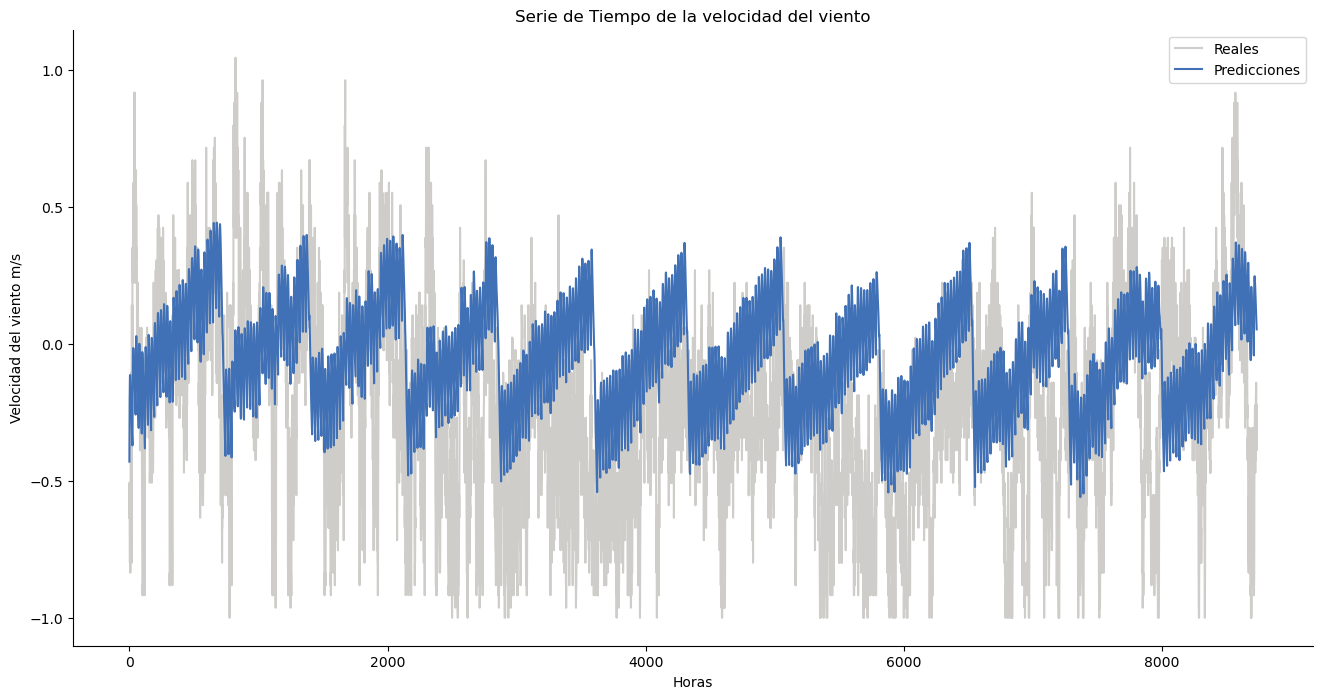

In [55]:
plot_series(y_ts_s.flatten(), pred.flatten())

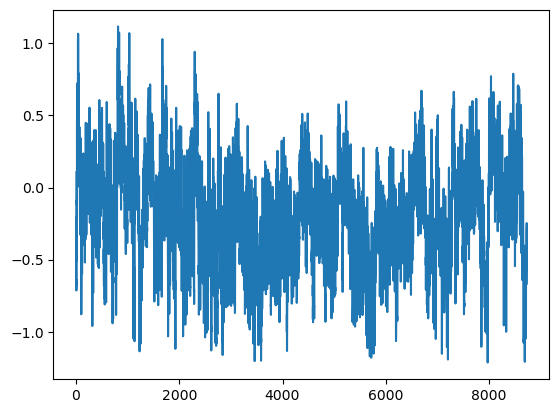

In [57]:
n = len(pred.flatten())
dato = np.linspace(1, n, n)

err = y_ts_s.flatten() - pred.flatten()
plt.plot(err)

### Evaluacion lstm_24_1

In [21]:
print(list_rect[0])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 24, 1)


In [22]:
# Dataset Entrenamiento
comb = list_rect[0]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17386, 24, 4), y_tr: (17386, 1, 1)
Set de prueba - x_ts: (8735, 24, 4), y_ts: (8735, 1, 1)
4


In [23]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [24]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.3
LR = 0.01

# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [25]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

272/272 - 4s - loss: 0.0860 - mae: 0.0676 - coeff_determination: 0.7623 - 4s/epoch - 16ms/step


In [116]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

273/273 [==============================] - 1s 2ms/step


C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\pandas\core\dtypes\cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


### Evaluacion lstm_48_1

In [117]:
print(list_rect[1])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 48, 1)


In [118]:
# Dataset Entrenamiento
comb = list_rect[1]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17362, 48, 4), y_tr: (17362, 1, 1)
Set de prueba - x_ts: (8711, 48, 4), y_ts: (8711, 1, 1)


In [ ]:
{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 1,
 'units_last': 64,
 'batch_size': 192,
 'units_layers_0': 32,
 'units_layers_1': 32,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [119]:
N_UNITS = 32
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.2
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [120]:
EPOCHS = 1
BATCH_SIZE = 192

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

91/91 - 2s - loss: 0.1682 - mae: 0.1306 - 2s/epoch - 17ms/step


In [121]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

273/273 [==============================] - 1s 2ms/step


### Evaluacion lstm_72_1

In [124]:
print(list_rect[2])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 72, 1)


In [125]:
# Dataset Entrenamiento
comb = list_rect[2]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17338, 72, 4), y_tr: (17338, 1, 1)
Set de prueba - x_ts: (8687, 72, 4), y_ts: (8687, 1, 1)


In [ ]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [126]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [127]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

271/271 - 3s - loss: 0.1570 - mae: 0.1218 - 3s/epoch - 10ms/step


In [128]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [0.2], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

272/272 [==============================] - 1s 2ms/step


### Evaluacion lstm_96_1

In [129]:
print(list_rect[3])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 1)


In [130]:
# Dataset Entrenamiento
comb = list_rect[3]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17314, 96, 4), y_tr: (17314, 1, 1)
Set de prueba - x_ts: (8663, 96, 4), y_ts: (8663, 1, 1)


In [ ]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [131]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [132]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

271/271 - 3s - loss: 0.1547 - mae: 0.1204 - 3s/epoch - 11ms/step


In [133]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

271/271 [==============================] - 1s 3ms/step


### Evaluacion lstm_24_1_v

In [26]:
print(list_rect[4])

(['High Wind Speed m/s'], 24, 1)


In [27]:
# Dataset Entrenamiento
comb = list_rect[4]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17386, 24, 1), y_tr: (17386, 1, 1)
Set de prueba - x_ts: (8735, 24, 1), y_ts: (8735, 1, 1)
1


In [28]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [29]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [30]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

272/272 - 2s - loss: 0.0862 - mae: 0.0679 - coeff_determination: 0.7669 - 2s/epoch - 7ms/step


In [138]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

273/273 [==============================] - 1s 2ms/step


### Evaluacion lstm_48_1_v

In [139]:
print(list_rect[5])

(['High Wind Speed m/s'], 48, 1)


In [31]:
# Dataset Entrenamiento
comb = list_rect[5]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17362, 48, 1), y_tr: (17362, 1, 1)
Set de prueba - x_ts: (8711, 48, 1), y_ts: (8711, 1, 1)
1


In [32]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 96,
 'units_layers_0': 32,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 96,
 'units_layers_0': 32,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [33]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.4
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [34]:
EPOCHS = 1
BATCH_SIZE = 96

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

181/181 - 2s - loss: 0.0916 - mae: 0.0720 - coeff_determination: 0.7355 - 2s/epoch - 10ms/step


In [143]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

273/273 [==============================] - 1s 2ms/step


### Evaluacion lstm_72_1_v

In [35]:
print(list_rect[6])

(['High Wind Speed m/s'], 72, 1)


In [36]:
# Dataset Entrenamiento
comb = list_rect[6]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17338, 72, 1), y_tr: (17338, 1, 1)
Set de prueba - x_ts: (8687, 72, 1), y_ts: (8687, 1, 1)
1


In [37]:
{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 224,
 'units_layers_0': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 224,
 'units_layers_0': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [38]:
N_UNITS = 64
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [39]:
EPOCHS = 1
BATCH_SIZE = 224

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

78/78 - 2s - loss: 0.0910 - mae: 0.0715 - coeff_determination: 0.7331 - 2s/epoch - 21ms/step


In [148]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

272/272 [==============================] - 1s 2ms/step


### Evaluacion lstm_96_1_v

In [40]:
print(list_rect[7])

(['High Wind Speed m/s'], 96, 1)


In [41]:
# Dataset Entrenamiento
comb = list_rect[7]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17314, 96, 1), y_tr: (17314, 1, 1)
Set de prueba - x_ts: (8663, 96, 1), y_ts: (8663, 1, 1)
1


In [42]:
{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 96,
 'units_layers_0': 32,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 96,
 'units_layers_0': 32,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [43]:
N_UNITS = 32
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.4
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [44]:
EPOCHS = 1
BATCH_SIZE = 96

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

181/181 - 2s - loss: 0.0920 - mae: 0.0726 - coeff_determination: 0.7338 - 2s/epoch - 12ms/step


In [153]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test.loc[len(df_LSTM_test.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

271/271 [==============================] - 1s 3ms/step


In [154]:
df_LSTM_test

Modelo  Horizon        R2      RMSE       MAE  \
0   LSTM        1  0.838347  0.142834  0.111207   
1   LSTM        1  0.826241  0.148134  0.115884   
2   LSTM        1  0.835218  0.143716  0.113042   
3   LSTM        1  0.832377  0.145138  0.115008   
4   LSTM        1  0.835664  0.144261  0.112378   
5   LSTM        1  0.821298  0.150172  0.116609   
6   LSTM        1  0.820003  0.150669  0.120821   
7   LSTM        1  0.830470  0.146233  0.116205   

                                               Comb  \
0  ([Month, Day, Hour, High Wind Speed m/s], 24, 1)   
1  ([Month, Day, Hour, High Wind Speed m/s], 48, 1)   
2  ([Month, Day, Hour, High Wind Speed m/s], 72, 1)   
3  ([Month, Day, Hour, High Wind Speed m/s], 96, 1)   
4                    ([High Wind Speed m/s], 24, 1)   
5                    ([High Wind Speed m/s], 48, 1)   
6                    ([High Wind Speed m/s], 72, 1)   
7                    ([High Wind Speed m/s], 96, 1)   

                                              Params  
0  {'units': [48], 'activation': ['tanh'], 'optim...  
1  {'units': [32], 'activation': ['tanh'], 'optim...  
2  {'units': [48], 'activation': ['tanh'], 'optim...  
3  {'units': [48], 'activation': ['tanh'], 'optim...  
4  {'units': [48], 'activation': ['tanh'], 'optim...  
5  {'units': [48], 'activation': ['tanh'], 'optim...  
6  {'units': [64], 'activation': ['tanh'], 'optim...  
7  {'units': [32], 'activation': ['tanh'], 'optim...

In [155]:
df_LSTM_test.to_csv(r'C:\Users\Angel\Documents\Tesis\Notebooks\Resultados\LSTM_test_Rec.csv')

### Evaluacion lstm_24_24

In [45]:
print(list_mimo[0])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 24, 24)


In [46]:
# Dataset Entrenamiento
comb = list_mimo[0]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17363, 24, 4), y_tr: (17363, 24, 1)
Set de prueba - x_ts: (8712, 24, 4), y_ts: (8712, 24, 1)
4


In [47]:
{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 1,
 'units_last': 64,
 'batch_size': 192,
 'units_layers_0': 32,
 'units_layers_1': 32,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 32,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 1,
 'units_last': 64,
 'batch_size': 192,
 'units_layers_0': 32,
 'units_layers_1': 32,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [48]:
N_UNITS = 32
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.2
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [49]:
EPOCHS = 1
BATCH_SIZE = 192

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

91/91 - 1s - loss: 0.1566 - mae: 0.1220 - coeff_determination: 0.2671 - 1s/epoch - 15ms/step


In [295]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

#resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

273/273 [==============================] - 1s 1ms/step


C:\Users\Angel\anaconda3\envs\Tesis_Env\lib\site-packages\pandas\core\dtypes\cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


### Evaluacion lstm_48_24

In [50]:
print(list_mimo[1])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 48, 24)


In [51]:
# Dataset Entrenamiento
comb = list_mimo[1]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17339, 48, 4), y_tr: (17339, 24, 1)
Set de prueba - x_ts: (8688, 48, 4), y_ts: (8688, 24, 1)
4


In [52]:
{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 224,
 'units_layers_0': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 32,
 'batch_size': 224,
 'units_layers_0': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [53]:
N_UNITS = 64
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [54]:
EPOCHS = 1
BATCH_SIZE = 224

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

78/78 - 2s - loss: 0.1568 - mae: 0.1223 - coeff_determination: 0.2686 - 2s/epoch - 19ms/step


In [300]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

272/272 [==============================] - 1s 2ms/step


### Evaluacion lstm_72_24

In [55]:
print(list_mimo[2])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 72, 24)


In [56]:
# Dataset Entrenamiento
comb = list_mimo[2]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17315, 72, 4), y_tr: (17315, 24, 1)
Set de prueba - x_ts: (8664, 72, 4), y_ts: (8664, 24, 1)
4


In [57]:
{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.2,
 'learning_rate': 0.001,
 'layers': 1,
 'units_last': 64,
 'batch_size': 96,
 'units_layers_0': 48,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 64,
 'dropout': 0.2,
 'learning_rate': 0.001,
 'layers': 1,
 'units_last': 64,
 'batch_size': 96,
 'units_layers_0': 48,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [58]:
N_UNITS = 64
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.2
LR = 0.001
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [59]:
EPOCHS = 1
BATCH_SIZE = 96

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

181/181 - 2s - loss: 0.1743 - mae: 0.1378 - coeff_determination: 0.0950 - 2s/epoch - 12ms/step


In [305]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

271/271 [==============================] - 1s 2ms/step


### Evaluacion lstm_96_24

In [60]:
print(list_mimo[3])

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 24)


In [61]:
# Dataset Entrenamiento
comb = list_mimo[3]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17291, 96, 4), y_tr: (17291, 24, 1)
Set de prueba - x_ts: (8640, 96, 4), y_ts: (8640, 24, 1)
4


In [62]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 2,
 'units_last': 48,
 'batch_size': 256,
 'units_layers_0': 16,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.4,
 'learning_rate': 0.01,
 'layers': 2,
 'units_last': 48,
 'batch_size': 256,
 'units_layers_0': 16,
 'units_layers_1': 64,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [63]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.4
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [64]:
EPOCHS = 1
BATCH_SIZE = 256

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

68/68 - 2s - loss: 0.1658 - mae: 0.1301 - coeff_determination: 0.1791 - 2s/epoch - 24ms/step


In [311]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

270/270 [==============================] - 1s 3ms/step


### Evaluacion lstm_24_24_v

In [65]:
print(list_mimo[4])

(['High Wind Speed m/s'], 24, 24)


In [66]:
# Dataset Entrenamiento
comb = list_mimo[4]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17363, 24, 1), y_tr: (17363, 24, 1)
Set de prueba - x_ts: (8712, 24, 1), y_ts: (8712, 24, 1)
1


In [67]:
{'activation': 'tanh',
 'stacked': True,
 'units': 16,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 2,
 'units_last': 16,
 'batch_size': 96,
 'units_layers_0': 48,
 'units_layers_1': 48,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': True,
 'units': 16,
 'dropout': 0.2,
 'learning_rate': 0.01,
 'layers': 2,
 'units_last': 16,
 'batch_size': 96,
 'units_layers_0': 48,
 'units_layers_1': 48,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [68]:
N_UNITS = 16
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.2
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, return_sequences=True, activation = 'tanh'))
model.add(LSTM(48, return_sequences=True, activation = 'tanh'))
model.add(LSTM(48, return_sequences=True, activation = 'tanh'))
model.add(LSTM(16,  activation = 'tanh'))

model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [69]:
EPOCHS = 1
BATCH_SIZE = 96

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

181/181 - 5s - loss: 0.1531 - mae: 0.1189 - coeff_determination: 0.3140 - 5s/epoch - 27ms/step


In [316]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
neuronas = [N_UNITS, 48, 48, 16]
params = {'units': [neuronas], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [4], 'batch_size': [BATCH_SIZE]}

#resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

273/273 [==============================] - 2s 4ms/step


### Evaluacion lstm_48_24_v

In [70]:
print(list_mimo[5])

(['High Wind Speed m/s'], 48, 24)


In [71]:
# Dataset Entrenamiento
comb = list_mimo[5]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17339, 48, 1), y_tr: (17339, 24, 1)
Set de prueba - x_ts: (8688, 48, 1), y_ts: (8688, 24, 1)
1


In [72]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [73]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [74]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

271/271 - 2s - loss: 0.1441 - mae: 0.1108 - coeff_determination: 0.3961 - 2s/epoch - 8ms/step


In [321]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS

params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

#resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

272/272 [==============================] - 1s 2ms/step


### Evaluacion lstm_72_24_v

In [75]:
print(list_mimo[6])

(['High Wind Speed m/s'], 72, 24)


In [76]:
# Dataset Entrenamiento
comb = list_mimo[6]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17315, 72, 1), y_tr: (17315, 24, 1)
Set de prueba - x_ts: (8664, 72, 1), y_ts: (8664, 24, 1)
1


In [77]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [78]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [79]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

271/271 - 2s - loss: 0.1424 - mae: 0.1095 - coeff_determination: 0.4179 - 2s/epoch - 9ms/step


In [326]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

#resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

271/271 [==============================] - 1s 2ms/step


### Evaluacion lstm_96_24_v

In [80]:
print(list_mimo[7])

(['High Wind Speed m/s'], 96, 24)


In [81]:
# Dataset Entrenamiento
comb = list_mimo[7]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17291, 96, 1), y_tr: (17291, 24, 1)
Set de prueba - x_ts: (8640, 96, 1), y_ts: (8640, 24, 1)
1


In [82]:
{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

{'activation': 'tanh',
 'stacked': False,
 'units': 48,
 'dropout': 0.30000000000000004,
 'learning_rate': 0.01,
 'layers': 0,
 'units_last': 64,
 'batch_size': 64,
 'units_layers_0': 16,
 'units_layers_1': 16,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [83]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae', coeff_determination])

In [84]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

271/271 - 3s - loss: 0.1436 - mae: 0.1108 - coeff_determination: 0.4032 - 3s/epoch - 10ms/step


In [331]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [LR], 'dropout': [DROPOUT], 'layers': [1], 'batch_size': [BATCH_SIZE]}

#resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
#print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

df_LSTM_test_MIMO.loc[len(df_LSTM_test_MIMO.index)] = ['LSTM', comb[2], r2, rmse_score, mae_score, comb, params]

270/270 [==============================] - 1s 3ms/step


In [332]:
df_LSTM_test_MIMO

Modelo  Horizon        R2      RMSE       MAE  \
0   LSTM       24  0.494899  0.245714  0.199622   
1   LSTM       24  0.487022  0.247253  0.199574   
2   LSTM       24  0.454847  0.252526  0.207405   
3   LSTM       24  0.502906  0.242169  0.197227   
4   LSTM       24  0.467562  0.251511  0.204840   
5   LSTM       24  0.493485  0.245595  0.198560   
6   LSTM       24  0.488050  0.245976  0.198889   
7   LSTM       24  0.487465  0.245444  0.199327   

                                                Comb  \
0  ([Month, Day, Hour, High Wind Speed m/s], 24, 24)   
1  ([Month, Day, Hour, High Wind Speed m/s], 48, 24)   
2  ([Month, Day, Hour, High Wind Speed m/s], 72, 24)   
3  ([Month, Day, Hour, High Wind Speed m/s], 96, 24)   
4                    ([High Wind Speed m/s], 24, 24)   
5                    ([High Wind Speed m/s], 48, 24)   
6                    ([High Wind Speed m/s], 72, 24)   
7                    ([High Wind Speed m/s], 96, 24)   

                                              Params  
0  {'units': [32], 'activation': ['tanh'], 'optim...  
1  {'units': [64], 'activation': ['tanh'], 'optim...  
2  {'units': [64], 'activation': ['tanh'], 'optim...  
3  {'units': [48], 'activation': ['tanh'], 'optim...  
4  {'units': [[16, 48, 48, 16]], 'activation': ['...  
5  {'units': [48], 'activation': ['tanh'], 'optim...  
6  {'units': [48], 'activation': ['tanh'], 'optim...  
7  {'units': [48], 'activation': ['tanh'], 'optim...

In [333]:
df_LSTM_test_MIMO.to_csv(r'C:\Users\Angel\Documents\Tesis\Notebooks\Resultados\LSTM_test_MIMO.csv')

### Evaluacion modelo 24_1_v

In [136]:
print(list_rect[4])

(['High Wind Speed m/s'], 24, 1)


In [14]:
# Dataset Entrenamiento
comb = list_rect[4]
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

xtr, ytr = crear_dataset_supervisado(df_train.values, input_length = comb[1], output_length = comb[2])

# Dataset Prueba
df_test = df_Prueba.copy()
drop_cols = [col for col in df_Prueba.columns if col not in comb[0]]
df_test.drop(drop_cols, axis = 1, inplace = True)

xts, yts = crear_dataset_supervisado(df_test.values, input_length = comb[1], output_length = comb[2])


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


data_in = {
    'xtr': xtr, 'ytr': ytr,
    'xts': xts, 'yts': yts,
}

data_s, scaler = escalar_dataset(data_in, test = True)

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17386, 24, 1), y_tr: (17386, 1, 1)
Set de prueba - x_ts: (8735, 24, 1), y_ts: (8735, 1, 1)


In [84]:
x_ts_s.shape

(8735, 24, 1)

In [85]:
y_ts_s.shape

(8735, 1, 1)

In [15]:
INPUT_SHAPE = (x_ts_s.shape[1], x_ts_s.shape[2])
OUTPUT_SHAPE = y_ts_s.shape[1]
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

(24, 1)
1


In [87]:
lstm_24_1_v2.evaluate(x=x_ts_s, y=y_ts_s)

273/273 [==============================] - 1s 3ms/step - loss: 0.3739 - mae: 0.3289


[0.37385207414627075, 0.32890281081199646]

In [88]:
pred = lstm_24_1_v2.predict(x_ts_s)

273/273 [==============================] - 0s 2ms/step


In [89]:
pred.flatten()

array([-0.0571058 , -0.0558328 , -0.05275824, ..., -0.05077022,
       -0.0534479 , -0.05574133], dtype=float32)

In [90]:
y_ts_s.flatten()

array([-0.6347032 , -0.50684932, -0.67123288, ..., -0.30593607,
       -0.38812785, -0.22374429])

In [239]:
# Graficando la regresion lineal dentro de la serie de tiempo del viento
def plot_series(Y_true, Y_pred, title = 'Serie de Tiempo de la velocidad del viento', vline = False):
    gris_uat = '#CFCDC9' #(207, 205, 201)
    azul_uat = '#4070B6' #(0, 66, 106)
    naranja_uat = '#ECB06F' #(184, 97, 106)
    #gris_uat_a = '#CFCDC9' #(207, 205, 201)
    
    
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(Y_true, color = gris_uat, label = 'Reales')
    ax.plot(Y_pred, color = azul_uat, label = 'Predicciones')
    
    if(vline == True):
        # only one line may be specified; full height
        plt.axvline(x = len(Y_true) - 25, color = naranja_uat, ls = '--')
    
    ax.set_title(title);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylabel('Velocidad del viento m/s')
    plt.xlabel('Horas')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    #plt.legend(loc='upper right')

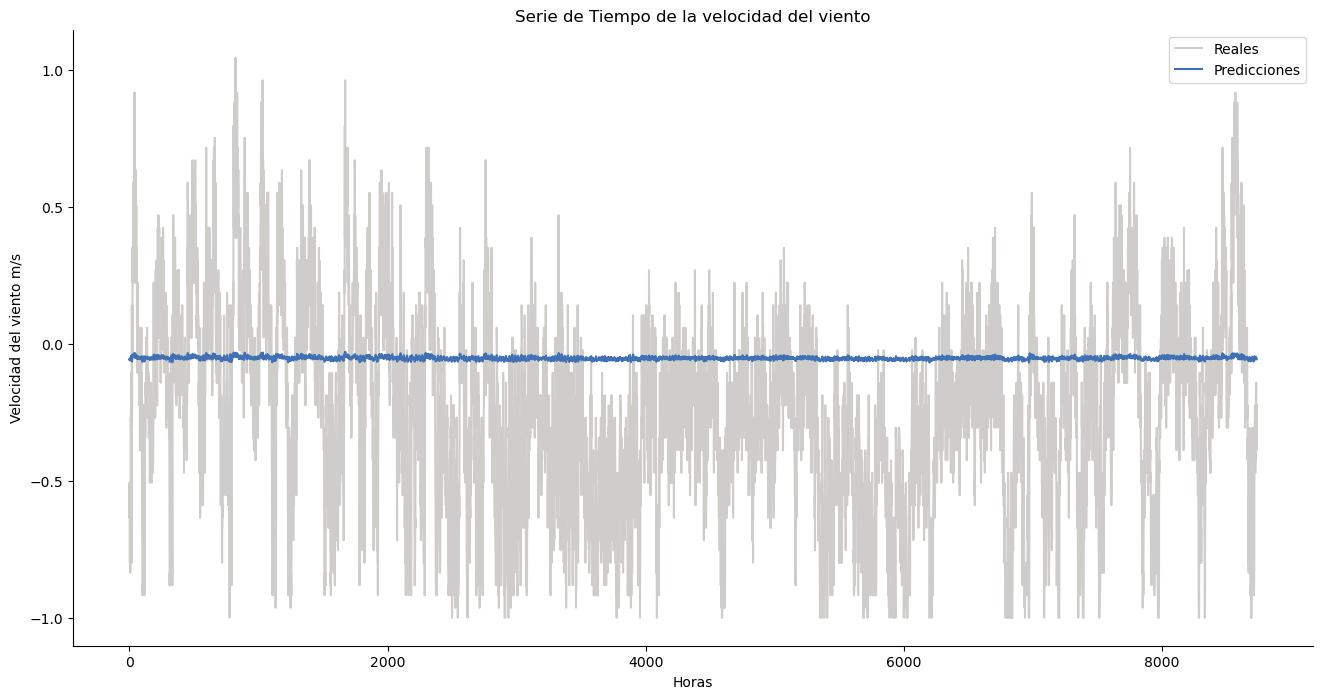

In [92]:
plot_series(y_ts_s.flatten(), pred.flatten())

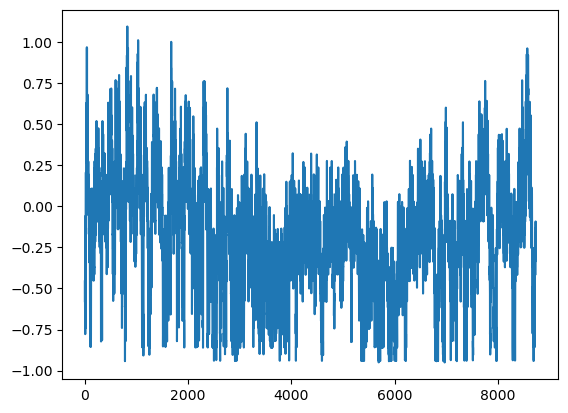

In [73]:
n = len(pred.flatten())
dato = np.linspace(1, n, n)

err = y_ts_s.flatten() - pred.flatten()
plt.plot(err)

In [16]:
N_UNITS = 48
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
OUTPUT_LENGTH = 1

# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(0.3))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(0.01)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [18]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

272/272 - 6s - loss: 0.1546 - mae: 0.1201 - 6s/epoch - 21ms/step


In [45]:
rmse_score, mae_score = model.evaluate(x=x_ts_s, y=y_ts_s)
pred = model.predict(x_ts_s)
r2 = r2_score(y_ts_s.flatten(), pred.flatten())

# LAS UNIDADES POR CAPA ESTARAN SEPARADAS POR COMAS
params = {'units': [48], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [0.3], 'layers': [1], 'batch_size': [64]}

resLSTM = {'Modelo': [], 'Horizon': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Comb': [], 'Params': []}
print('LSTM' + str(comb[2]) + ' rmse: ' + str(rmse_score) + ' mae: ' + str(mae_score) + ' r2: ' + str(r2) + ' ' + str(comb) + ' ' + str(params))

273/273 [==============================] - 0s 2ms/step
LSTM1 rmse: 0.1449829638004303 mae: 0.11293807625770569 r2: 0.834069738791716 (['High Wind Speed m/s'], 24, 1) {'units': [48], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [0.3], 'layers': [1], 'batch_size': [64]}


In [142]:
pred.flatten()

array([-0.5886491 , -0.571581  , -0.4758041 , ..., -0.20628749,
       -0.2786821 , -0.3564756 ], dtype=float32)

In [143]:
y_ts_s.flatten()

array([-0.6347032 , -0.50684932, -0.67123288, ..., -0.30593607,
       -0.38812785, -0.22374429])

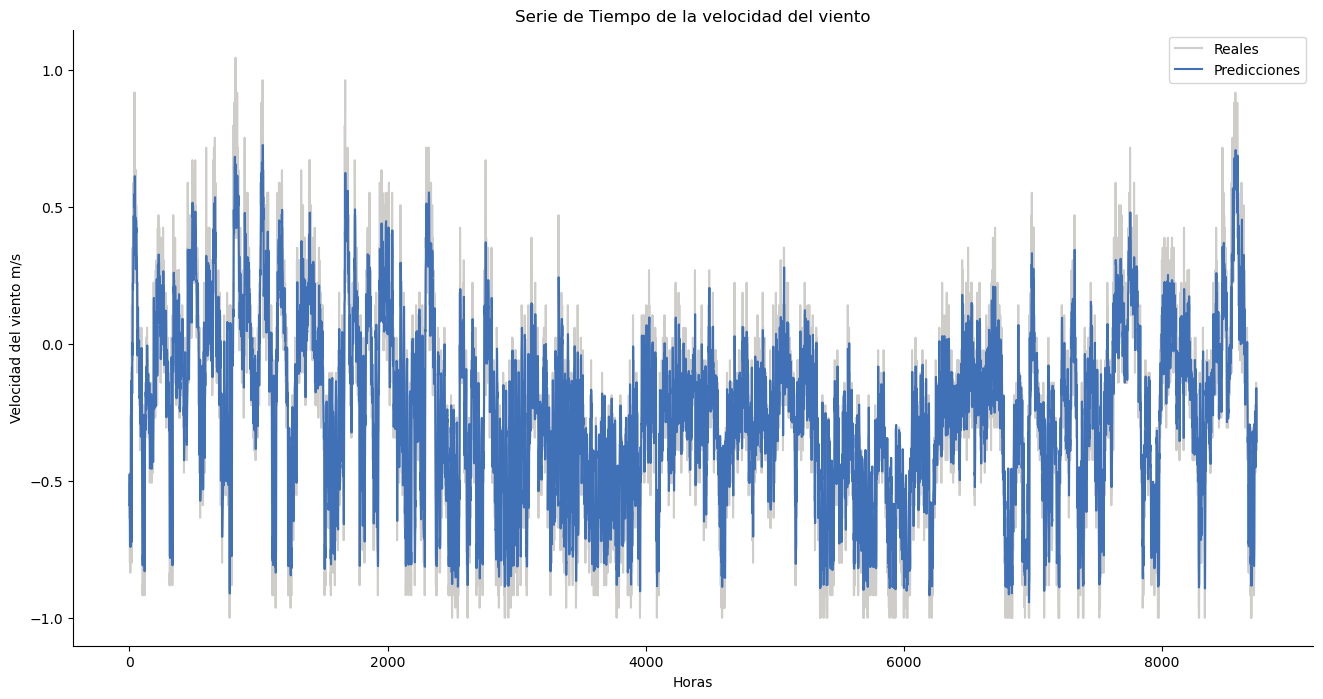

In [144]:
plot_series(y_ts_s.flatten(), pred.flatten())

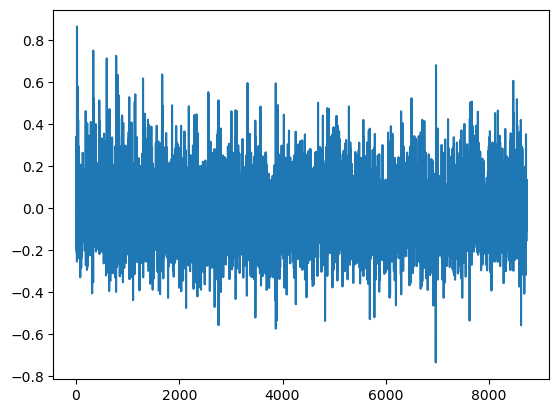

In [145]:
n = len(pred.flatten())
dato = np.linspace(1, n, n)

err = y_ts_s.flatten() - pred.flatten()
plt.plot(err)

In [146]:
y_ts_s[4]

array([[-0.79908676]])

In [147]:
x_ts_s.shape

(8735, 24, 1)

In [148]:
x_ts_s[4].shape

(24, 1)

In [168]:
x_input = x_ts_s[4].flatten()
x_input = x_input.reshape(1, 24, 1)

In [169]:
x_input

array([[[-0.5890411 ],
        [-0.75342466],
        [-0.83561644],
        [-0.83561644],
        [-0.5890411 ],
        [-0.47031963],
        [-0.50684932],
        [-0.30593607],
        [-0.22374429],
        [-0.14155251],
        [-0.18721461],
        [-0.10502283],
        [-0.30593607],
        [-0.30593607],
        [-0.47031963],
        [-0.67123288],
        [-0.79908676],
        [-0.75342466],
        [-0.6347032 ],
        [-0.67123288],
        [-0.6347032 ],
        [-0.50684932],
        [-0.67123288],
        [-0.75342466]]])

In [225]:
ls = []
for i in range(10):
    x_input = x_ts_s[i].flatten()
    x_input = x_input.reshape(1, 24, 1)
    q = model.predict(x_input)
    ls.append(q.item(0))

1/1 [==============================] - 0s 22ms/step


In [226]:
ls

[-0.5886490941047668,
 -0.5715810656547546,
 -0.47580409049987793,
 -0.5866522789001465,
 -0.6807745695114136,
 -0.7268819212913513,
 -0.6850396990776062,
 -0.6739322543144226,
 -0.7414575815200806,
 -0.7202208042144775]

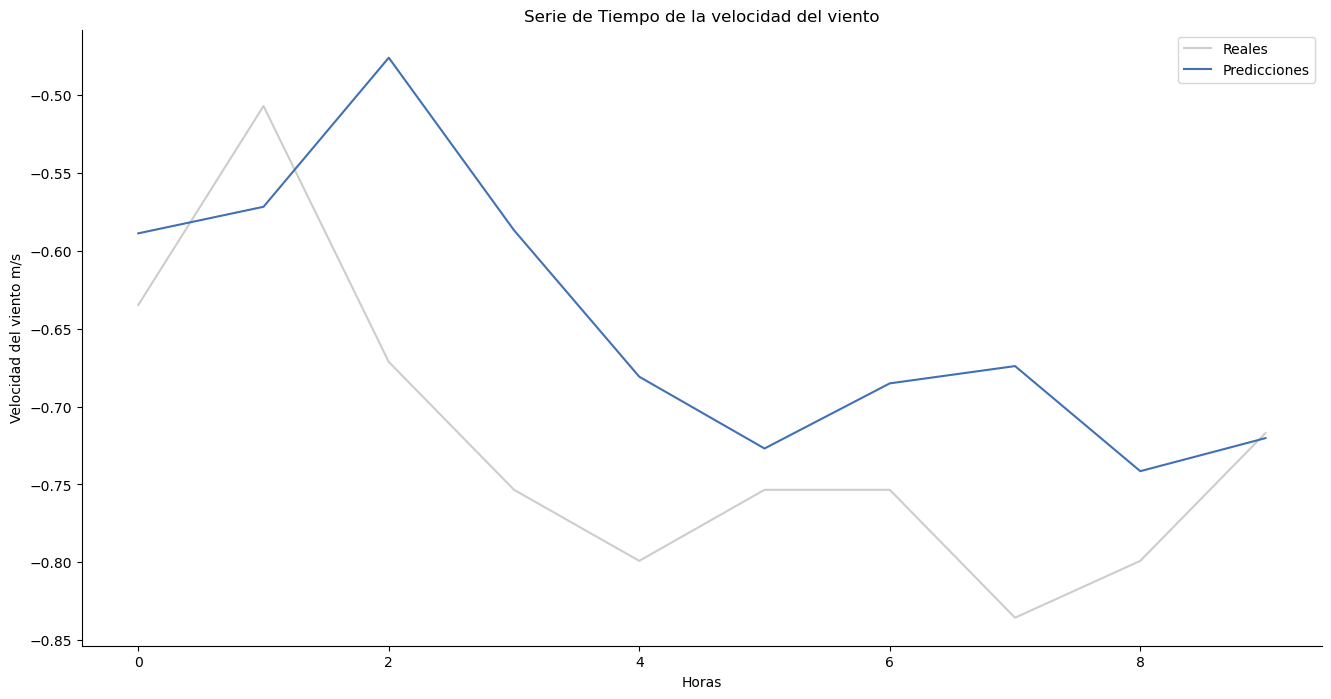

In [228]:
plot_series(y_ts_s[0:10].flatten(), ls)

## Simulacion pruebas

In [19]:
def previous_date(current_date, frmt='%Y-%m-%d-%H', days = 1, string=True):
    yesterday = current_date - timedelta(days)
    if string:
        return yesterday.strftime(frmt), current_date.strftime(frmt)
    return yesterday

In [20]:
def get_dates(data, month, day, d = 1):
    current_date = datetime(2022, month, day)
    
    prev, current = previous_date(current_date, days = d + 1, string = True)
    month = data[(data['Date'] > prev) & (data['Date'] < current)]
    
    previous_days = month.iloc[:-24]
    current_day = month.iloc[len(previous_days):]
    
    return month, previous_days, current_day

In [21]:
P_Enero = df_Prueba[df_Prueba['Month'] == 1]
P_Febrero = df_Prueba[df_Prueba['Month'] == 2]
P_Marzo = df_Prueba[df_Prueba['Month'] == 3]
P_Abril = df_Prueba[df_Prueba['Month'] == 4]
P_Mayo = df_Prueba[df_Prueba['Month'] == 5]
P_Junio = df_Prueba[df_Prueba['Month'] == 6]
P_Julio = df_Prueba[df_Prueba['Month'] == 7]
P_Agosto = df_Prueba[df_Prueba['Month'] == 8]
P_Septiembre = df_Prueba[df_Prueba['Month'] == 9]
P_Octubre = df_Prueba[df_Prueba['Month'] == 10]
P_Noviembre = df_Prueba[df_Prueba['Month'] == 11]
P_Diciembre = df_Prueba[df_Prueba['Month'] == 12]

Meses = {
    'Enero': P_Enero, 'Febrero': P_Febrero,
    'Marzo': P_Marzo, 'Abril': P_Abril,
    'Mayo': P_Mayo, 'Junio': P_Junio,
    'Julio': P_Julio, 'Agosto': P_Agosto, 
    'Septiembre': P_Septiembre, 'Octubre': P_Octubre, 
    'Novimebre': P_Noviembre, 'Diciembre': P_Diciembre
    }
keys = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Novimebre', 'Diciembre']

### Simulacion MIMO

In [22]:
# Dataset Entrenamiento
comb = list_mimo[3]
print(comb)
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

minmax = MinMaxScaler(feature_range=(0,1))
df_train = minmax.fit_transform(df_train)

xtr, ytr = crear_dataset_supervisado(df_train, input_length = comb[1], output_length = comb[2])

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
#print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')

(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 24)
Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17291, 96, 4), y_tr: (17291, 24, 1)


In [23]:
N_UNITS = 48
INPUT_SHAPE = (xtr.shape[1], xtr.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.4
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [24]:
EPOCHS = 1
BATCH_SIZE = 256

history = model.fit(
    x = xtr,
    y = ytr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

68/68 - 4s - loss: 0.1632 - mae: 0.1279 - 4s/epoch - 58ms/step


In [25]:
### Exportacion del modelo y escalador
model_filename = 'model_LSTM.pkl'
pickle.dump(model, open(model_filename, 'wb'))

scaler_filename = 'scaler_LSTM.pkl'
pickle.dump(minmax, open(scaler_filename, 'wb'))

INFO:tensorflow:Assets written to: ram://a74eeefb-f44a-4877-824b-b3a0e20fc6e4/assets


INFO:tensorflow:Assets written to: ram://a74eeefb-f44a-4877-824b-b3a0e20fc6e4/assets


In [27]:
model.save('model_LSTM.h5') 

TypeError: Model.save() got an unexpected keyword argument 'custom_objects'

In [32]:
def recursive_forecast(modelo, Ventana, Iters = 1, Rolling = False):
    # Realizar el metodo de prediccion recursiva
    # parametros a utilizar: 
    # Ventana: La lista con el numero de entradas para realizar la prediccion
    # Preds: La lista del resultado de las n predicciones hechas
    # Iters: Numero de las iteraciones a realizar
    # Rolling: (True, False) Si Rolling es verdadero, mover la lista ventana, si es falso, no mover la ventana 
    Preds = [] # Lista con los resultados de las predicciones
    for i in range(Iters):
        w = Ventana[:, i:, :]
        #print(w)
        pred = modelo.predict(w, verbose=0)
        #print('-----')
        #print(pred)
        Ventana = np.append(Ventana, pred)
        Ventana = Ventana.reshape(1, -1, 1)
        #print('******')
        #print(Ventana)
        Preds.append(pred.item())
    return Ventana, Preds

In [30]:
def sim(comb, Month, Day, model, minmax):
    h = int(comb[1] / 24)
    #print(Month)
    month, p, c = get_dates(df_Prueba, Month, Day, d = h)
        #m, p, c, pred = simulation_v2(combi, (i + 1), j, Model, minmax_scl)
    drop_cols = [col for col in p.columns if col not in comb[0]]
    p.drop(drop_cols, axis = 1, inplace = True)

    drop_cols = [col for col in c.columns if col not in comb[0]]
    c.drop(drop_cols, axis = 1, inplace = True)

    x_input = p.values
    x_input_s = minmax.transform(x_input)
    x_input_s = x_input_s.flatten()
    
    x_input_s = x_input_s.reshape(1, comb[1], len(comb[0]))

    c_ = minmax.transform(c.values)
    if comb[2] > 1:
        pred = model.predict(x_input_s, verbose=0)
    else:
        w, p = recursive_forecast(model, x_input_s, Iters=24)
        pred = np.asarray(p)

    return month, c_[:, -1], pred.flatten()

In [35]:
resLSTM = {'Mes': [], 'Dia': [], 'R2': [], 'RMSE': [], 'MAE': [], 'Modelo': [], 'Metodo': []}

# Transformacion de diccionario a Dataframe
df_LSTM_sim = pd.DataFrame(resLSTM)

In [66]:
import warnings
warnings.filterwarnings('ignore')

comb = list_mimo[3]
print(comb)

inicio = 0
if comb[1] == 24:
    inicio = 2
elif comb[1] == 48:
    inicio = 3
if comb[1] == 72:
    inicio = 4
elif comb[1] == 96:
    inicio = 5
#else:
    #inicio = -1

params = {'units': [48], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [0.4], 'layers': [1], 'batch_size': [256]}
    
for i, mes in enumerate(keys):
    df_mes = Meses[keys[i]]
    for j in range(inicio, len(df_mes['Day'].unique()) + 1):
        #Simulacion
        print(str(i + 1) + ' : ' + str(j))
        m, c, pred = sim(comb, (i + 1), j, model, minmax)
        # Metricas
        r2 = r2_score(c, pred)
        mae = mean_absolute_error(c, pred)
        rmse = mean_squared_error(c, pred, squared= False)
        
        #Insertandolos en el Dataframe
        df_LSTM_sim.loc[len(df_LSTM_sim.index)] = [mes, j, r2, rmse, mae, 'LSTM', 'MIMO']


(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 24)
1 : 5
1 : 6
1 : 7
1 : 8
1 : 9
1 : 10
1 : 11
1 : 12
1 : 13
1 : 14
1 : 15
1 : 16
1 : 17
1 : 18
1 : 19
1 : 20
1 : 21
1 : 22
1 : 23
1 : 24
1 : 25
1 : 26
1 : 27
1 : 28
1 : 29
1 : 30
1 : 31
2 : 5
2 : 6
2 : 7
2 : 8
2 : 9
2 : 10
2 : 11
2 : 12
2 : 13
2 : 14
2 : 15
2 : 16
2 : 17
2 : 18
2 : 19
2 : 20
2 : 21
2 : 22
2 : 23
2 : 24
2 : 25
2 : 26
2 : 27
2 : 28
3 : 5
3 : 6
3 : 7
3 : 8
3 : 9
3 : 10
3 : 11
3 : 12
3 : 13
3 : 14
3 : 15
3 : 16
3 : 17
3 : 18
3 : 19
3 : 20
3 : 21
3 : 22
3 : 23
3 : 24
3 : 25
3 : 26
3 : 27
3 : 28
3 : 29
3 : 30
3 : 31
4 : 5
4 : 6
4 : 7
4 : 8
4 : 9
4 : 10
4 : 11
4 : 12
4 : 13
4 : 14
4 : 15
4 : 16
4 : 17
4 : 18
4 : 19
4 : 20
4 : 21
4 : 22
4 : 23
4 : 24
4 : 25
4 : 26
4 : 27
4 : 28
4 : 29
4 : 30
5 : 5
5 : 6
5 : 7
5 : 8
5 : 9
5 : 10
5 : 11
5 : 12
5 : 13
5 : 14
5 : 15
5 : 16
5 : 17
5 : 18
5 : 19
5 : 20
5 : 21
5 : 22
5 : 23
5 : 24
5 : 25
5 : 26
5 : 27
5 : 28
5 : 29
5 : 30
5 : 31
6 : 5
6 : 6
6 : 7
6 : 8
6 : 9
6 : 10
6 : 11
6 : 12

In [67]:
df_LSTM_sim_MIMO = df_LSTM_sim[df_LSTM_sim['Metodo'] == 'MIMO']

In [68]:
sns.set(rc={'figure.figsize':(14,5)})

<Axes: xlabel='Mes', ylabel='R2'>

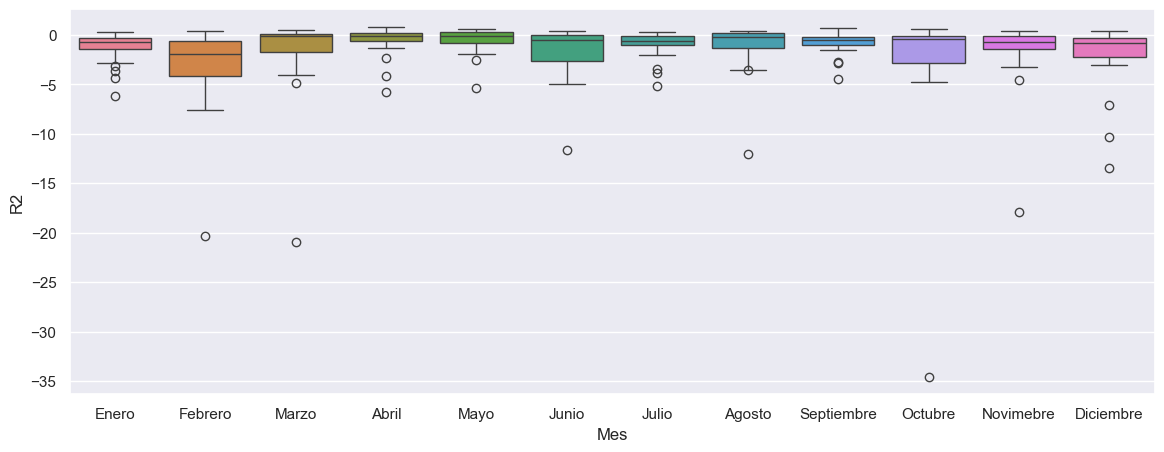

In [70]:
sns.boxplot(data = df_LSTM_sim_MIMO, x = 'Mes', y = 'R2', hue = 'Mes')

<Axes: xlabel='Mes', ylabel='RMSE'>

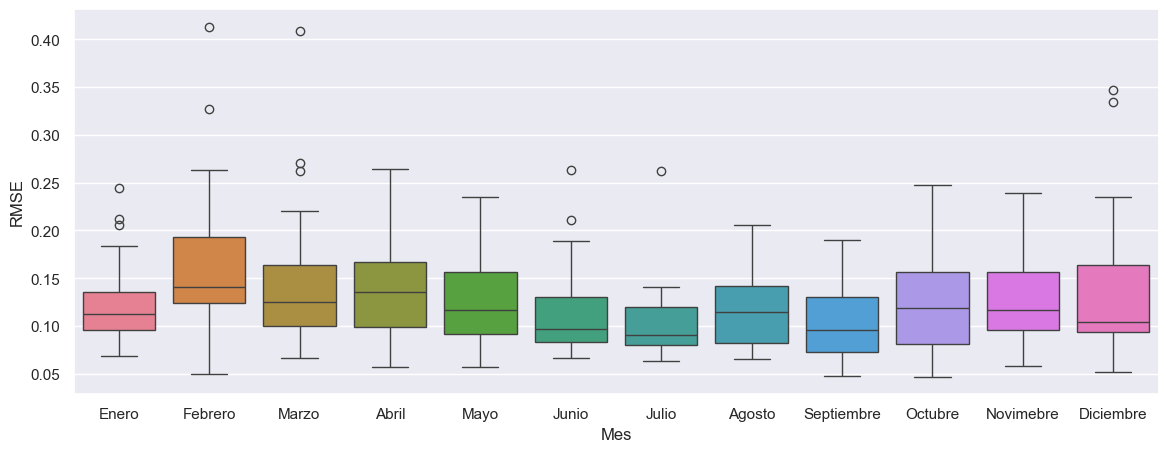

In [71]:
sns.boxplot(data = df_LSTM_sim_MIMO, x = 'Mes', y = 'RMSE', hue = 'Mes')

<Axes: xlabel='Mes', ylabel='MAE'>

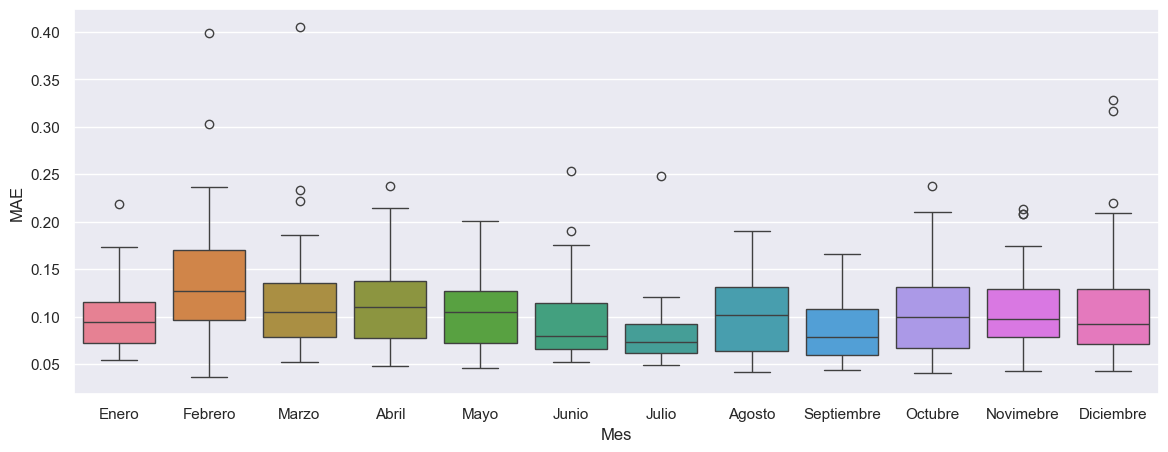

In [72]:
sns.boxplot(data = df_LSTM_sim_MIMO, x = 'Mes', y = 'MAE', hue = 'Mes')

In [73]:
df_LSTM_sim_MIMO

Mes  Dia        R2      RMSE       MAE Modelo Metodo
0        Enero    5 -1.403906  0.100524  0.073905   LSTM   MIMO
1        Enero    6 -4.343909  0.244133  0.218795   LSTM   MIMO
2        Enero    7 -3.619772  0.114326  0.101462   LSTM   MIMO
3        Enero    8 -0.816613  0.089961  0.075822   LSTM   MIMO
4        Enero    9 -3.132908  0.211473  0.173704   LSTM   MIMO
..         ...  ...       ...       ...       ...    ...    ...
312  Diciembre   27 -2.369479  0.181718  0.160821   LSTM   MIMO
313  Diciembre   28  0.090641  0.051467  0.042887   LSTM   MIMO
314  Diciembre   29  0.220919  0.093678  0.070883   LSTM   MIMO
315  Diciembre   30 -1.050615  0.175299  0.157644   LSTM   MIMO
316  Diciembre   31  0.336240  0.094214  0.087348   LSTM   MIMO

[317 rows x 7 columns]

In [74]:
df_LSTM_sim_MIMO_v2 = df_LSTM_sim_MIMO

In [75]:
df_LSTM_sim_MIMO_v2

Mes  Dia        R2      RMSE       MAE Modelo Metodo
0        Enero    5 -1.403906  0.100524  0.073905   LSTM   MIMO
1        Enero    6 -4.343909  0.244133  0.218795   LSTM   MIMO
2        Enero    7 -3.619772  0.114326  0.101462   LSTM   MIMO
3        Enero    8 -0.816613  0.089961  0.075822   LSTM   MIMO
4        Enero    9 -3.132908  0.211473  0.173704   LSTM   MIMO
..         ...  ...       ...       ...       ...    ...    ...
312  Diciembre   27 -2.369479  0.181718  0.160821   LSTM   MIMO
313  Diciembre   28  0.090641  0.051467  0.042887   LSTM   MIMO
314  Diciembre   29  0.220919  0.093678  0.070883   LSTM   MIMO
315  Diciembre   30 -1.050615  0.175299  0.157644   LSTM   MIMO
316  Diciembre   31  0.336240  0.094214  0.087348   LSTM   MIMO

[317 rows x 7 columns]

In [77]:
df_LSTM_sim_MIMO_v2.to_csv(r'C:\Users\Angel-PC\Documents\Tesis\Notebooks\Resultados\df_LSTM_sim_MIMO_v2.csv')

### Simulacion Recursivo

In [26]:
# Dataset Entrenamiento
comb = list_rect[4]
print(comb)
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

minmax = MinMaxScaler(feature_range=(-1,1))
df_train = minmax.fit_transform(df_train)

xtr, ytr = crear_dataset_supervisado(df_train, input_length = comb[1], output_length = comb[2])

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
#print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')

(['High Wind Speed m/s'], 24, 1)
Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17386, 24, 1), y_tr: (17386, 1, 1)


In [27]:
N_UNITS = 48
INPUT_SHAPE = (xtr.shape[1], xtr.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [28]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = xtr,
    y = ytr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

272/272 - 3s - loss: 0.1520 - mae: 0.1182 - 3s/epoch - 12ms/step


In [36]:
import warnings
warnings.filterwarnings('ignore')

comb = list_rect[4]
print(comb)

inicio = 0
if comb[1] == 24:
    inicio = 2
elif comb[1] == 48:
    inicio = 3
if comb[1] == 72:
    inicio = 4
elif comb[1] == 96:
    inicio = 5
#else:
    #inicio = -1

params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [0.3], 'layers': [1], 'batch_size': [64]}

    
for i, mes in enumerate(keys):
    df_mes = Meses[keys[i]]
    for j in range(inicio, len(df_mes['Day'].unique()) + 1):
        #Simulacion
        print(str(i + 1) + ' : ' + str(j))
        m, c, pred = sim(comb, (i + 1), j, model, minmax)
        # Metricas
        r2 = r2_score(c, pred)
        mae = mean_absolute_error(c, pred)
        rmse = mean_squared_error(c, pred, squared= False)
        
        #Insertandolos en el Dataframe
        df_LSTM_sim.loc[len(df_LSTM_sim.index)] = [mes, j, r2, rmse, mae, 'LSTM', 'REC']


(['High Wind Speed m/s'], 24, 1)
1 : 2
1 : 3
1 : 4
1 : 5
1 : 6
1 : 7
1 : 8
1 : 9
1 : 10
1 : 11
1 : 12
1 : 13
1 : 14
1 : 15
1 : 16
1 : 17
1 : 18
1 : 19
1 : 20
1 : 21
1 : 22
1 : 23
1 : 24
1 : 25
1 : 26
1 : 27
1 : 28
1 : 29
1 : 30
1 : 31
2 : 2
2 : 3
2 : 4
2 : 5
2 : 6
2 : 7
2 : 8
2 : 9
2 : 10
2 : 11
2 : 12
2 : 13
2 : 14
2 : 15
2 : 16
2 : 17
2 : 18
2 : 19
2 : 20
2 : 21
2 : 22
2 : 23
2 : 24
2 : 25
2 : 26
2 : 27
2 : 28
3 : 2
3 : 3
3 : 4
3 : 5
3 : 6
3 : 7
3 : 8
3 : 9
3 : 10
3 : 11
3 : 12
3 : 13
3 : 14
3 : 15
3 : 16
3 : 17
3 : 18
3 : 19
3 : 20
3 : 21
3 : 22
3 : 23
3 : 24
3 : 25
3 : 26
3 : 27
3 : 28
3 : 29
3 : 30
3 : 31
4 : 2
4 : 3
4 : 4
4 : 5
4 : 6
4 : 7
4 : 8
4 : 9
4 : 10
4 : 11
4 : 12
4 : 13
4 : 14
4 : 15
4 : 16
4 : 17
4 : 18
4 : 19
4 : 20
4 : 21
4 : 22
4 : 23
4 : 24
4 : 25
4 : 26
4 : 27
4 : 28
4 : 29
4 : 30
5 : 2
5 : 3
5 : 4
5 : 5
5 : 6
5 : 7
5 : 8
5 : 9
5 : 10
5 : 11
5 : 12
5 : 13
5 : 14
5 : 15
5 : 16
5 : 17
5 : 18
5 : 19
5 : 20
5 : 21
5 : 22
5 : 23
5 : 24
5 : 25
5 : 26
5 : 27
5 : 28
5 : 29

In [37]:
df_LSTM_sim_REC = df_LSTM_sim[df_LSTM_sim['Metodo'] == 'REC']

In [38]:
sns.set(rc={'figure.figsize':(14,5)})

<Axes: xlabel='Mes', ylabel='R2'>

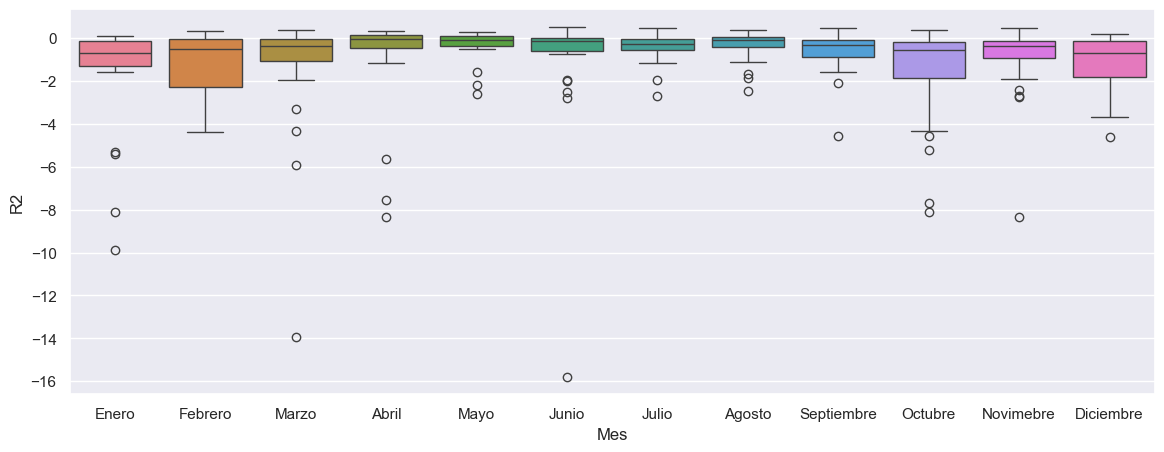

In [40]:
sns.boxplot(data = df_LSTM_sim_REC, x = 'Mes', y = 'R2', hue = 'Mes')

<Axes: xlabel='Mes', ylabel='RMSE'>

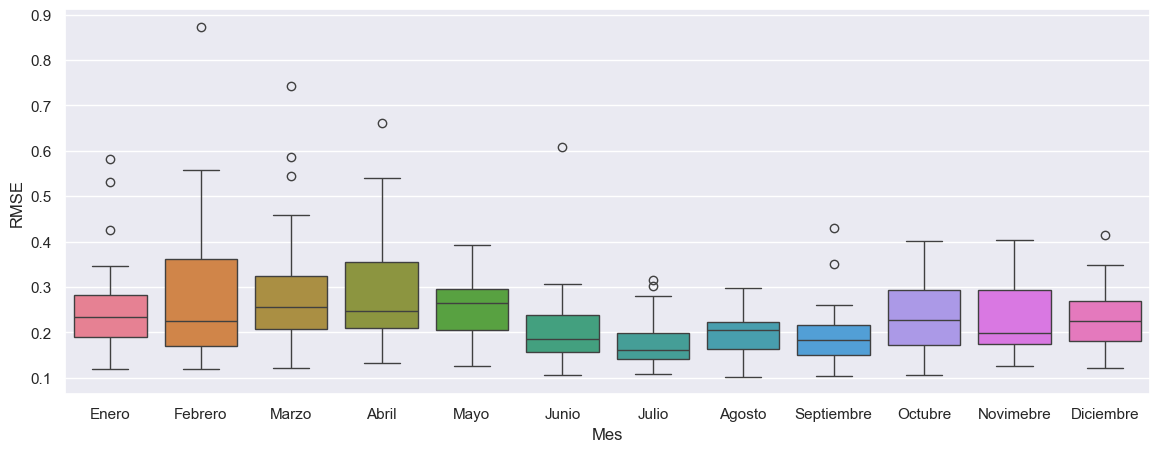

In [41]:
sns.boxplot(data = df_LSTM_sim_REC, x = 'Mes', y = 'RMSE', hue = 'Mes')

<Axes: xlabel='Mes', ylabel='MAE'>

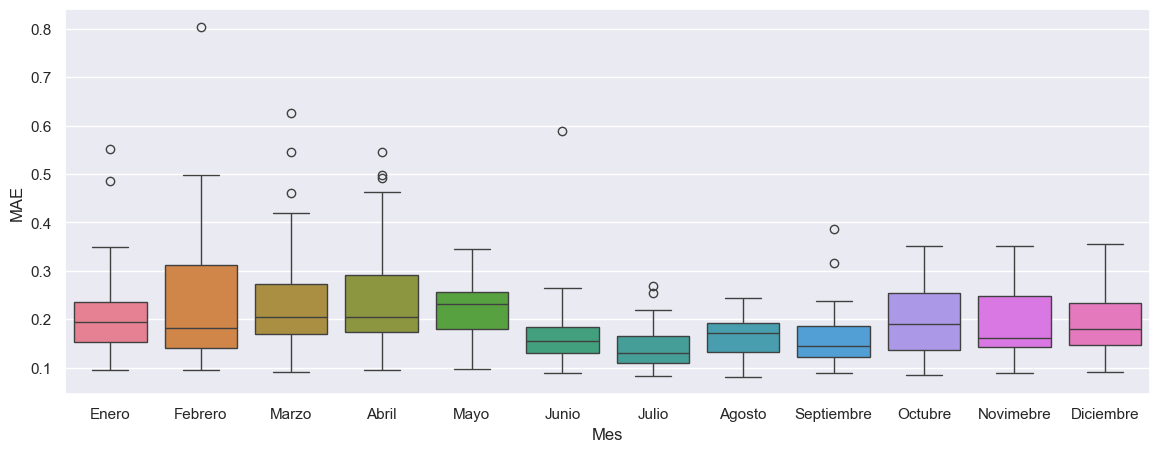

In [42]:
sns.boxplot(data = df_LSTM_sim_REC, x = 'Mes', y = 'MAE', hue = 'Mes')

In [43]:
df_LSTM_sim_REC

Mes  Dia        R2      RMSE       MAE Modelo Metodo
0        Enero    2  0.108772  0.289341  0.245969   LSTM    REC
1        Enero    3 -9.897893  0.582269  0.552062   LSTM    REC
2        Enero    4 -0.437230  0.242001  0.198231   LSTM    REC
3        Enero    5 -1.471255  0.203845  0.176220   LSTM    REC
4        Enero    6 -5.299937  0.530144  0.486136   LSTM    REC
..         ...  ...       ...       ...       ...    ...    ...
348  Diciembre   27 -0.077609  0.205531  0.164482   LSTM    REC
349  Diciembre   28 -3.672821  0.233337  0.207076   LSTM    REC
350  Diciembre   29 -2.791952  0.413341  0.355805   LSTM    REC
351  Diciembre   30  0.180413  0.221648  0.196009   LSTM    REC
352  Diciembre   31 -0.461831  0.279634  0.256051   LSTM    REC

[353 rows x 7 columns]

In [45]:
df_LSTM_sim_REC.to_csv(r'C:\Users\Angel-PC\Documents\Tesis\Notebooks\Resultados\LSTM_sim_REC_v2.csv')

## Simulacion de todos los dias

### MIMO

In [78]:
import warnings
warnings.filterwarnings('ignore')

# Dataset Entrenamiento
comb = list_mimo[3]
print(comb)
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

minmax = MinMaxScaler(feature_range=(0,1))
df_train = minmax.fit_transform(df_train)

xtr, ytr = crear_dataset_supervisado(df_train, input_length = comb[1], output_length = comb[2])

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
#print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')


(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 24)
Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17291, 96, 4), y_tr: (17291, 24, 1)


In [79]:
N_UNITS = 48
INPUT_SHAPE = (xtr.shape[1], xtr.shape[2])
OUTPUT_LENGTH = 24
DROPOUT = 0.4
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [80]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience = 10)

In [81]:
EPOCHS = 1
BATCH_SIZE = 256

history = model.fit(
    x = xtr,
    y = ytr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
    callbacks = [es]
)

68/68 - 2s - loss: 0.1672 - mae: 0.1314 - 2s/epoch - 24ms/step


In [82]:
comb = list_mimo[3]
print(comb)

inicio = 0
if comb[1] == 24:
    inicio = 2
elif comb[1] == 48:
    inicio = 3
if comb[1] == 72:
    inicio = 4
elif comb[1] == 96:
    inicio = 5
#else:
    #inicio = -1

params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [0.3], 'layers': [1], 'batch_size': [64]}


(['Month', 'Day', 'Hour', 'High Wind Speed m/s'], 96, 24)


In [83]:
scl_inv = MinMaxScaler()
scl_inv.min_, scl_inv.scale_ = minmax.min_[3], minmax.scale_[3]

#### Enero

Enero


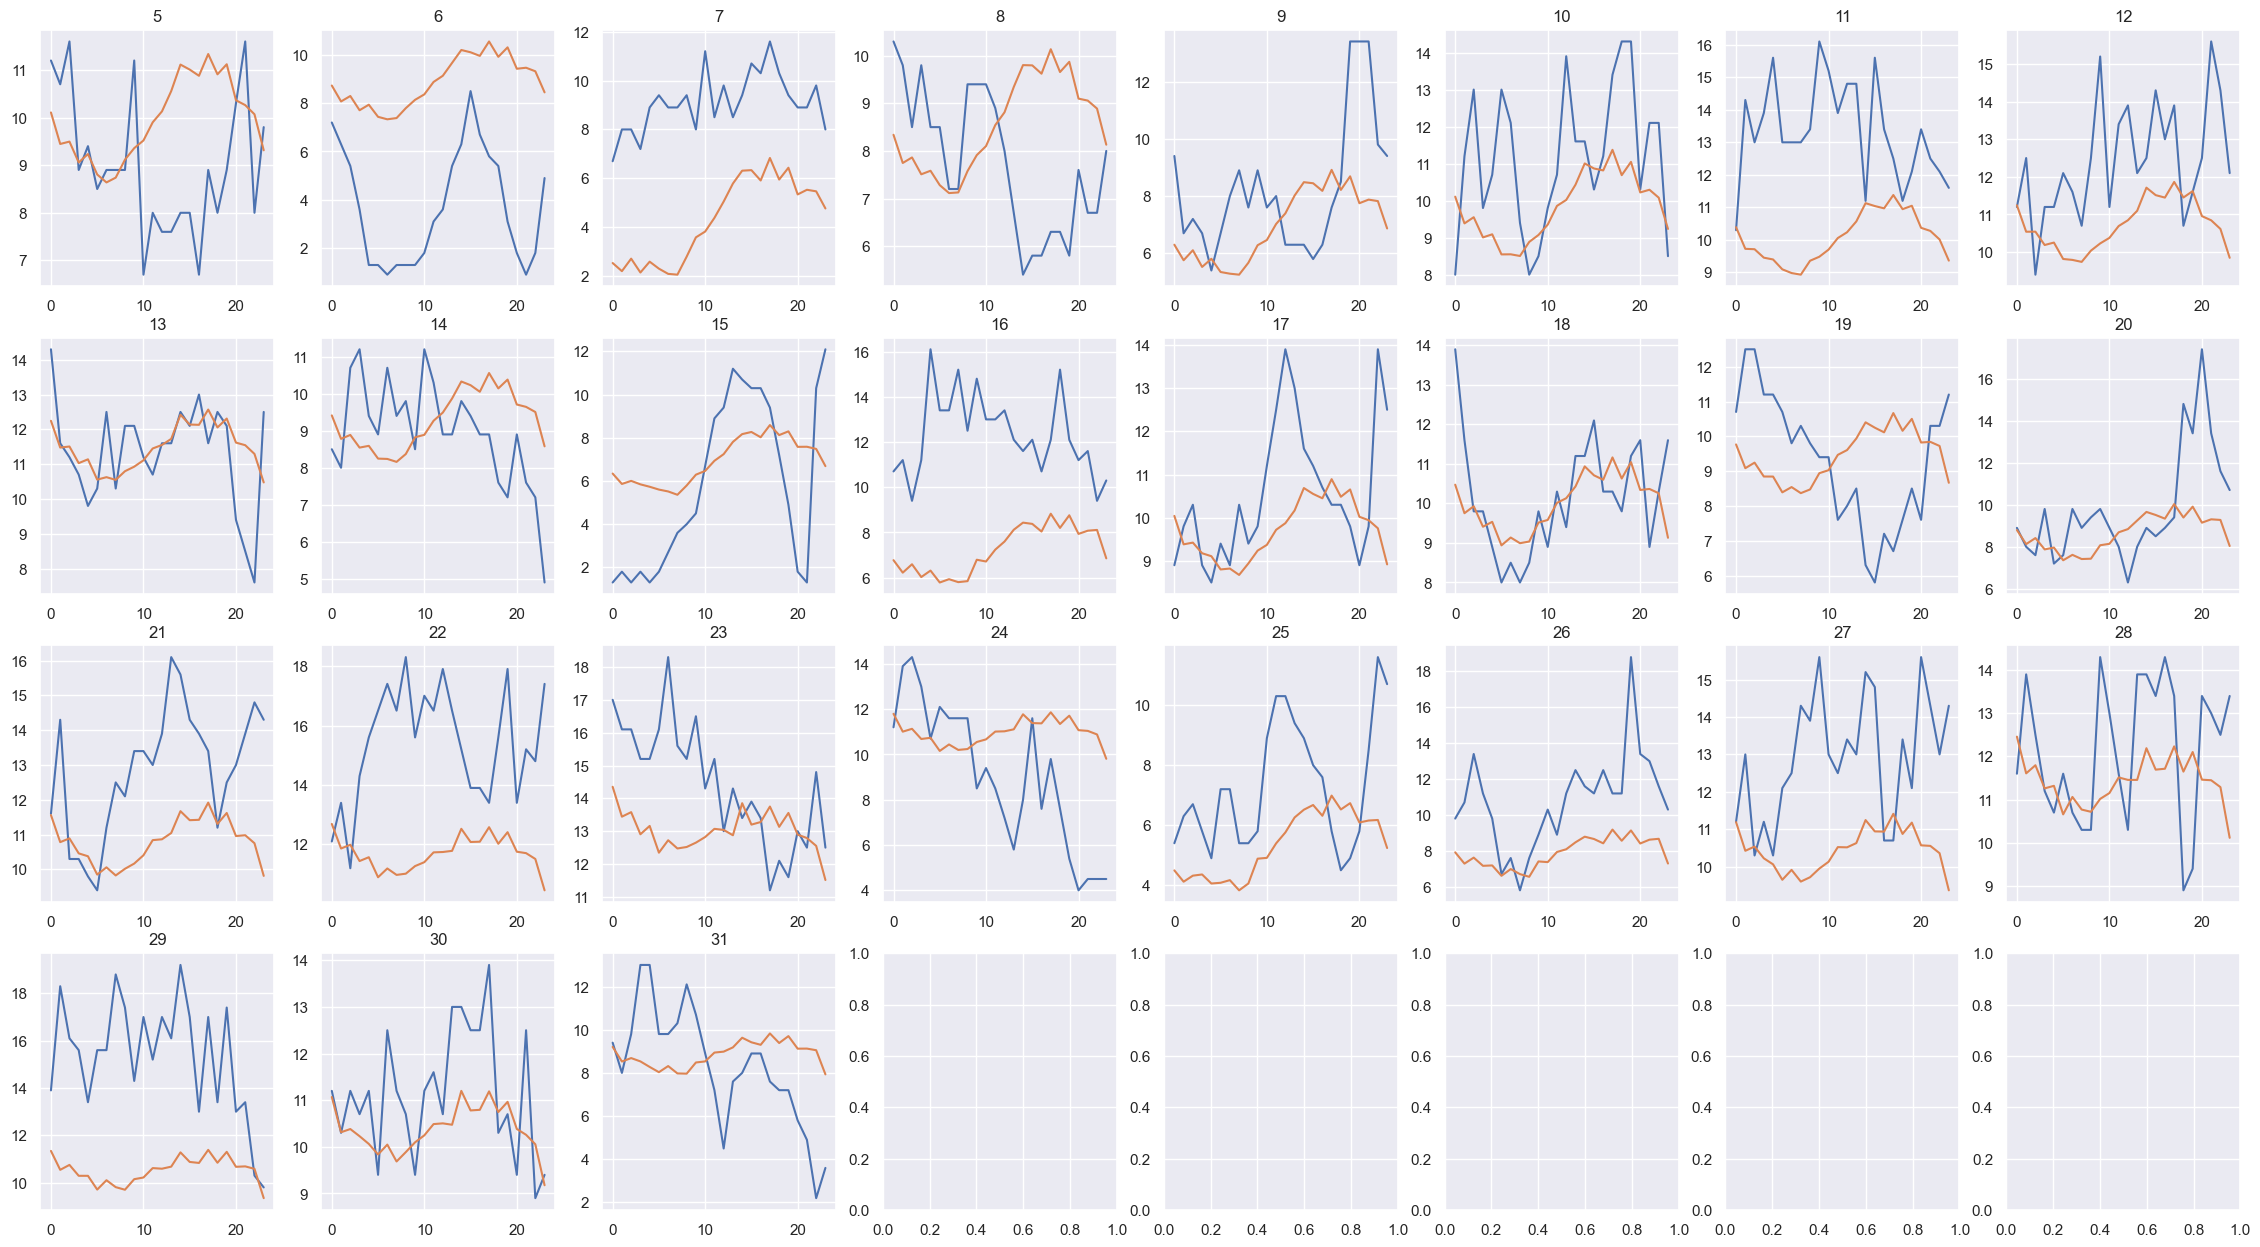

In [84]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[0]] # Diciembre
print(keys[0])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 1, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Febrero

Febrero


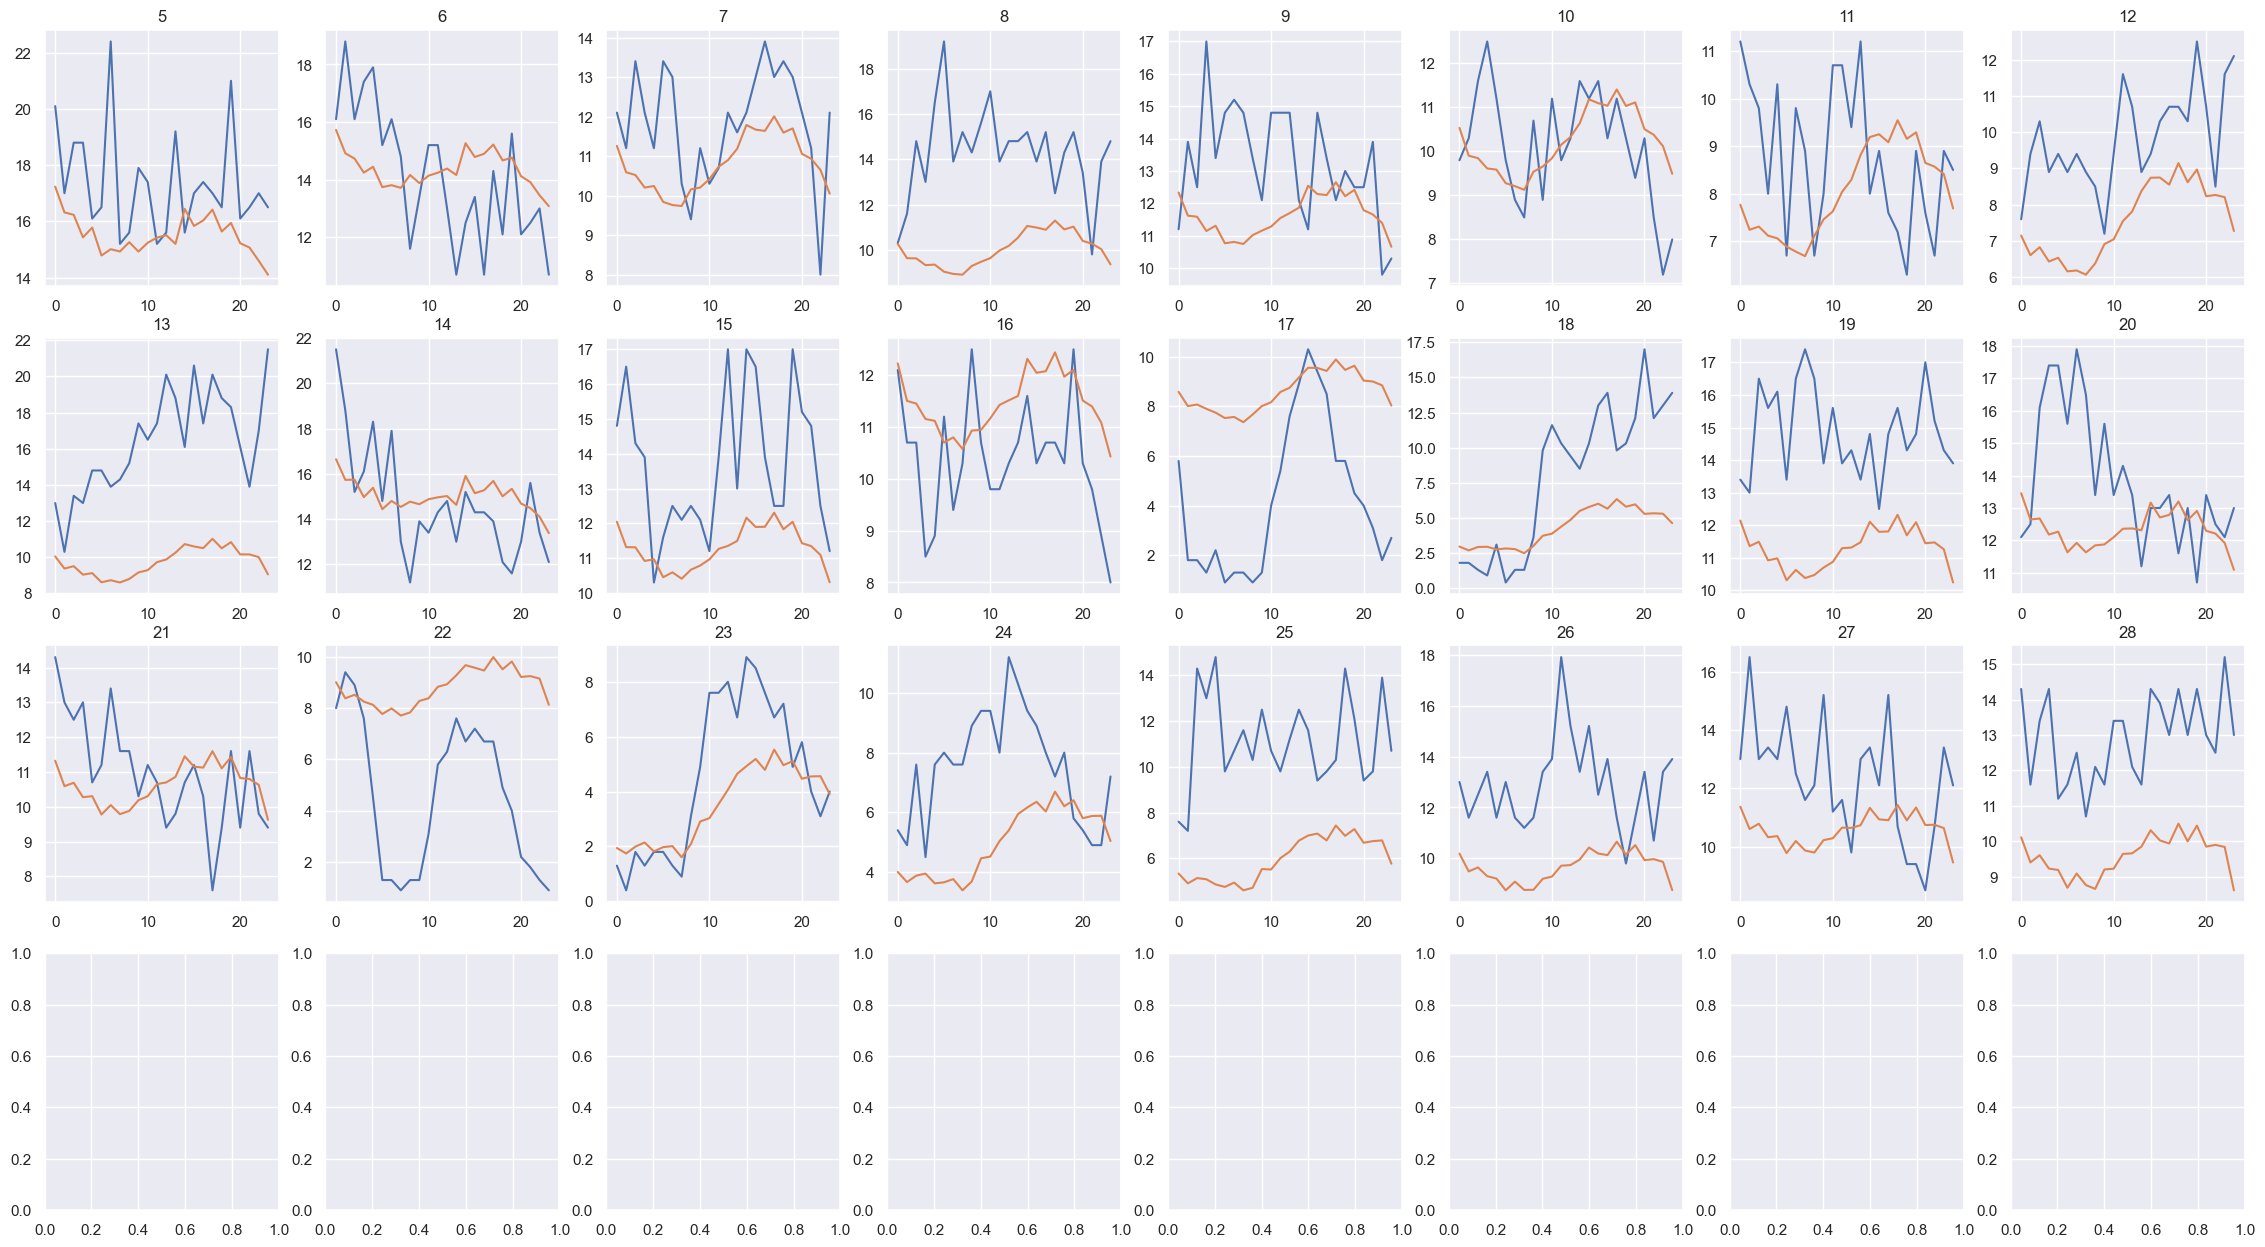

In [85]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[1]] # Febrero
print(keys[1])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 2, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Marzo

Marzo


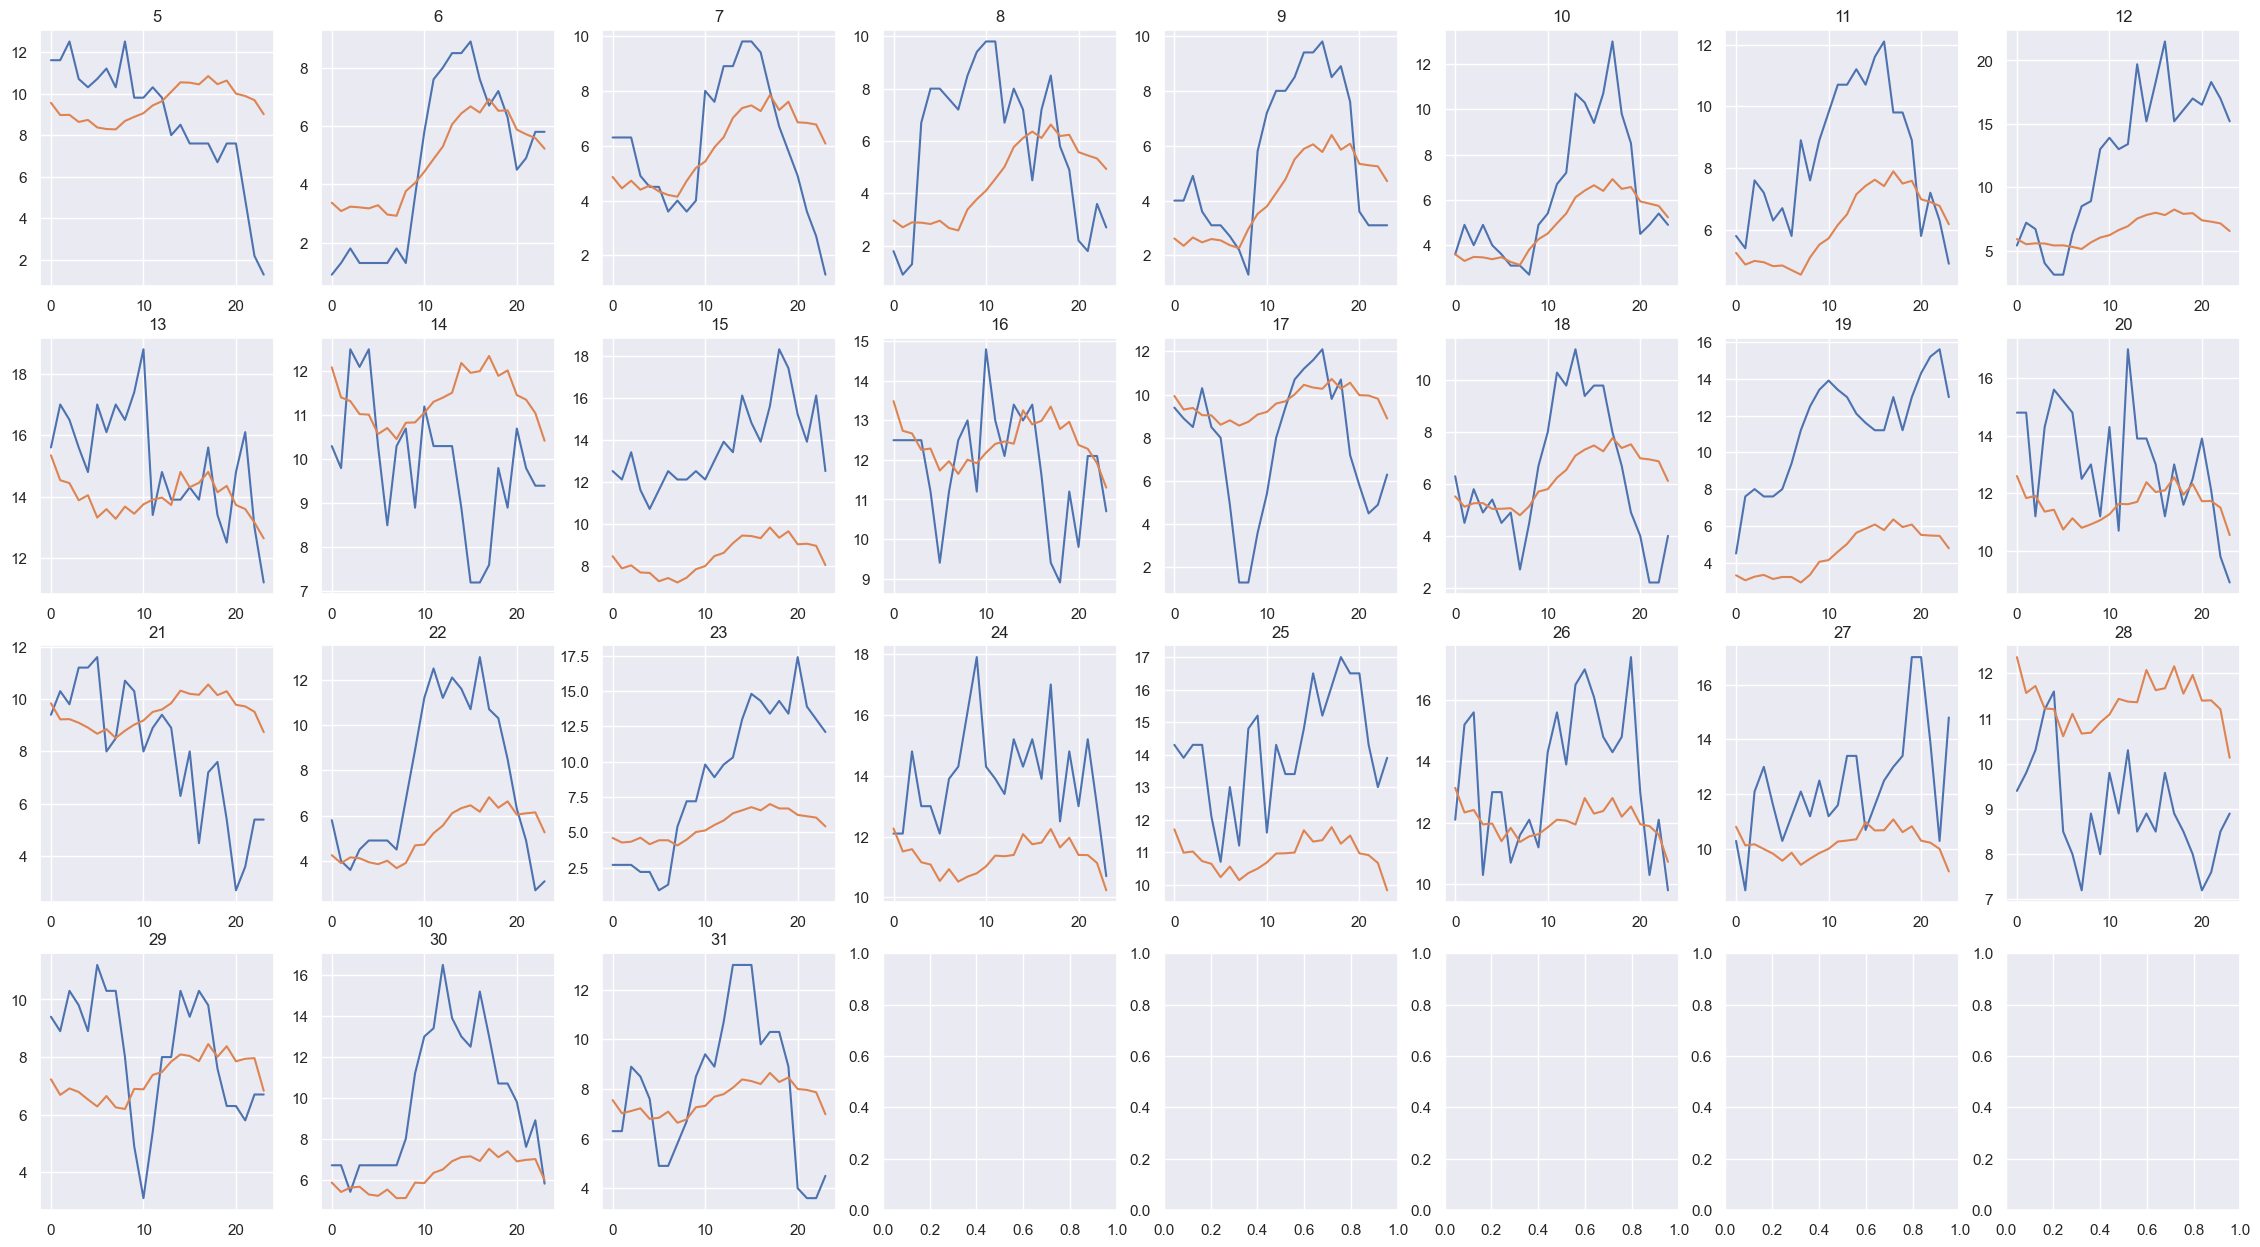

In [86]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[2]] # Marzo
print(keys[2])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 3, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Abril

Abril


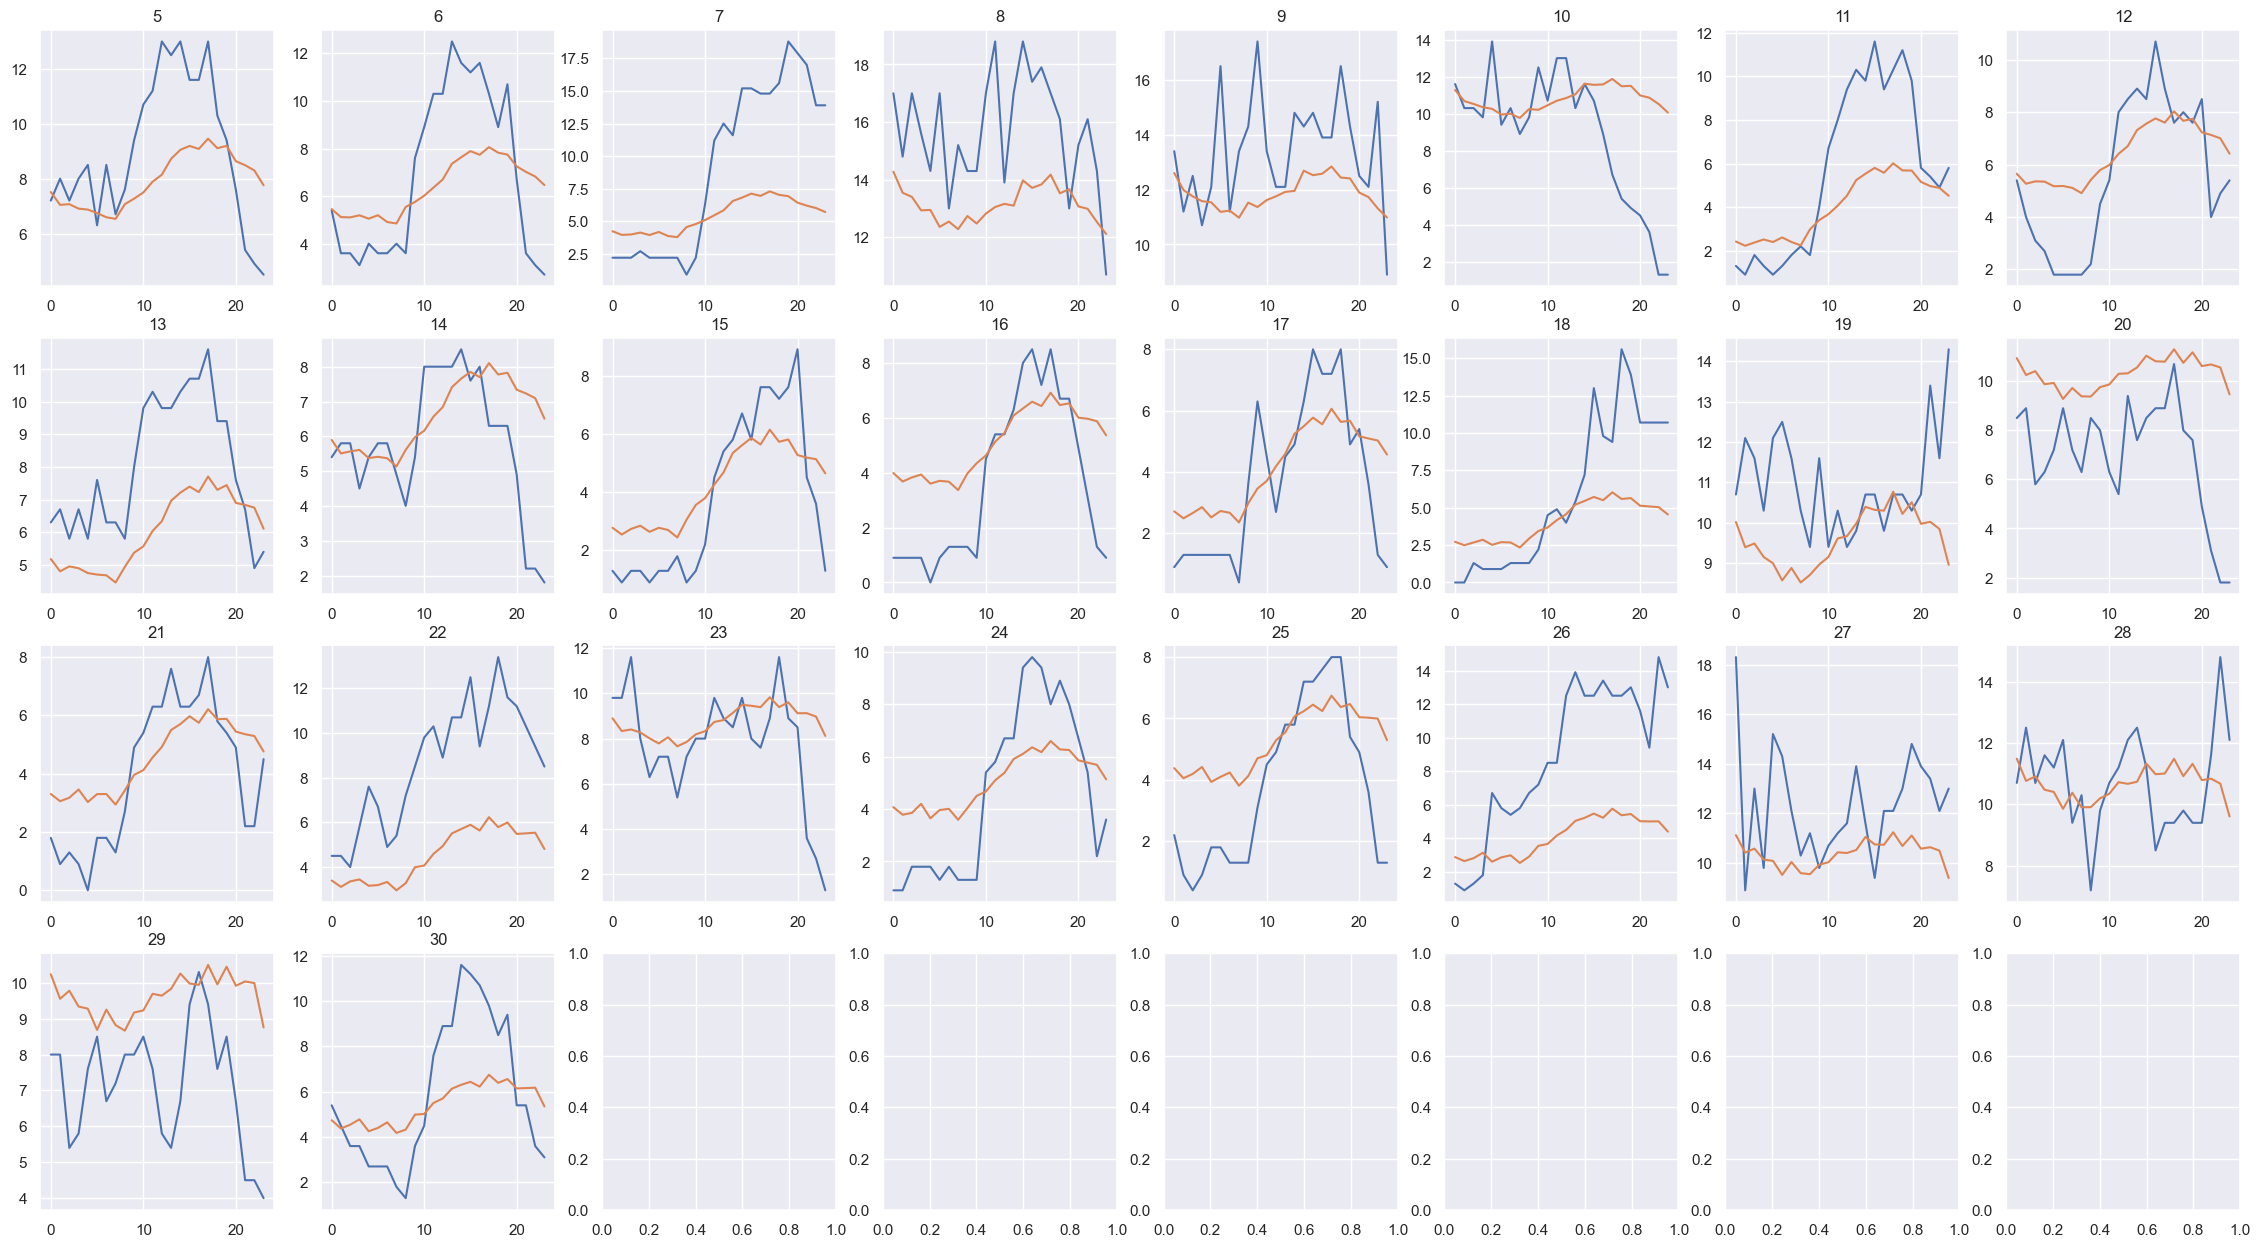

In [87]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[3]] # Abril
print(keys[3])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 4, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Mayo

Mayo


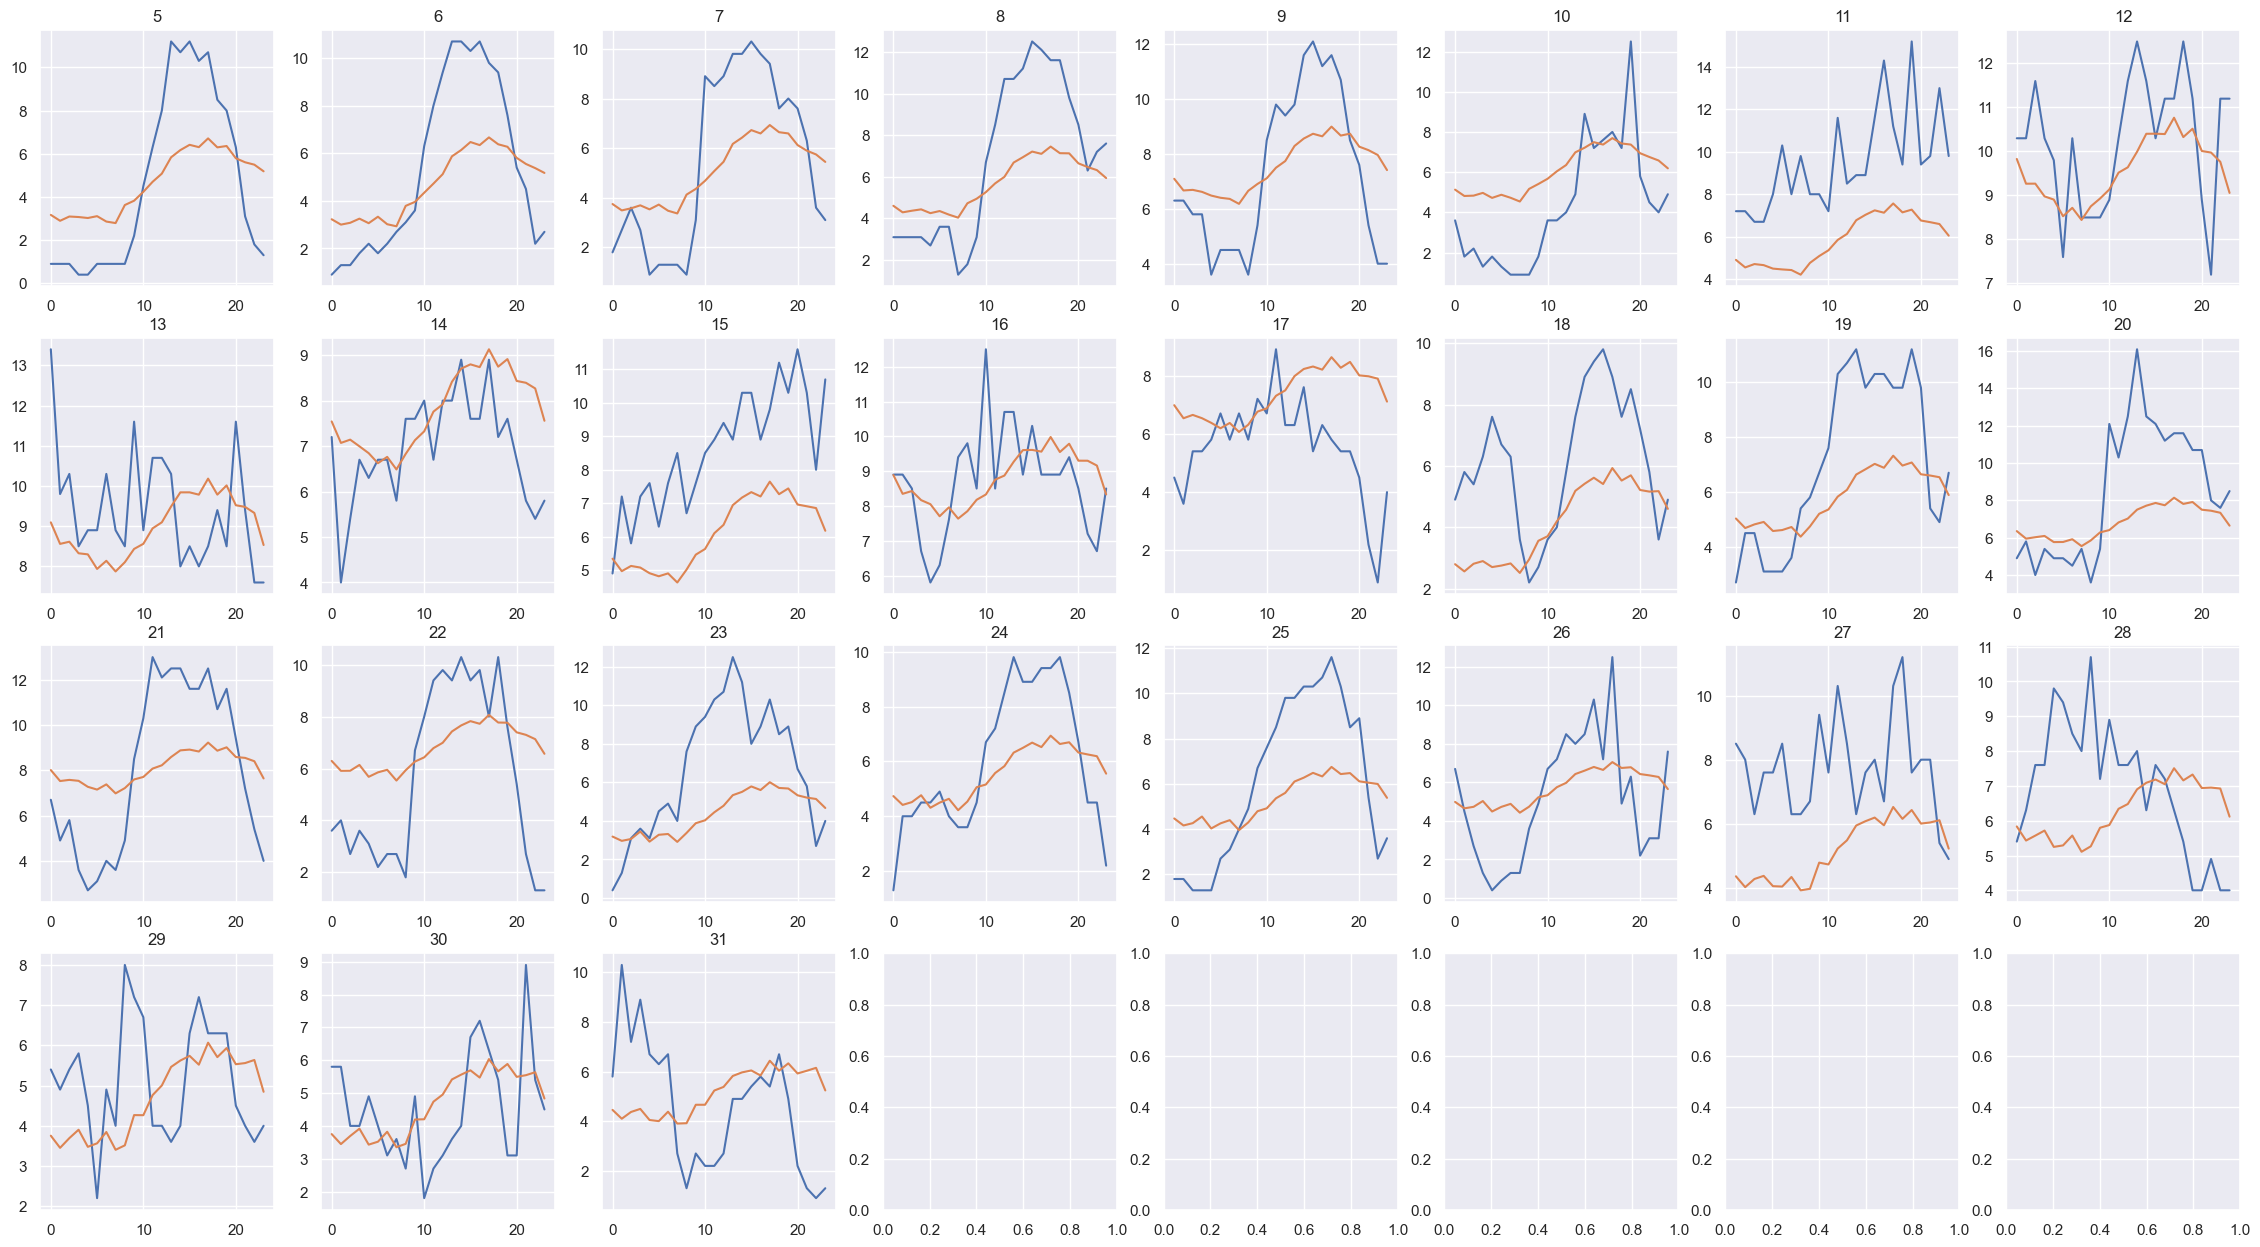

In [88]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[4]] # Mayo
print(keys[4])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 5, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Junio

Junio


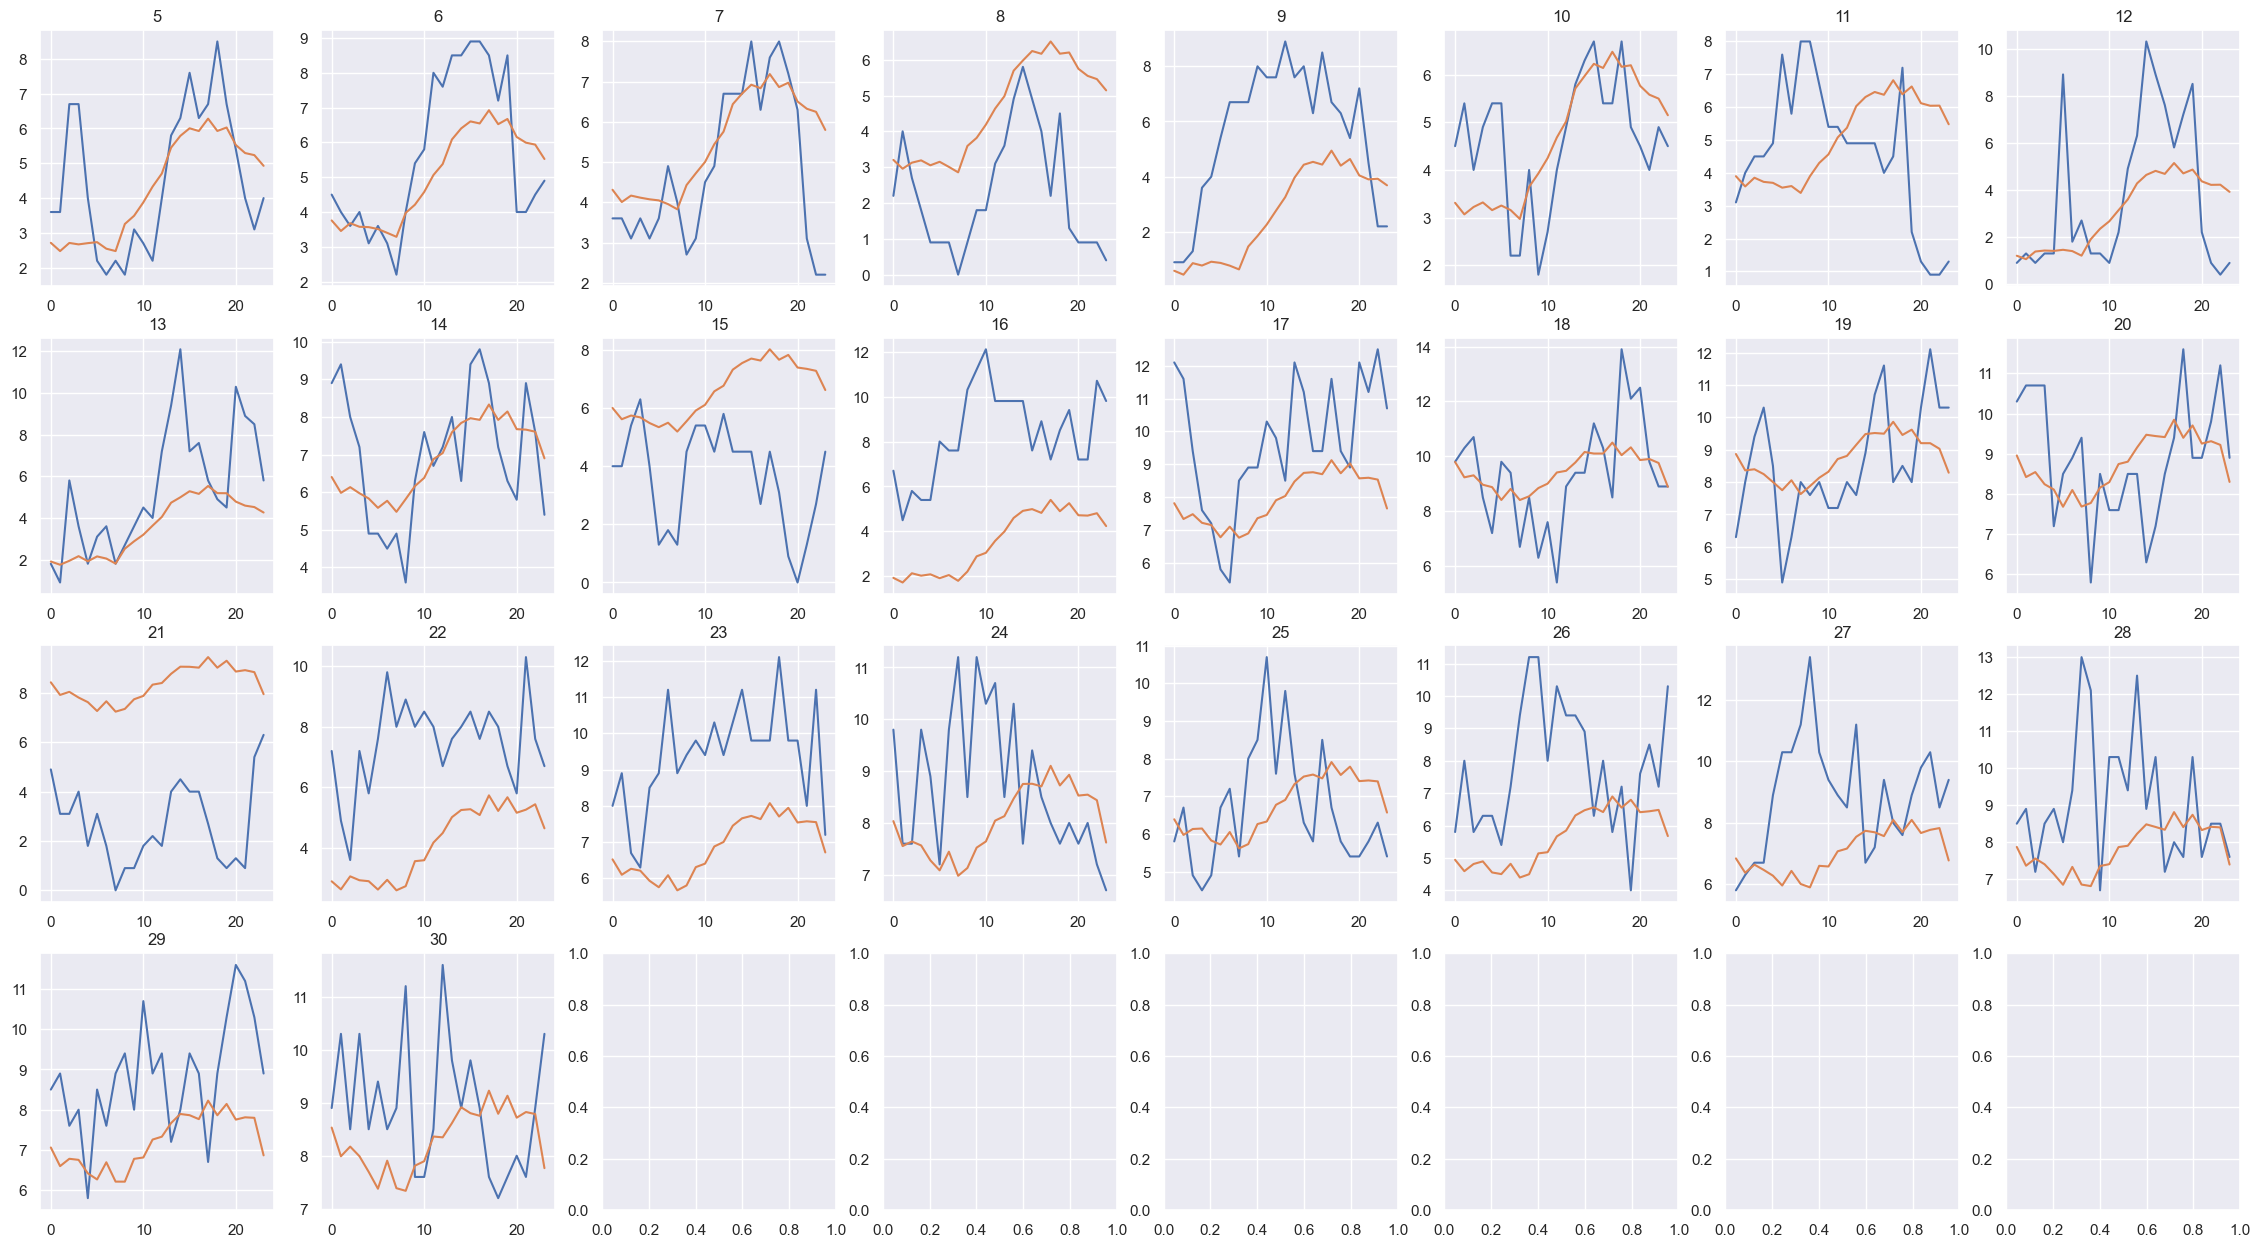

In [89]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[5]] # Junio
print(keys[5])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 6, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Julio

Julio


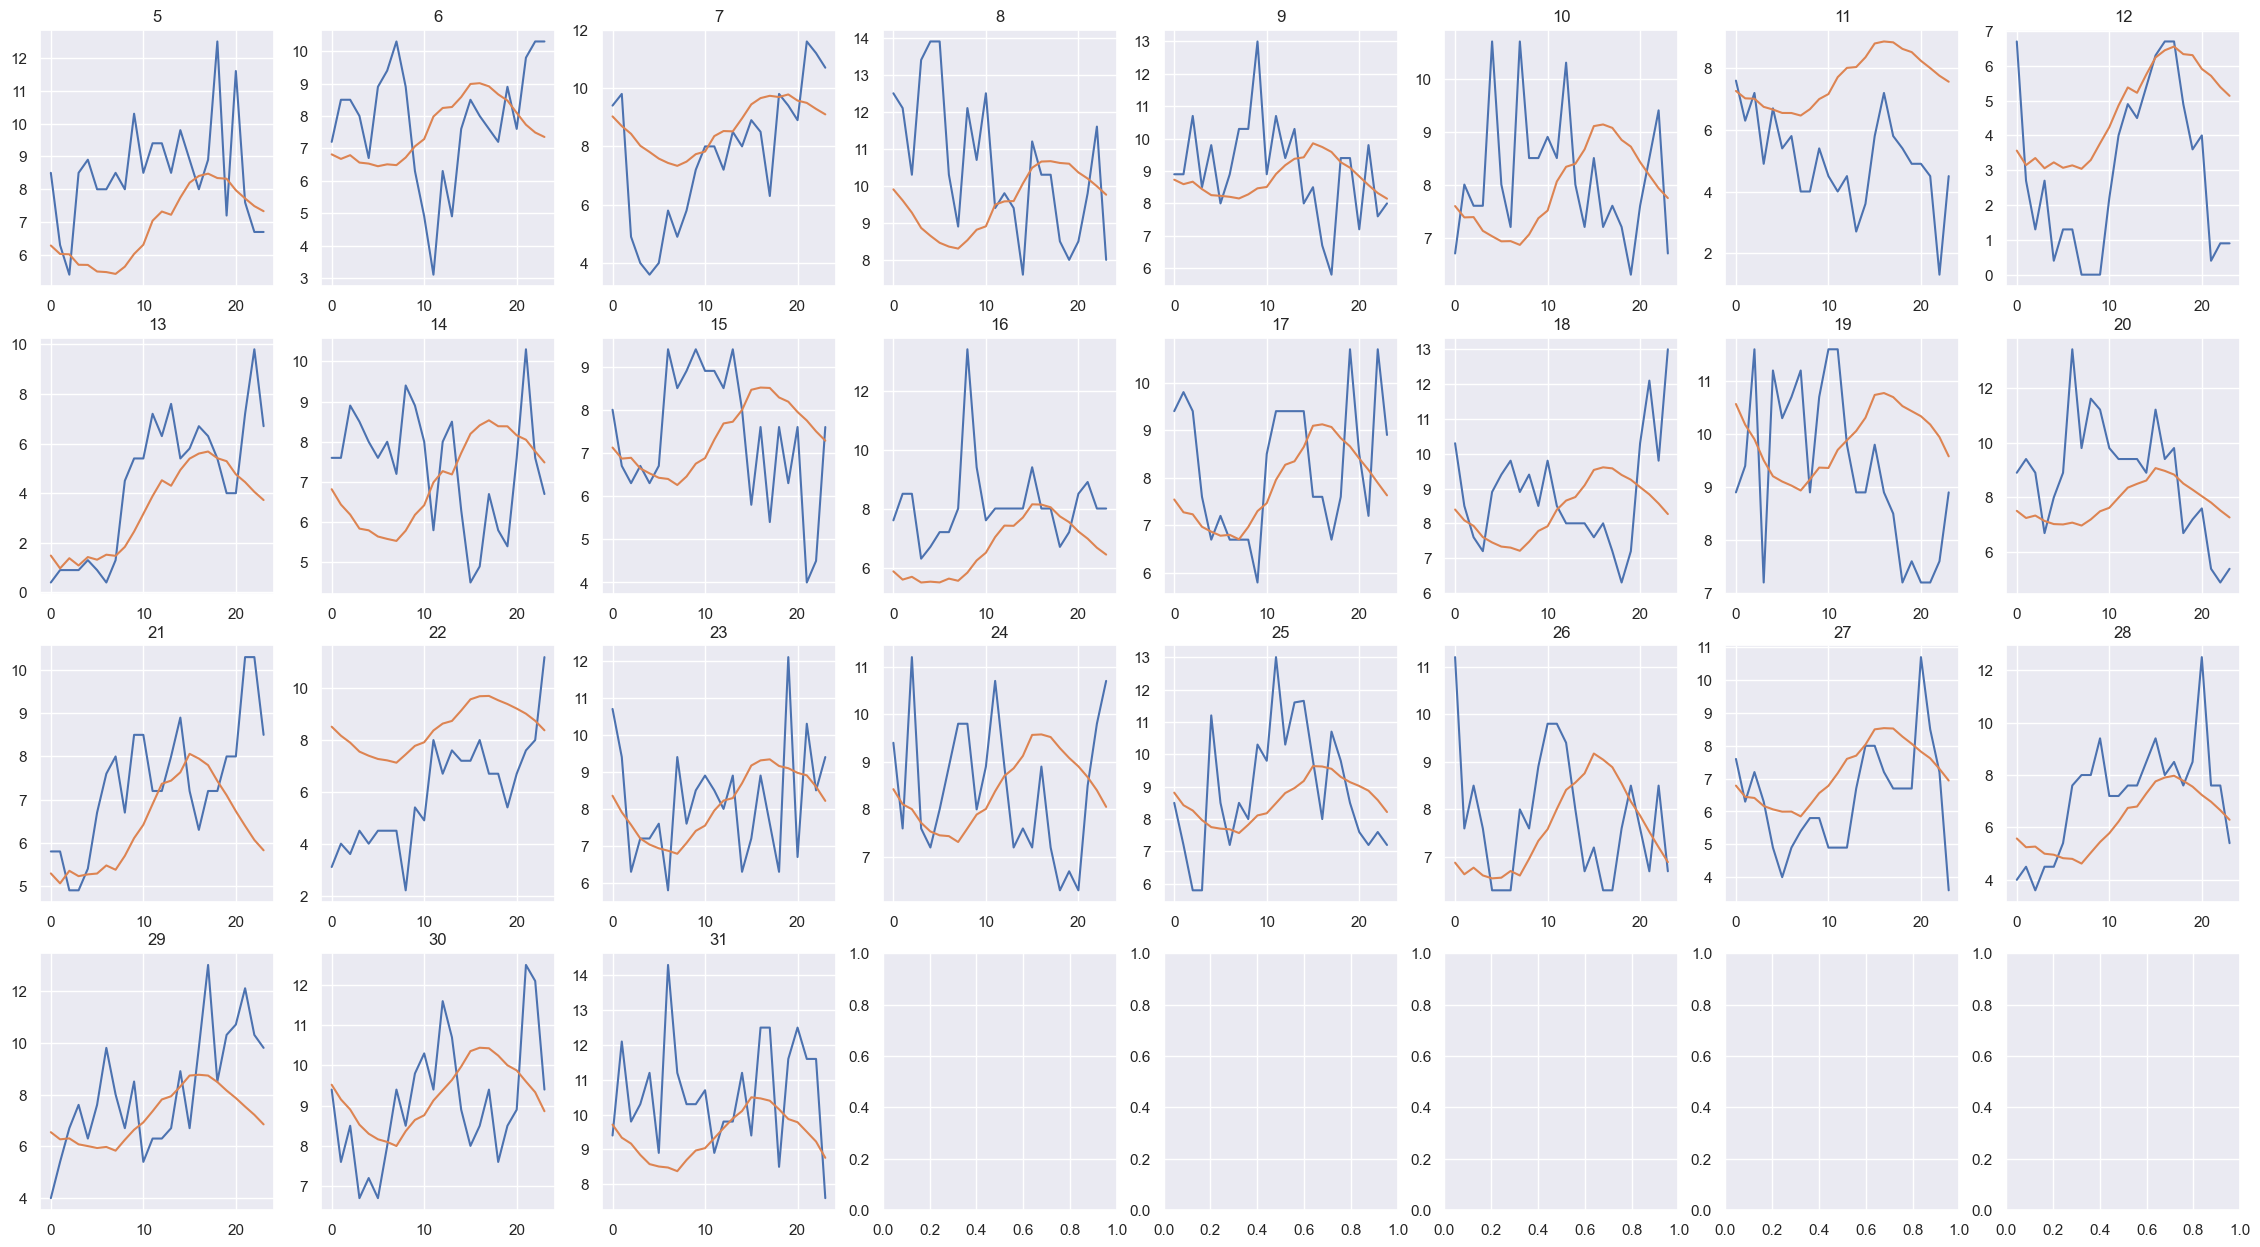

In [90]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[6]] # Febrero
print(keys[6])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 7, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Agosto

Agosto


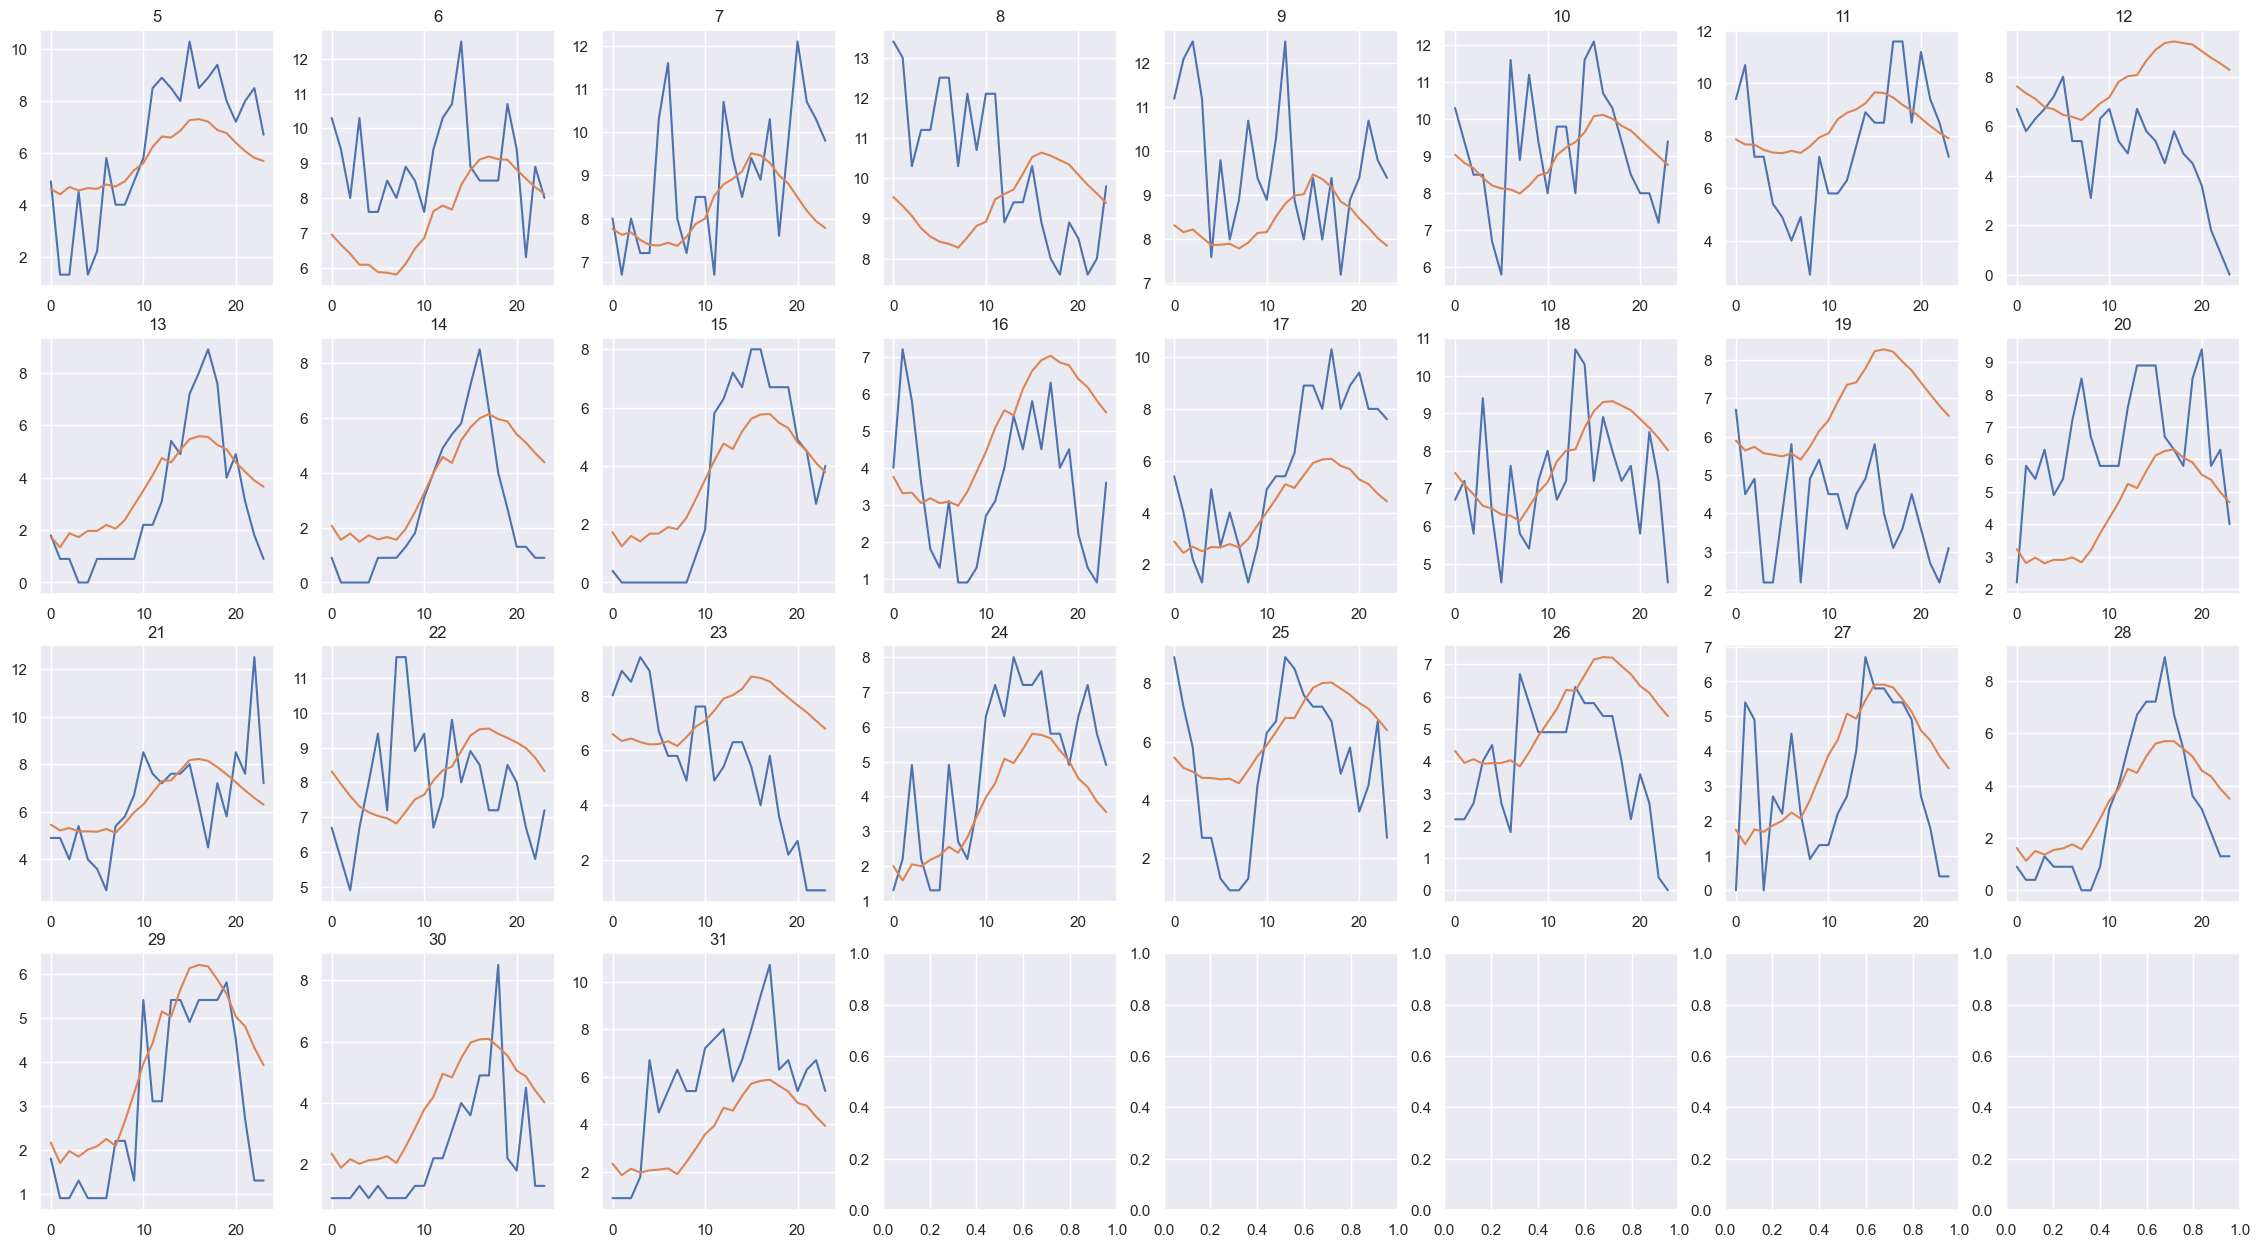

In [91]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[7]] # Febrero
print(keys[7])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 8, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Septiembre

Septiembre


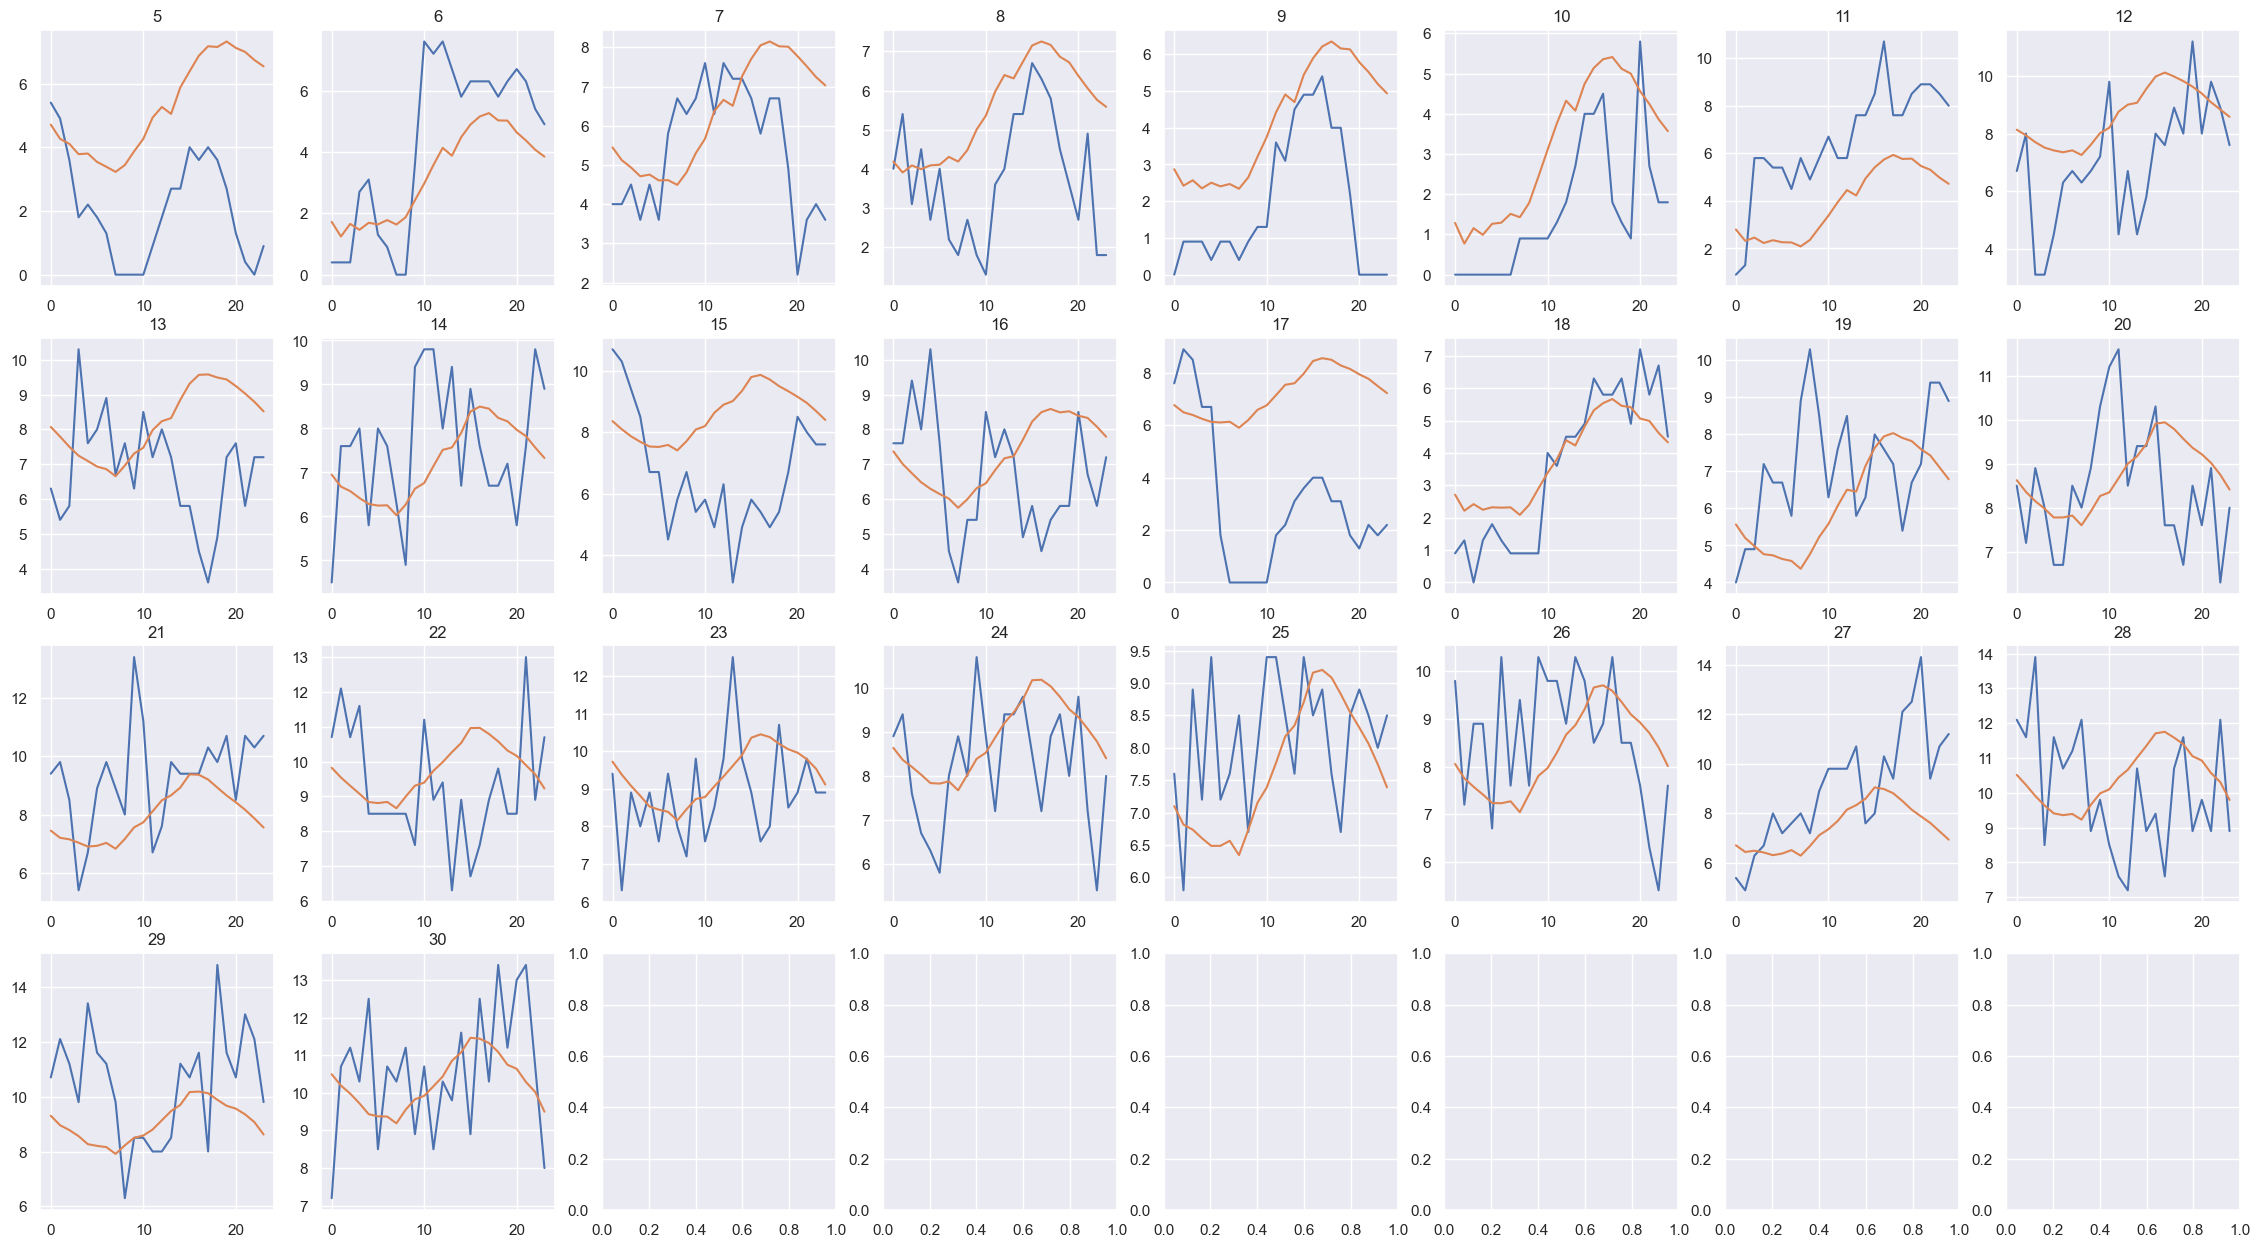

In [92]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[8]] # Febrero
print(keys[8])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 9, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Octubre

Octubre


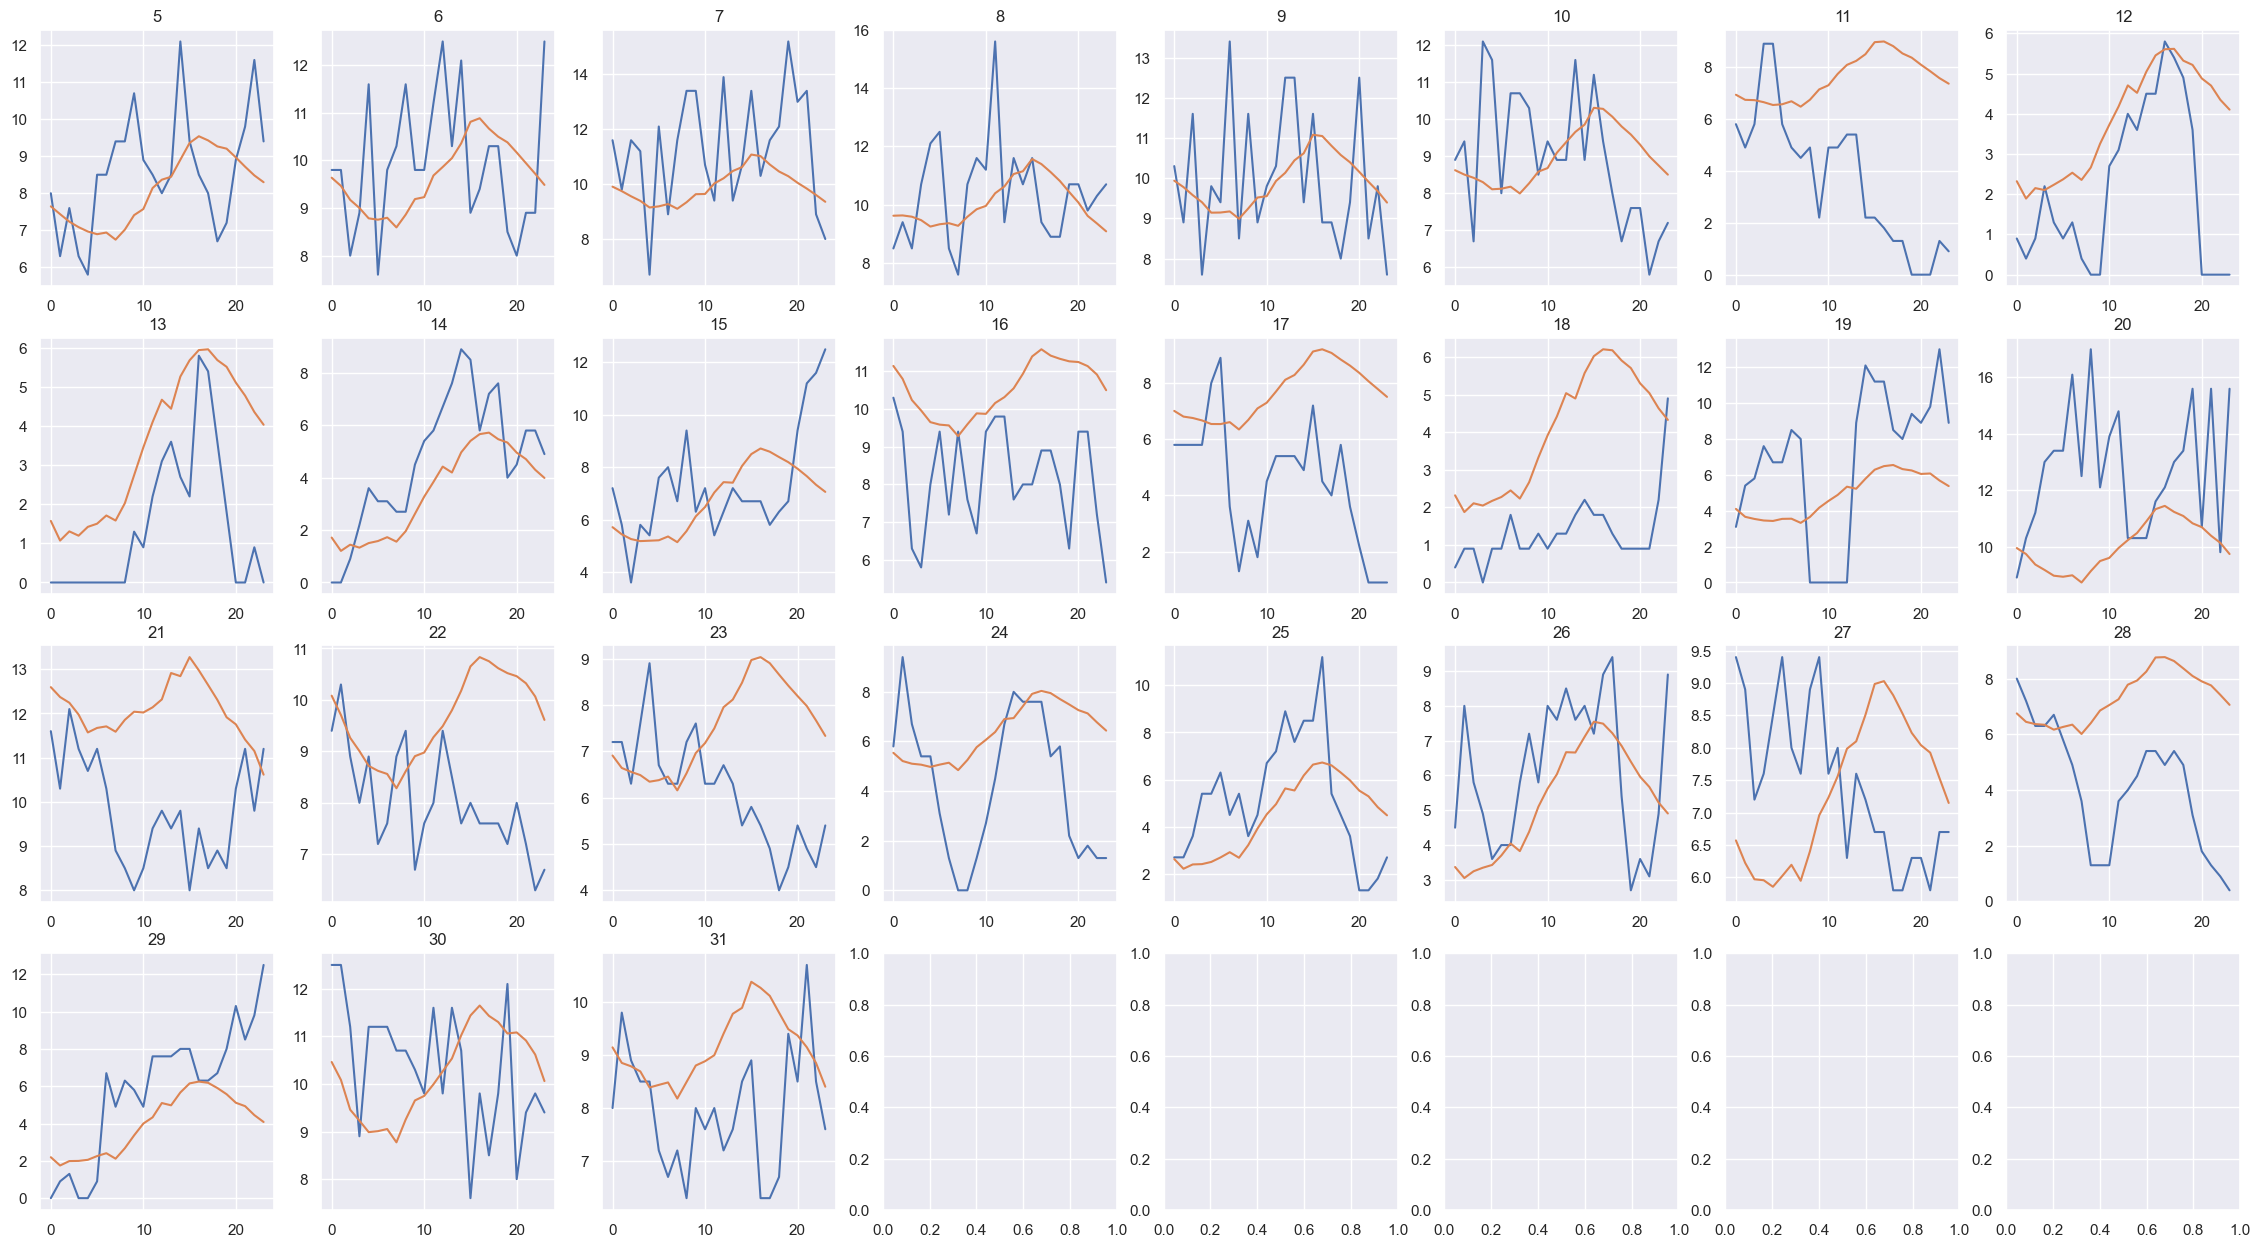

In [93]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[9]] # Octubre
print(keys[9])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 10, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Noviembre

Novimebre


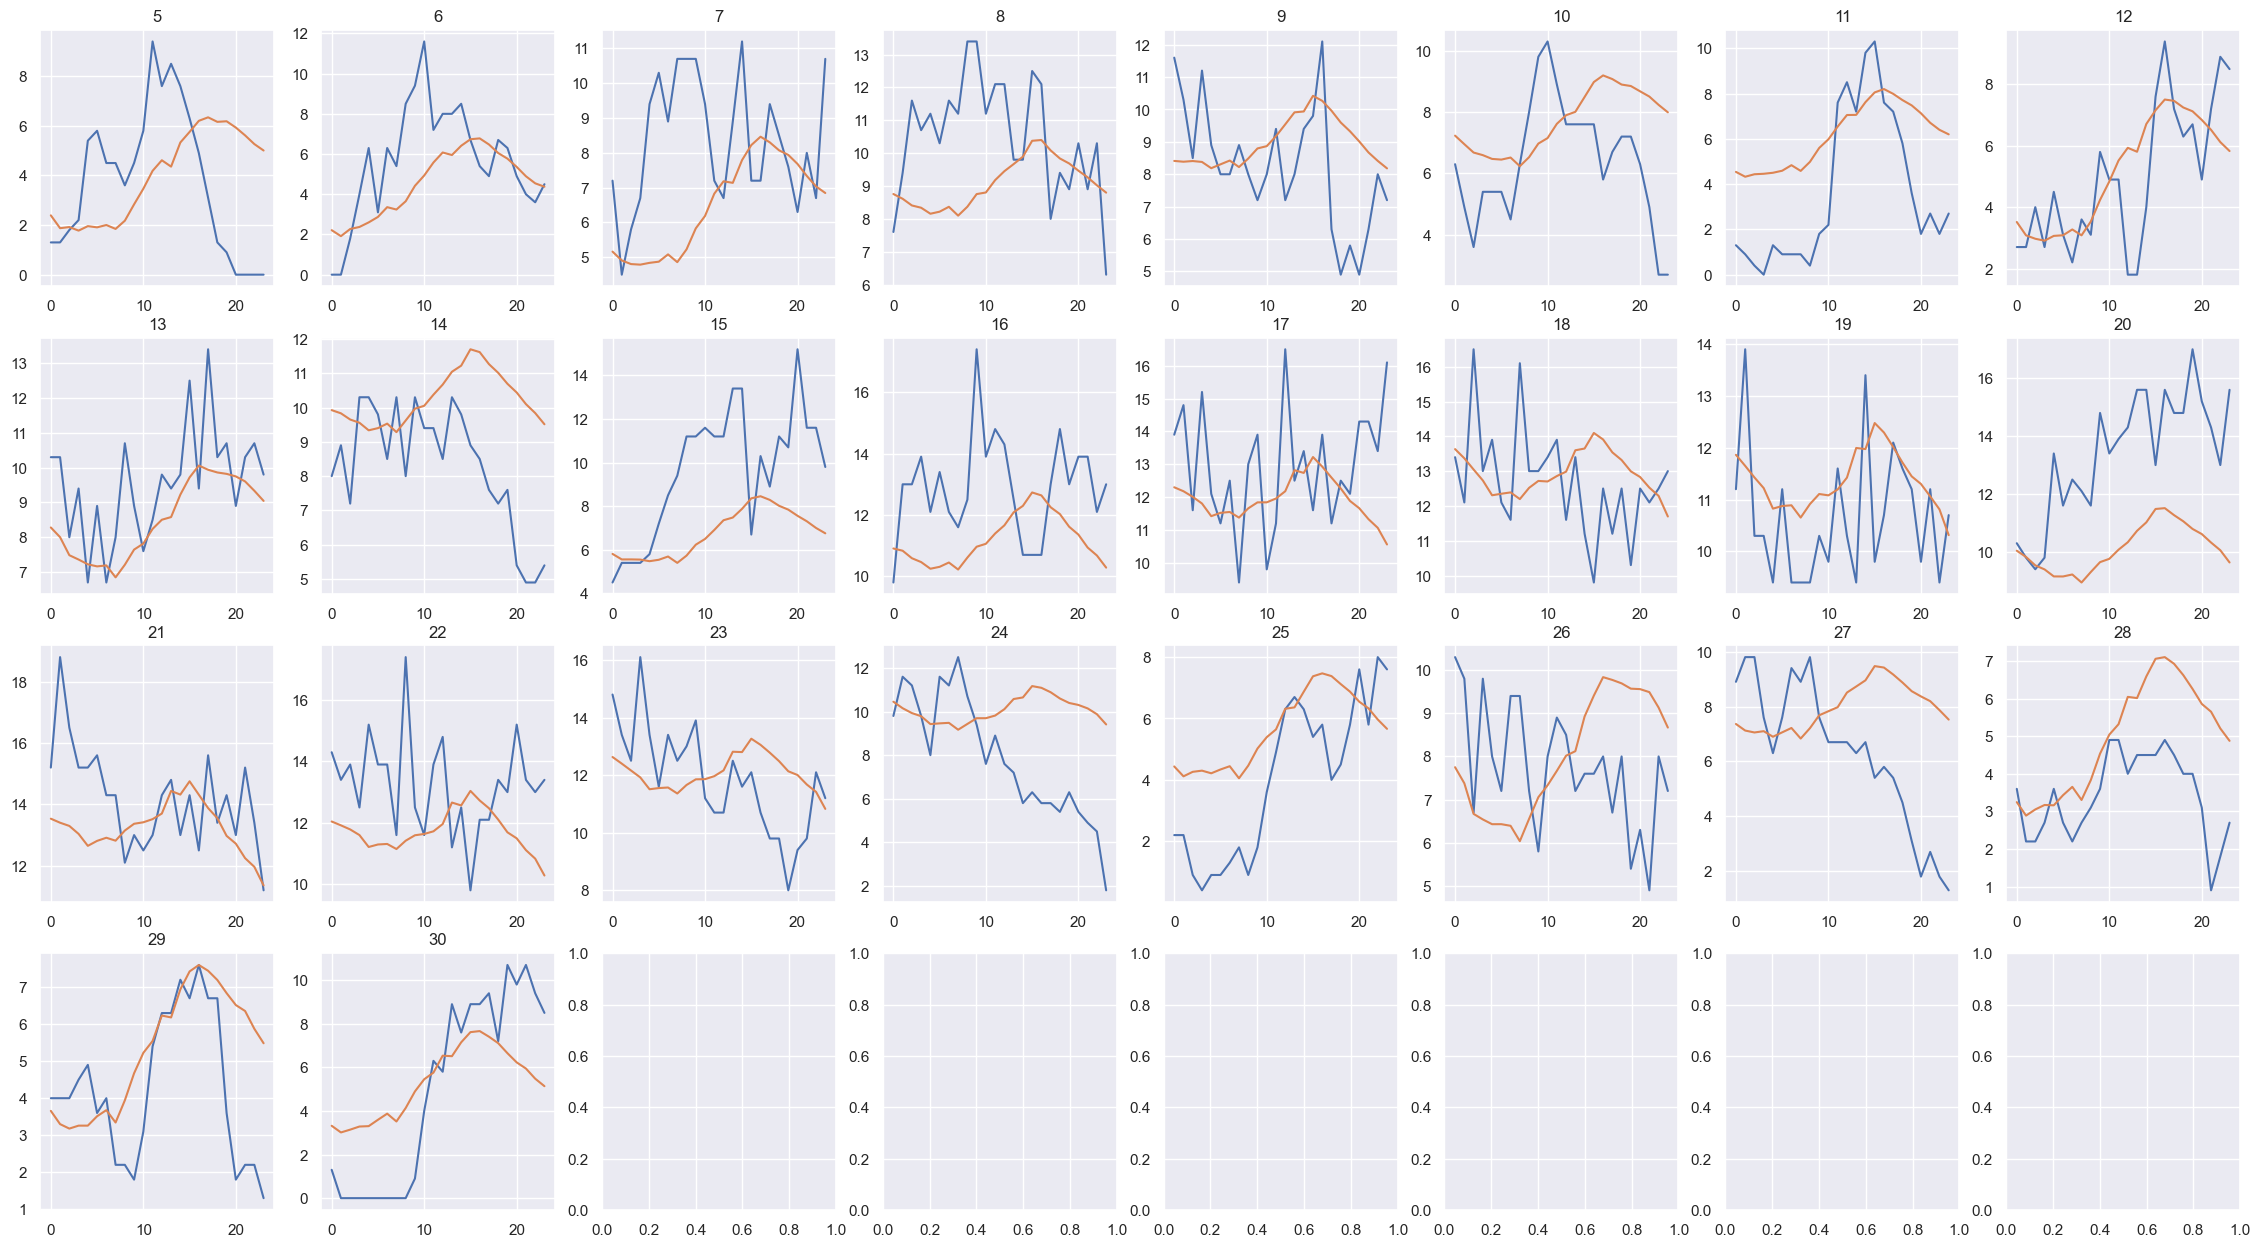

In [94]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[10]] # Febrero
print(keys[10])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 11, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

#### Diciembre

Diciembre


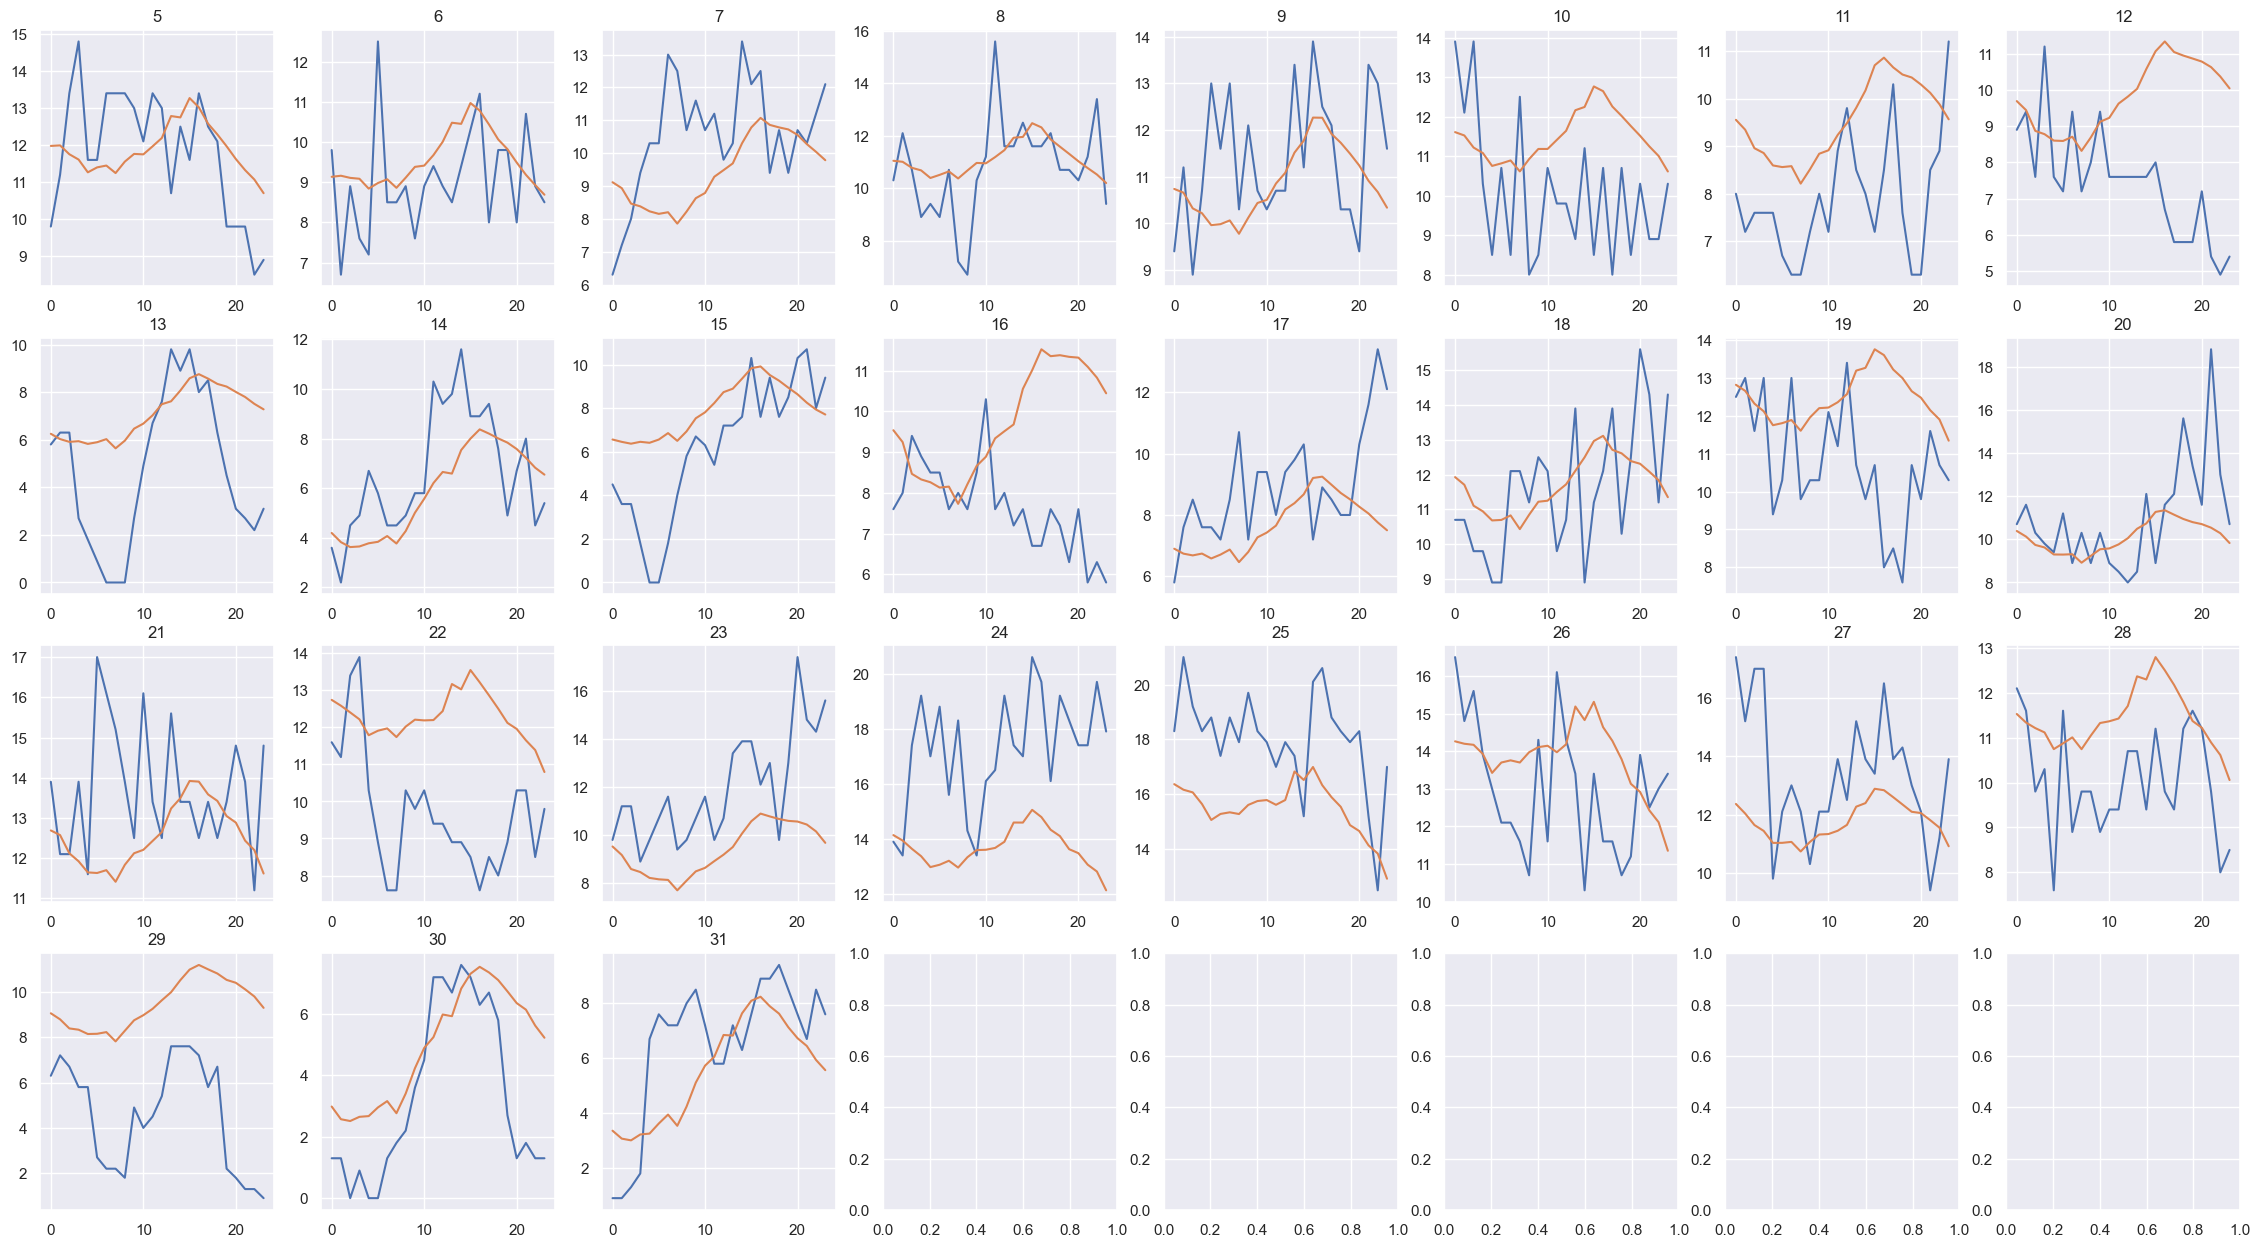

In [ ]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[11]] # Diciembre
print(keys[11])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 11, i, model, minmax)
    c = scl_inv.inverse_transform(c.reshape(-1, 1))
    pred = scl_inv.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()

### Recursivo

In [105]:
# Dataset Entrenamiento
comb = list_rect[4]
print(comb)
df_train = df_Nizanda.copy()
drop_cols = [col for col in df_Nizanda.columns if col not in comb[0]]
df_train.drop(drop_cols, axis = 1, inplace = True)

minmax = MinMaxScaler(feature_range=(-1,1))
df_train = minmax.fit_transform(df_train)

xtr, ytr = crear_dataset_supervisado(df_train, input_length = comb[1], output_length = comb[2])

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {xtr.shape}, y_tr: {ytr.shape}')
#print(f'Set de prueba - x_ts: {xts.shape}, y_ts: {yts.shape}')

(['High Wind Speed m/s'], 24, 1)
Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (17386, 24, 1), y_tr: (17386, 1, 1)


In [106]:
N_UNITS = 48
INPUT_SHAPE = (xtr.shape[1], xtr.shape[2])
OUTPUT_LENGTH = 1
DROPOUT = 0.3
LR = 0.01
# Creacion del modelo LSTM
model = Sequential()
model.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE, activation = 'tanh'))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la velocidad del viento
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = tf.keras.optimizers.Adam(LR)

model.compile(optimizer = optimizador, loss = root_mean_squared_error, metrics=['mae'])

In [107]:
EPOCHS = 1
BATCH_SIZE = 64

history = model.fit(
    x = xtr,
    y = ytr,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=2,
)

272/272 - 2s - loss: 0.1514 - mae: 0.1175 - 2s/epoch - 8ms/step


In [114]:
comb = list_rect[4]
print(comb)

inicio = 0
if comb[1] == 24:
    inicio = 2
elif comb[1] == 48:
    inicio = 3
if comb[1] == 72:
    inicio = 4
elif comb[1] == 96:
    inicio = 5
#else:
    #inicio = -1

params = {'units': [N_UNITS], 'activation': ['tanh'], 'optimizer': ['Adam'], 'learning_rate': [0.01], 'dropout': [0.3], 'layers': [1], 'batch_size': [64]}


(['High Wind Speed m/s'], 24, 1)


In [ ]:
scl_inv = MinMaxScaler()
scl_inv.min_, scl_inv.scale_ = minmax.min_[3], minmax.scale_[3]

#### Enero

Enero


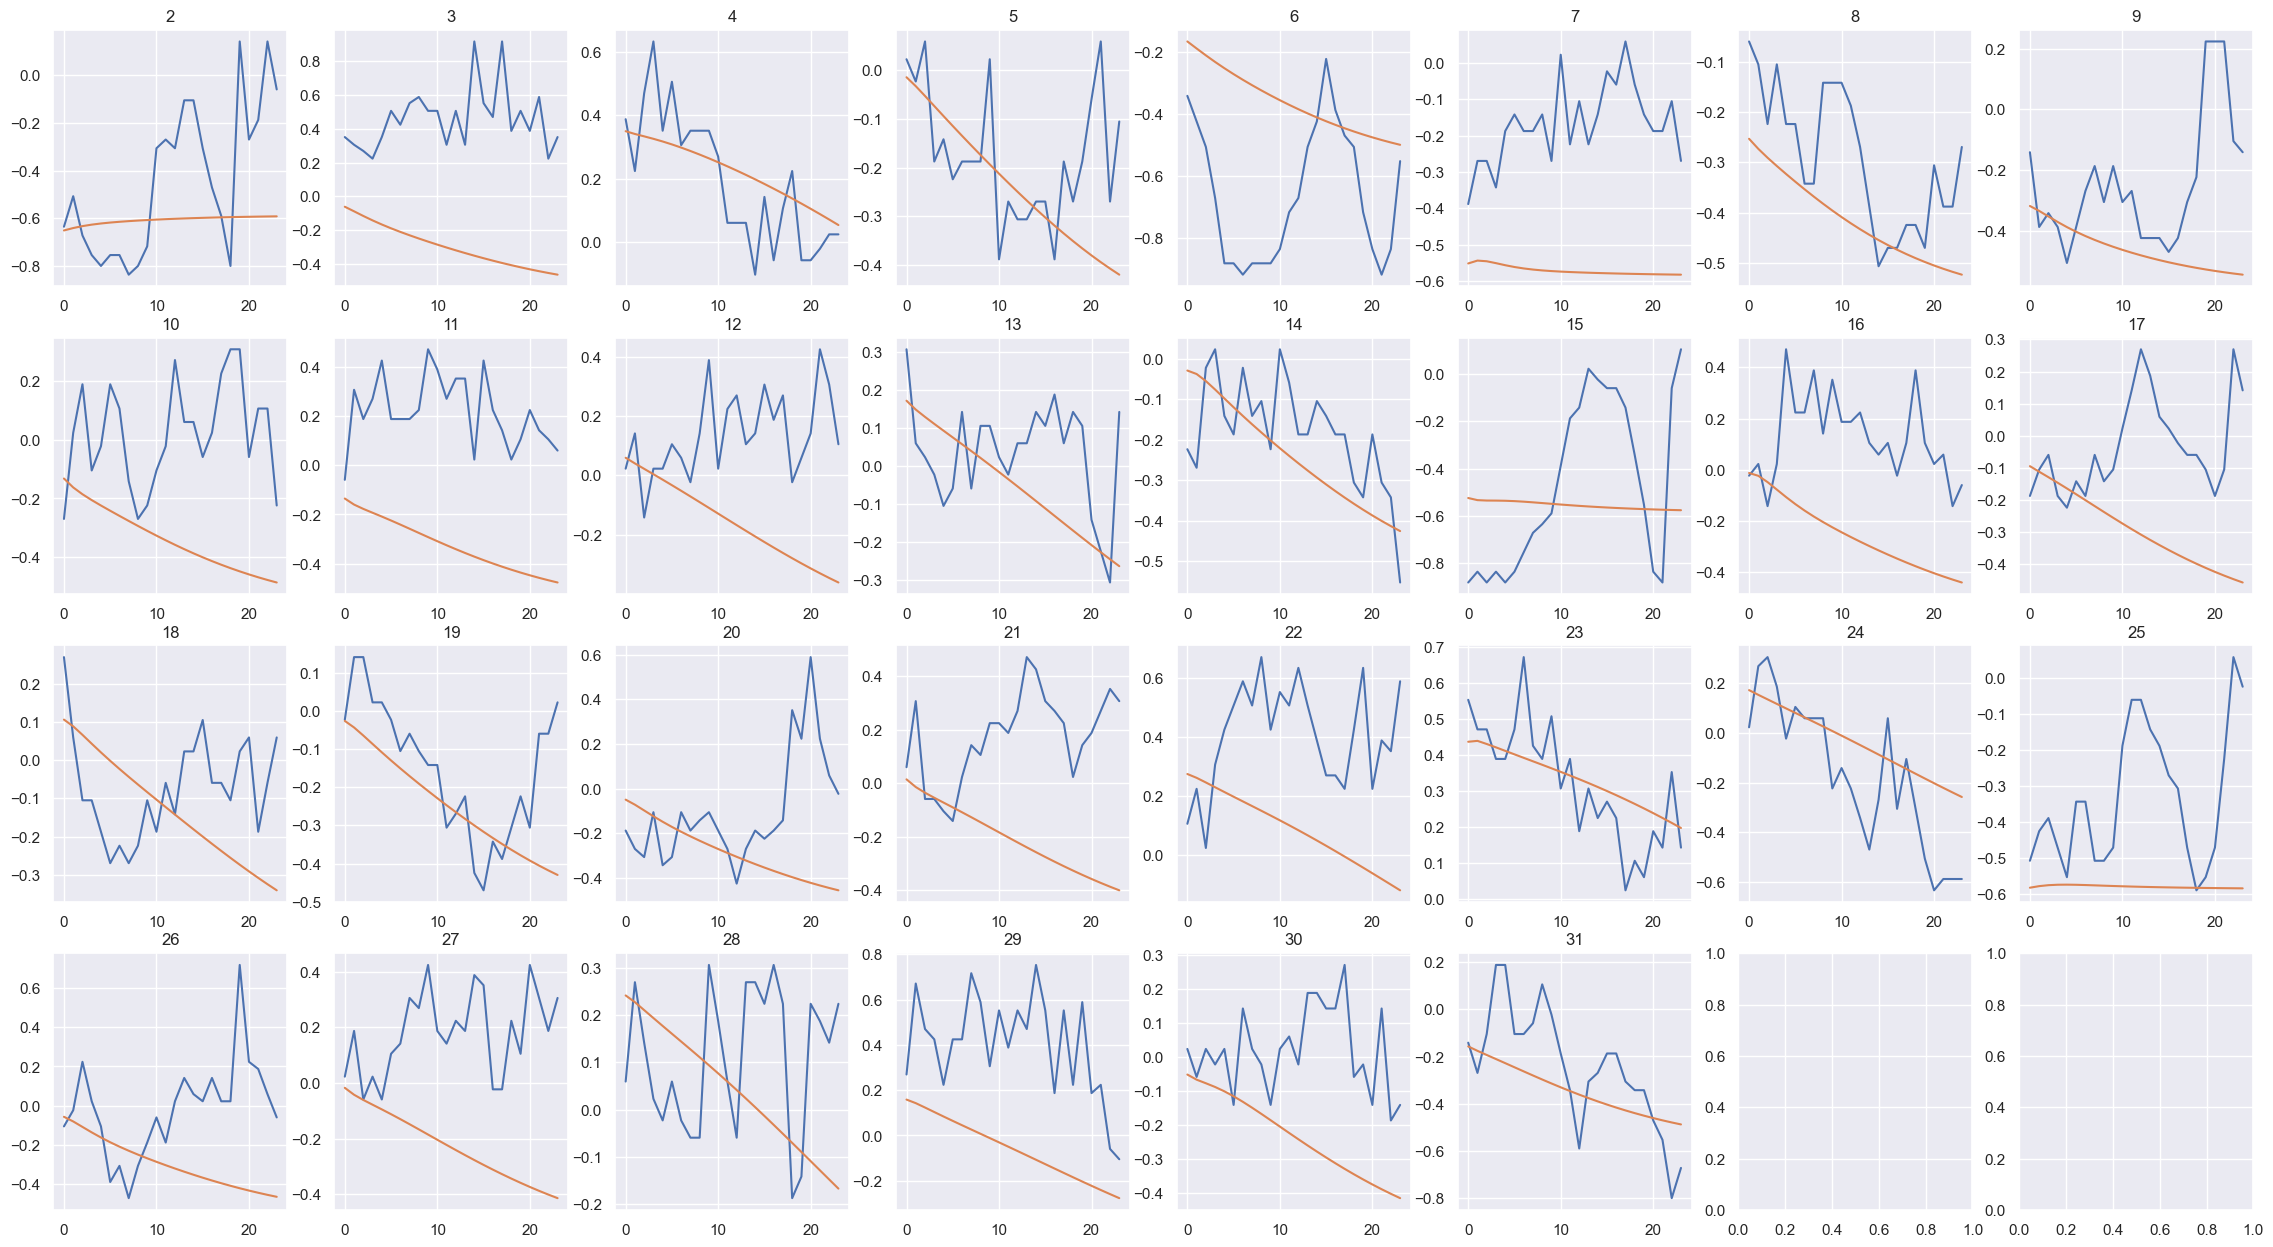

In [121]:
figure, axis = plt.subplots(4, 8, figsize=(16,10)) 
plt.subplots_adjust(bottom=-0.3, right = 1.5)

fila = 0
columna = 0
dia = 1
df_mes = Meses[keys[0]] # Diciembre
print(keys[0])
for i in range(inicio, len(df_mes['Day'].unique()) + 1):
    
    m, c, pred = sim(comb, 1, i, model, minmax)
    #c = minmax.inverse_transform(c.reshape(-1, 1))
    #pred = minmax.inverse_transform(pred.reshape(-1, 1))
    #plot_series(c.flatten(), pred.flatten())
    
    axis[columna, fila].plot(c.flatten())
    axis[columna, fila].plot(pred.flatten())
    axis[columna, fila].set_title(str(i))
    
    if dia % 8 == 0:
        fila = 0
        columna += 1
    else:
        fila += 1
    dia += 1

plt.show()